<div style="text-align:left; font-size:13pt; font-family:'Tahoma','Verdana',sans-serif; line-height:1.8;">

# 🚗 Vehicle Insurance Claim Prediction  

This project focuses on analyzing a **vehicle insurance dataset** and building predictive models.  
We explore key policy and vehicle-related features to gain insights and create two types of models:  

1. **Classification Model** 🧩  
   - 🎯 Target: `CLAIM_FLAG` (0 = No Claim, 1 = Claim)  
   - Goal: Predict whether a new insurance contract will result in a claim or not.  

2. **Regression Model** 📈  
   - 🎯 Target: `CLAIM_PAID` (numeric value of claim amount)  
   - Goal: Estimate the potential claim amount for policies that have a claim.  

---

## 📊 Dataset Overview  

The dataset includes **policy details, vehicle specifications, and claim information**.  
Key features:  

- `SEX` → Gender of policyholder (0=Male, 1=Female, 2=Organization)  
- `INSR_BEGIN`, `INSR_END`, `EFFECTIVE_YR` → Policy duration and effective year  
- `INSR_TYPE` → Type of insurance  
- `INSURED_VALUE`, `PREMIUM` → Policy financial details  
- `PROD_YEAR`, `SEATS_NUM`, `CARRYING_CAPACITY` → Vehicle specifications  
- `TYPE_VEHICLE`, `CCM_TON`, `MAKE`, `USAGE` → Vehicle type and usage  
- `CLAIM_PAID` → Claim amount (used for regression)  

From these, we will engineer **`CLAIM_FLAG`** as the main target for classification.  

---

## 🎯 Project Goals  

- 🧹 Perform **data cleaning & feature engineering** (handling missing values, ratios, binary flags, etc.).  
- 🔎 Conduct **EDA (Exploratory Data Analysis)** with visualizations to extract insights.  
- 🤖 Train and evaluate **classification models** (e.g., CatBoost, RandomForest) to predict `CLAIM_FLAG`.  
- 📈 Build **regression models** to estimate `CLAIM_PAID` for claim-positive cases.  
- 💡 Provide actionable **business insights** for risk management and insurance pricing.  

---

✨ By combining **analytics and machine learning**, this project aims to improve **risk assessment** and support **data-driven decisions** in vehicle insurance.  

</div>


from IPython.display import HTML
HTML("""
<style>
/* JupyterLab/Classic */
.jp-RenderedHTMLCommon, .jp-OutputArea-output {
  direction: rtl;
  text-align: right;
}
.jp-RenderedHTMLCommon ul, .jp-RenderedHTMLCommon ol {
  direction: rtl;
  padding-right: 1.2em;
}
/* VS Code Notebook (وب‌ویو) — اگر JupyterLab نبود، این هم کمک می‌کند */
div.rendered_html, div.output, .markdown-body {
  direction: rtl !important;
  text-align: right !important;
}
</style>
""")

##### 📦 Importing required libraries for data analysis, visualization, and model building


In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.preprocessing import  OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,mean_absolute_error,precision_recall_curve, mean_squared_error,r2_score , f1_score, precision_score, recall_score, roc_curve, auc , classification_report, confusion_matrix,classification_report, roc_auc_score, f1_score
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer , TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.utils import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

##### 📂 Extracting dataset from ZIP and loading insurance data (2011–2018)


In [2]:
zip_path = '../Dataset//Vehicle Insurance Data.zip'
extracted_folder = '../Dataset//Vehicle Insurance Data/'
if not os.path.exists(extracted_folder):
    os.makedirs(extracted_folder)
if not os.path.exists(zip_path):
    print(f"Error: The zip file {zip_path} does not exist.")
else:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)

# Load the dataset
df_2001_2014 = pd.read_csv('../Dataset//Vehicle Insurance Data//motor_data11-14lats.csv')
df_2014_2018 = pd.read_csv('../Dataset//Vehicle Insurance Data//motor_data14-2018.csv')
df = pd.concat([df_2001_2014, df_2014_2018], ignore_index=True)

df.head(5)

,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID
0,0,08-AUG-13,07-AUG-14,08,1202,519755.22,7209.140,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
1,0,08-AUG-12,07-AUG-13,08,1202,519755.22,7203.890,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
2,0,08-AUG-11,07-AUG-12,08,1202,519755.22,7045.804,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
3,0,08-JUL-11,07-AUG-11,08,1202,519755.22,287.250,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
4,0,08-AUG-13,07-AUG-14,08,1202,285451.24,4286.900,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,19894.43


In [3]:
df.tail(5)

,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID
802031,0,02-FEB-18,01-FEB-19,12,1202,0.0,294.51,5001350484,2018.0,4.0,7.0,Pick-up,2400.0,TOYOTA,Own Goods,NaN
802032,0,02-FEB-18,01-FEB-19,12,1202,0.0,299.51,5001350489,2018.0,4.0,7.0,Pick-up,2400.0,TOYOTA,Own Goods,NaN
802033,0,02-FEB-18,01-FEB-19,12,1202,0.0,294.51,5001350498,2018.0,4.0,7.0,Pick-up,2400.0,TOYOTA,Own Goods,NaN
802034,0,02-FEB-18,01-FEB-19,12,1202,0.0,294.51,5001350502,2018.0,4.0,7.0,Pick-up,2400.0,TOYOTA,Own Goods,NaN
802035,0,02-FEB-18,01-FEB-19,12,1202,0.0,294.51,5001350505,2018.0,4.0,7.0,Pick-up,2400.0,TOYOTA,Own Goods,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802036 entries, 0 to 802035
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SEX                802036 non-null  int64  
 1   INSR_BEGIN         802036 non-null  object 
 2   INSR_END           802036 non-null  object 
 3   EFFECTIVE_YR       802032 non-null  object 
 4   INSR_TYPE          802036 non-null  int64  
 5   INSURED_VALUE      802036 non-null  float64
 6   PREMIUM            802015 non-null  float64
 7   OBJECT_ID          802036 non-null  int64  
 8   PROD_YEAR          801867 non-null  float64
 9   SEATS_NUM          801801 non-null  float64
 10  CARRYING_CAPACITY  603837 non-null  float64
 11  TYPE_VEHICLE       802036 non-null  object 
 12  CCM_TON            802028 non-null  float64
 13  MAKE               802031 non-null  object 
 14  USAGE              802036 non-null  object 
 15  CLAIM_PAID         60145 non-null   float64
dtypes:

In [5]:
df.describe()  # Get a statistical summary of the DataFrame

,SEX,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,CCM_TON,CLAIM_PAID
count,802036.000000,802036.000000,8.020360e+05,8.020150e+05,8.020360e+05,801867.000000,801801.000000,603837.000000,802028.000000,6.014500e+04
mean,0.567092,1201.742123,5.091294e+05,7.406987e+03,5.000453e+09,2004.533970,6.130357,497.877618,3172.698129,2.564802e+05
std,0.644430,0.440322,9.017833e+05,1.352456e+04,3.444165e+05,10.227981,13.403486,3861.218481,3445.455114,1.495336e+06
min,0.000000,1201.000000,0.000000e+00,0.000000e+00,5.000018e+09,1950.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,1201.000000,0.000000e+00,7.557000e+02,5.000160e+09,2000.000000,1.000000,0.000000,200.000000,1.350000e+04
50%,0.000000,1202.000000,1.800000e+05,3.376550e+03,5.000380e+09,2008.000000,4.000000,6.000000,2494.000000,3.463352e+04
75%,1.000000,1202.000000,7.300000e+05,9.643270e+03,5.000718e+09,2012.000000,4.000000,35.000000,4164.000000,1.338690e+05
max,2.000000,1204.000000,2.500000e+08,7.581230e+06,5.001351e+09,2018.000000,199.000000,1000000.000000,20000.000000,1.524458e+08


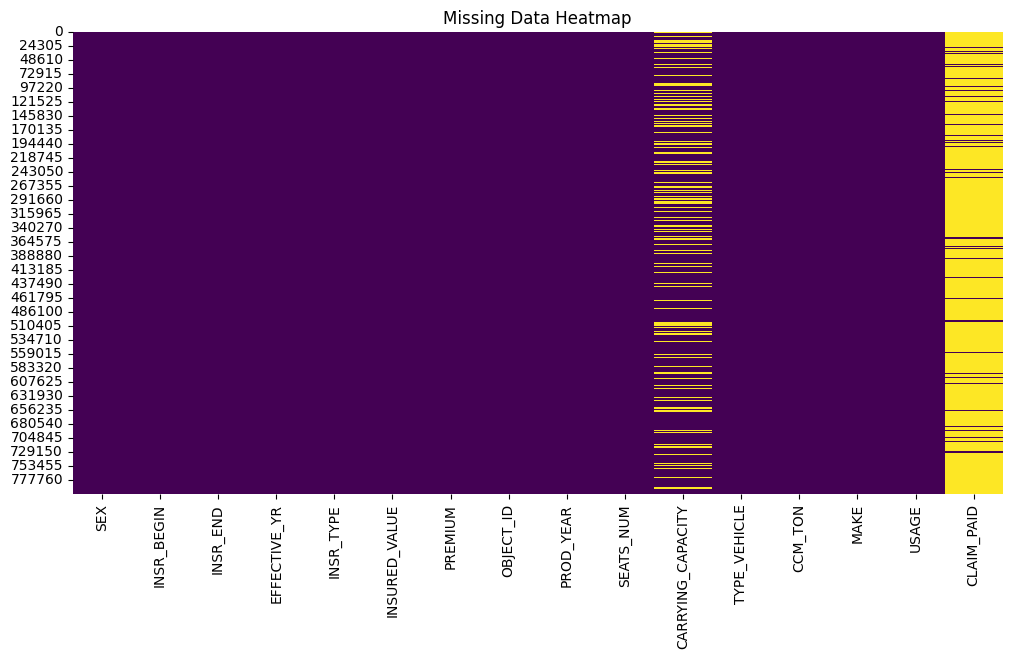

In [6]:
# Function to plot missing data heatmap
def plot_missing_data(data):
    plt.figure(figsize=(12, 6))
    sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Data Heatmap')
    plt.show()
plot_missing_data(df)

In [7]:
total_len = len(df)
print("Total records:", total_len)
Claim_paid_na = df["CLAIM_PAID"].isna().sum()
print("CLAIM_PAID is NaN:", Claim_paid_na, "records")
print("Percentage of NaN CLAIM_PAID:", (Claim_paid_na / total_len) * 100, "%")

Total records: 802036
CLAIM_PAID is NaN: 741891 records
Percentage of NaN CLAIM_PAID: 92.50096005665581 %


In [8]:
# Convert insurance date columns to datetime format
df["INSR_BEGIN"] = pd.to_datetime(df["INSR_BEGIN"], errors="coerce")
df["INSR_END"]   = pd.to_datetime(df["INSR_END"], errors="coerce")

# Filter the records where CLAIM_PAID is missing (NaN)
missing_claims = df[df["CLAIM_PAID"].isna()]

# Define "today" as one day after the latest insurance end date in the dataset
today = max(df['INSR_END']) + pd.Timedelta(days=1)
print("Today:", today)

# Count the number of missing claims where the policy has already expired
expired = missing_claims[missing_claims["INSR_END"] < today]
print("Expired but NaN Claim:", expired.shape[0])

# Count the number of missing claims where the policy is still active
active = missing_claims[missing_claims["INSR_END"] >= today]
print("Active but NaN Claim:", active.shape[0])

Today: 2019-06-30 00:00:00
Expired but NaN Claim: 741891
Active but NaN Claim: 0


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 🧹 مدیریت مقادیر گمشده در ستون خسارت (CLAIM_PAID)

- در دیتاست مشاهده شد که ستون **خسارت پرداختی (CLAIM_PAID)** برای حدود **۹۳٪ رکوردها مقدار خالی** دارد.  
- بررسی با استفاده از ستون **تاریخ پایان بیمه‌نامه (INSR_END)** نشان داد که همه‌ی این رکوردها مربوط به **بیمه‌نامه‌های منقضی‌شده** هستند.  
- بنابراین به‌جای حذف این رکوردها از دیتاست، مقادیر خالی باید به **عدد صفر** تغییر یابند؛ زیرا این وضعیت نشان‌دهنده‌ی **عدم وقوع خسارت** است.

---

### 🧹 Handling Missing Values in CLAIM_PAID

- It was observed that the **CLAIM_PAID** column had **missing values for about 93% of the records**.  
- By analyzing the **INSR_END** column, we found that all of these records belong to **expired policies**.  
- Therefore, instead of removing these records, the missing values should be **replaced with 0**, as they represent **no-claim policies**.

</div>


In [9]:
# Fill missing CLAIM_PAID with 0
df['CLAIM_PAID'].fillna(0 , inplace=True)
print("CLAIM_PAID NaN values filled with 0.")

CLAIM_PAID NaN values filled with 0.


In [10]:
# Check for duplicates
print("Number of duplicate records:", df.duplicated().sum())

Number of duplicate records: 198


In [11]:
# Remove duplicates if any
if df.duplicated().sum() > 0:
    print("Removing duplicate records...")
    df = df.drop_duplicates()
    print("Duplicate records removed.")


Removing duplicate records...
Duplicate records removed.


In [12]:

# Check for missing values in the 'MAKE' column

print("Missing values in 'MAKE' column:", df['MAKE'].isna().sum())
print(df['MAKE'].mode()[0])

# Fill missing values in 'MAKE' with 'mode'
df['MAKE'].fillna(df['MAKE'].mode()[0], inplace=True)
print("Missing values in 'MAKE' column filled with mode.")
print("Missing values in 'MAKE' column after filling:", df['MAKE'].isna().sum())



Missing values in 'MAKE' column: 5
TOYOTA
Missing values in 'MAKE' column filled with mode.
Missing values in 'MAKE' column after filling: 0


In [13]:

# Check for missing values in the 'CARRYING_CAPACITY' column

print("Missing values in 'CARRYING_CAPACITY' column:", df['CARRYING_CAPACITY'].isna().sum())
# Fill missing values in 'CARRYING_CAPACITY' with mean
df['CARRYING_CAPACITY'].fillna(df['CARRYING_CAPACITY'].mean(), inplace=True)
print("Missing values in 'CARRYING_CAPACITY' column filled with mean.")
print("Missing values in 'CARRYING_CAPACITY' column after filling:", df['CARRYING_CAPACITY'].isna().sum())


Missing values in 'CARRYING_CAPACITY' column: 198162
Missing values in 'CARRYING_CAPACITY' column filled with mean.
Missing values in 'CARRYING_CAPACITY' column after filling: 0


In [14]:

# Check for missing values in the 'CCM_TON' column

print("Missing values in 'CCM_TON' column:", df['CCM_TON'].isna().sum())
# Fill missing values in 'CCM_TON' with mean
df['CCM_TON'].fillna(df['CCM_TON'].mean(), inplace=True)
print("Missing values in 'CCM_TON' column filled with mean.")
print("Missing values in 'CCM_TON' column after filling:", df['CCM_TON'].isna().sum())

Missing values in 'CCM_TON' column: 8
Missing values in 'CCM_TON' column filled with mean.
Missing values in 'CCM_TON' column after filling: 0


In [15]:

# Check for missing values in the 'PREMIUM' column
print("Missing values in 'PREMIUM' column:", df['PREMIUM'].isna().sum())
if df['PREMIUM'].isna().sum() < 50:
    # Drop rows with missing PREMIUM values
    df.dropna(subset=['PREMIUM'], inplace=True)
print("Missing values in 'PREMIUM' column after dropping:", df['PREMIUM'].isna().sum())

Missing values in 'PREMIUM' column: 21


Missing values in 'PREMIUM' column after dropping: 0


In [16]:

# Check for missing values in the 'EFFECTIVE_YR' column
print("Missing values in 'EFFECTIVE_YR' column:", df['EFFECTIVE_YR'].isna().sum())
if df['EFFECTIVE_YR'].isna().sum() < 50:
    # Drop rows with missing EFFECTIVE_YR values
    df.dropna(subset=['EFFECTIVE_YR'], inplace=True)
print("Missing values in 'EFFECTIVE_YR' column after dropping:", df['EFFECTIVE_YR'].isna().sum())

Missing values in 'EFFECTIVE_YR' column: 4
Missing values in 'EFFECTIVE_YR' column after dropping: 0


In [17]:
# Create a new column 'CLAIM_FLAG' based on 'CLAIM_PAID'
# If CLAIM_PAID > 0, then CLAIM_FLAG = 1, else CLAIM_FLAG = 0
# df['CLAIM_FLAG'] = df['CLAIM_PAID'].apply(lambda x: 1 if x > 0 else 0)
threshold = 0
df["CLAIM_FLAG"] = (df["CLAIM_PAID"] > threshold).astype(int)

print(df["CLAIM_FLAG"].value_counts(normalize=True))

CLAIM_FLAG
0    0.92504
1    0.07496
Name: proportion, dtype: float64


<Axes: ylabel='CLAIM_PAID'>

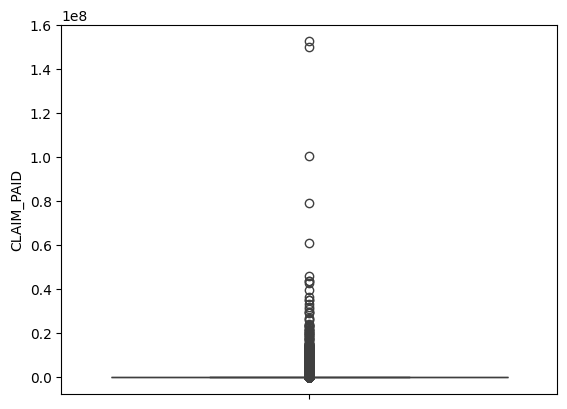

In [18]:
sns.boxplot(df['CLAIM_PAID'])

Numeric columns: ['SEX', 'INSR_TYPE', 'INSURED_VALUE', 'PREMIUM', 'OBJECT_ID', 'PROD_YEAR', 'SEATS_NUM', 'CARRYING_CAPACITY', 'CCM_TON', 'CLAIM_PAID', 'CLAIM_FLAG']
Categorical columns: ['EFFECTIVE_YR', 'TYPE_VEHICLE', 'MAKE', 'USAGE']


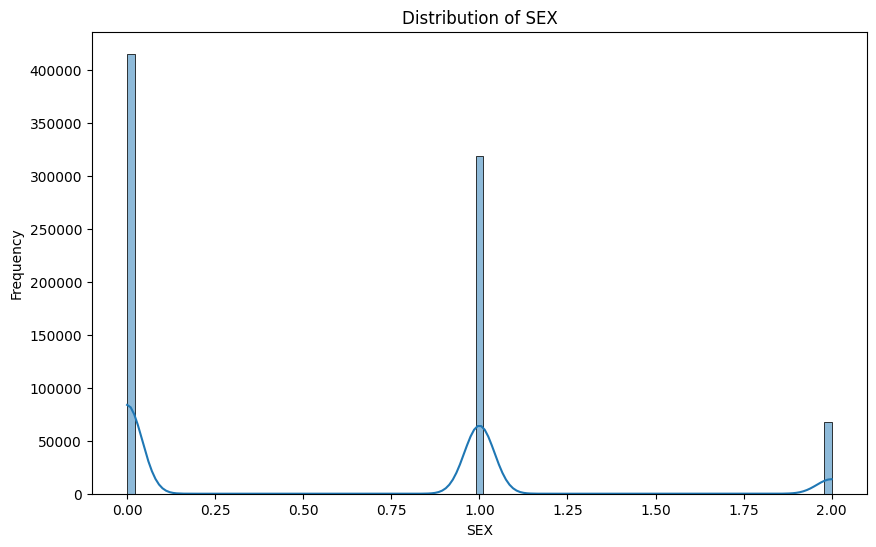

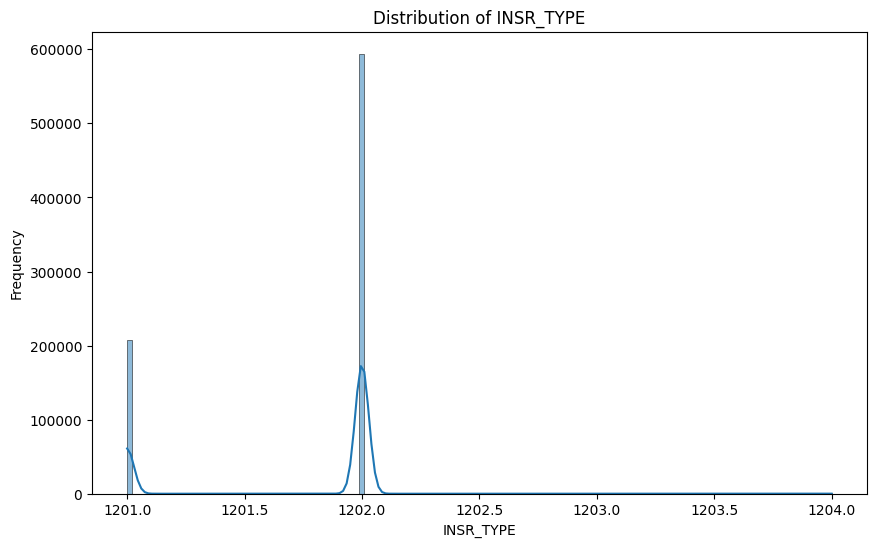

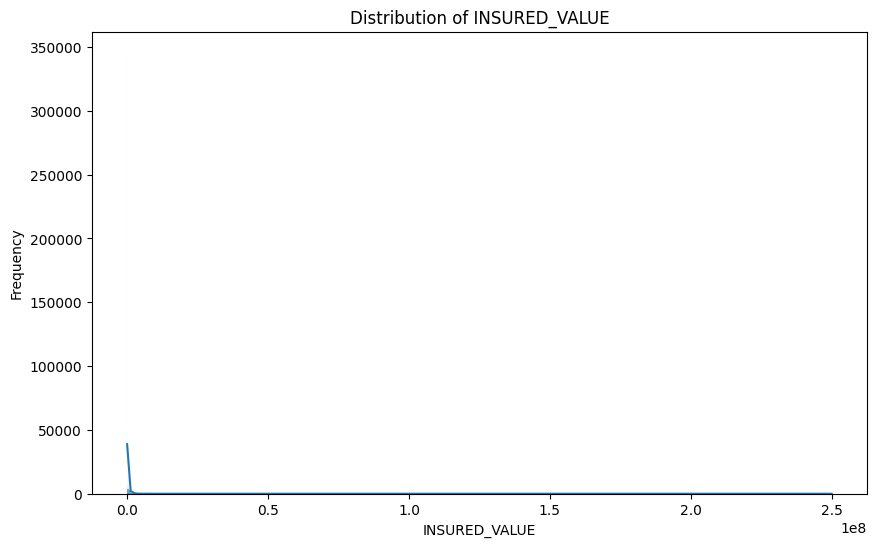

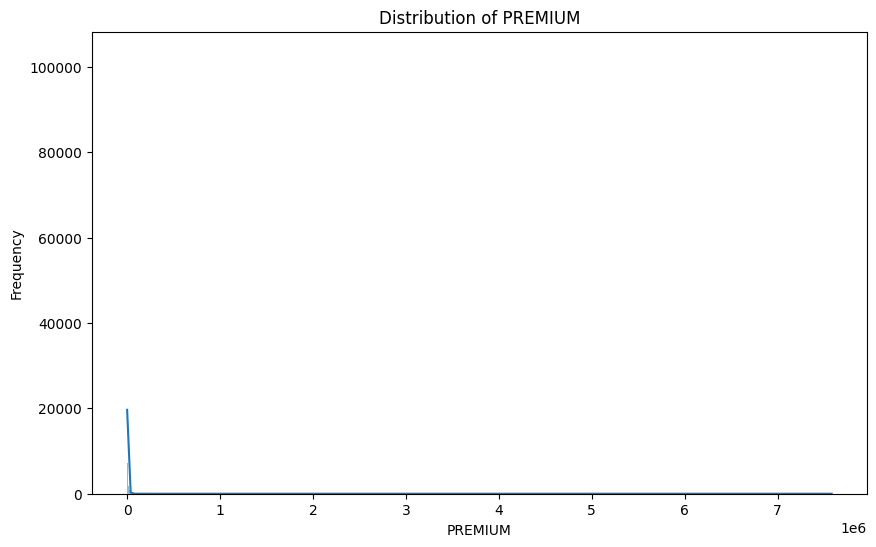

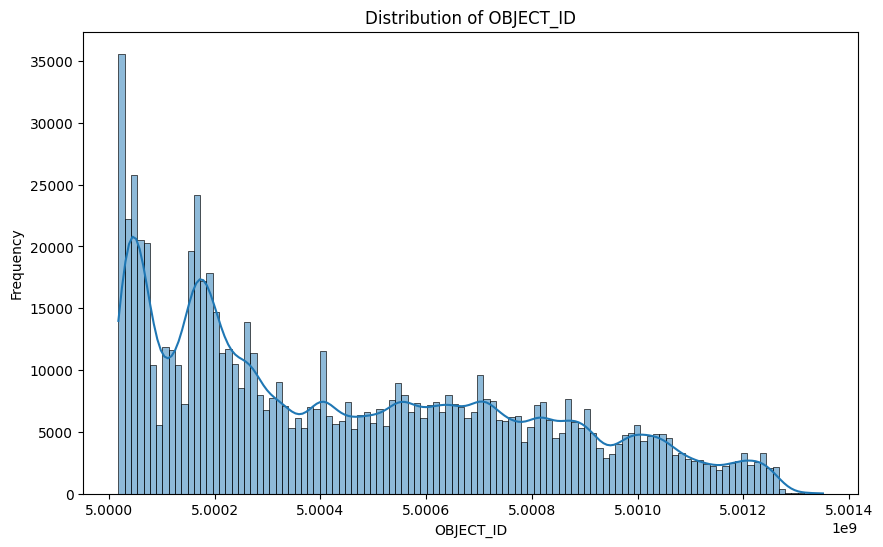

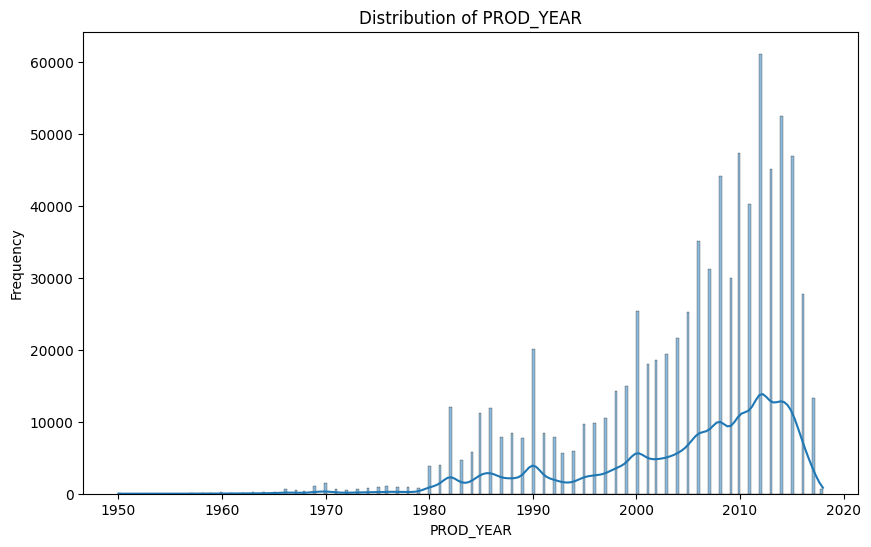

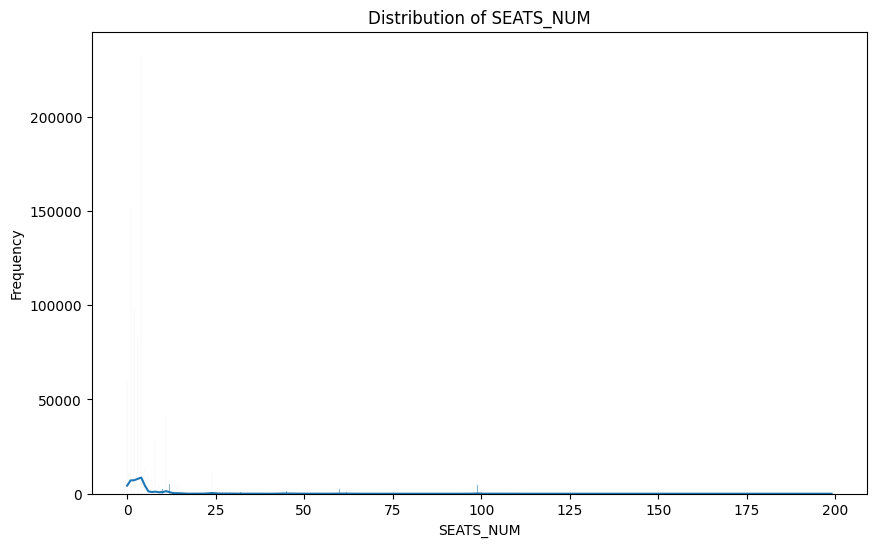

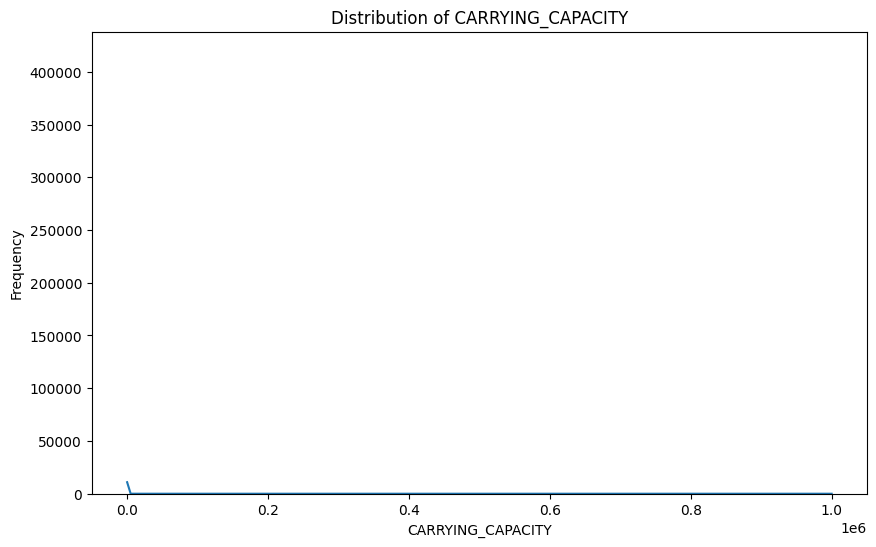

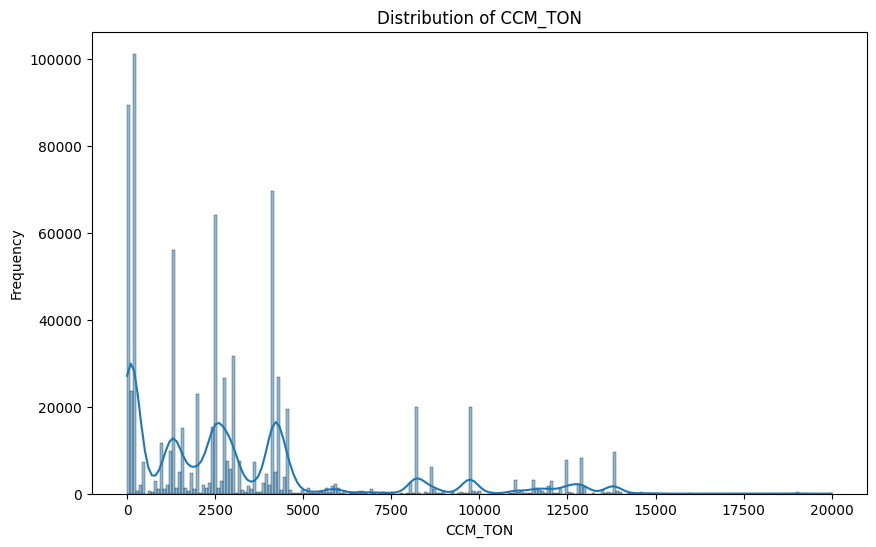

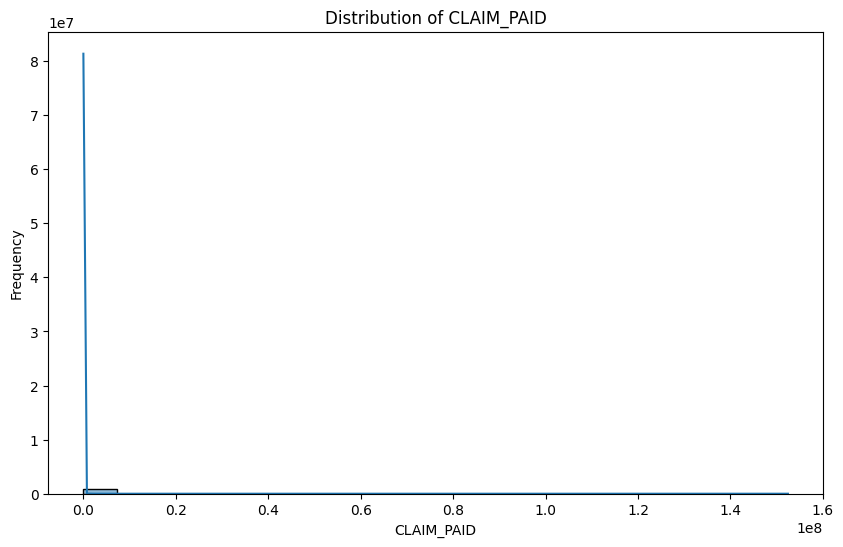

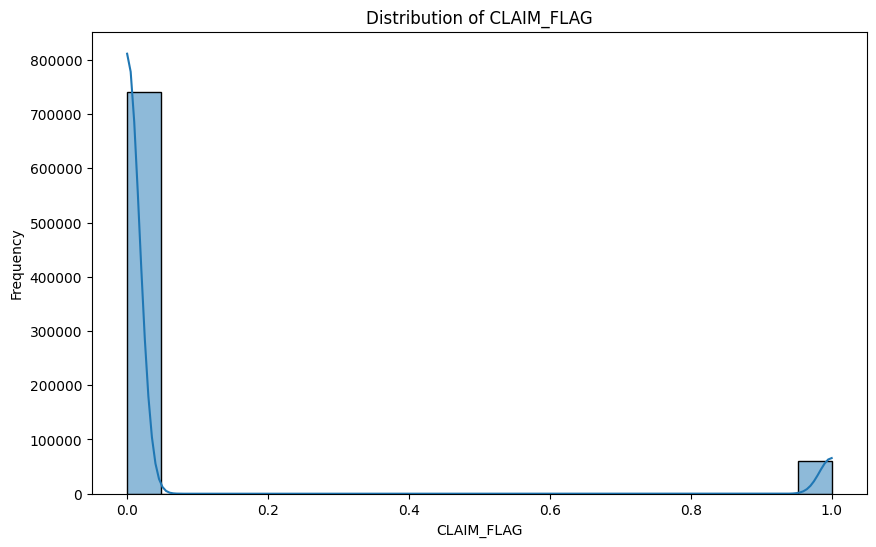

In [19]:
def numeric_columns(df):
    """
    Return a list of numeric columns in the DataFrame.
    """
    return [col for col in df.columns if df[col].dtype in [np.int64, np.float64]]

def categorical_columns(df):
    """
    Return a list of categorical columns in the DataFrame.
    """
    return [col for col in df.columns if df[col].dtype == 'object']

numeric_cols = numeric_columns(df)
print("Numeric columns:", numeric_cols)
categorical_cols = categorical_columns(df)
print("Categorical columns:", categorical_cols)

def plot_numeric_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
# Example usage of the plot_numeric_distribution function
if numeric_cols:
    for col in numeric_cols:

        plot_numeric_distribution(df, col)

In [20]:
# Check the unique values in column SEX
unique_values = df['SEX'].nunique()
print("Unique values in 'SEX':", unique_values)

# Count the occurrences of each unique value in the 'SEX' column
value_counts = df['SEX'].value_counts()
print("Value counts in 'SEX':\n", value_counts)

Unique values in 'SEX': 3
Value counts in 'SEX':
 SEX
0    415230
1    318522
2     68061
Name: count, dtype: int64


In [21]:
# Count records by SEX
print("Counts by SEX:\n", df["SEX"].value_counts(), "\n")

# Compare average premium & claims
sex_summary = df.groupby("SEX").agg({
    "PREMIUM": "mean",
    "INSURED_VALUE": "mean",
    "CLAIM_PAID": "mean",
    "CLAIM_FLAG": "mean"
}).rename(columns={"CLAIM_FLAG": "Claim_Rate"})

print("Summary by SEX:\n", sex_summary, "\n")

# Check usage distribution for SEX=2
usage_dist = df[df["SEX"]==2]["USAGE"].value_counts(normalize=True) * 100
print("Usage distribution for SEX=2:\n", usage_dist, "\n")

# Check top vehicle makes for SEX=2
make_dist = df[df["SEX"]==2]["MAKE"].value_counts().head(10)
print("Top 10 makes for SEX=2:\n", make_dist)


Counts by SEX:
 SEX
0    415230
1    318522
2     68061
Name: count, dtype: int64 

Summary by SEX:
          PREMIUM  INSURED_VALUE    CLAIM_PAID  Claim_Rate
SEX                                                      
0    8174.597631  705476.044389  14783.075231    0.091754
1    6722.092592  305633.814797  25166.990447    0.056071
2    5940.107961  264338.271273  18680.061504    0.060901 

Usage distribution for SEX=2:
 USAGE
Private                   33.790276
Fare Paying Passengers    23.608234
General Cartage           20.656470
Taxi                      12.969248
Own Goods                  4.786882
Others                     1.842465
Own service                1.022612
Car Hires                  0.556853
Learnes                    0.367318
Agricultural Any Farm      0.167497
Special Construction       0.163089
Agricultural Own Farm      0.061709
Ambulance                  0.007346
Name: proportion, dtype: float64 

Top 10 makes for SEX=2:
 MAKE
TOYOTA       27532
ISUZU         8819

In [22]:
# میانگین تعداد صندلی برای هر گروه
print("Average SEATS_NUM by SEX:")
print(df.groupby("SEX")["SEATS_NUM"].mean())

print("\nUsage distribution by SEX:")
# توزیع استفاده (USAGE) برای هر SEX
for sex in df["SEX"].unique():
    usage_dist = df[df["SEX"] == sex]["USAGE"].value_counts(normalize=True) * 100
    print(f"\nSEX={sex}")
    print(usage_dist.head(10))  # فقط 10 مورد اول برای خلاصه بودن


Average SEATS_NUM by SEX:
SEX
0    7.091811
1    5.043430
2    5.352341
Name: SEATS_NUM, dtype: float64

Usage distribution by SEX:

SEX=0
USAGE
Own Goods                 47.627821
Private                   27.950774
Own service               10.245888
General Cartage            6.400790
Fare Paying Passengers     2.477904
Agricultural Own Farm      1.792982
Special Construction       1.490740
Ambulance                  0.740313
Agricultural Any Farm      0.567878
Others                     0.243720
Name: proportion, dtype: float64

SEX=1
USAGE
Fare Paying Passengers    28.829406
General Cartage           26.633011
Private                   20.719448
Taxi                      11.823673
Own Goods                  5.811530
Own service                2.280847
Others                     2.100954
Learnes                    0.529006
Car Hires                  0.519273
Agricultural Any Farm      0.408135
Name: proportion, dtype: float64

SEX=2
USAGE
Private                   33.790276
Fare Pa

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 👥 تحلیل متغیر جنسیت (SEX)

- نرخ خسارت برای **مردان (SEX=0)** به‌طور معناداری بالاتر از **زنان (SEX=1)** است.  
  این موضوع با واقعیت‌های بیمه‌ای همخوانی دارد؛ زیرا مردان معمولاً بیشتر رانندگی می‌کنند، در مشاغل مرتبط با رانندگی حضور بیشتری دارند و رفتار رانندگی پرریسک‌تری نشان می‌دهند.  

- در نگاه اول هنگام بررسی ستون **SEX** متوجه حضور مقدار **۲** شدم که مشکوک به نظر می‌رسید، چراکه انتظار می‌رفت این متغیر فقط شامل مقادیر **۰=مرد** و **۱=زن** باشد.  
  فرض اولیه این بود که این داده‌ها مفقود یا خراب شده‌اند. اما پس از تحلیل دقیق‌تر (بررسی توزیع **USAGE** و نرخ خسارت)، مشخص شد که مقدار **۲ در واقع نمایانگر سازمان‌ها/شرکت‌ها** است و نه داده‌ی اشتباه. بنابراین این دسته‌بندی **معنادار و معتبر** بوده و باید در تحلیل‌ها لحاظ شود.  

---

### 👥 Gender Variable Analysis (SEX)

- The claim rate for **males (SEX=0)** is significantly higher than for **females (SEX=1)**.  
  This aligns with insurance industry observations, as men tend to drive more frequently, are more represented in driving-related occupations, and often exhibit riskier driving behavior compared to women.  

- At first glance, while exploring the **SEX** column, the presence of the value **2** seemed suspicious, since this variable is typically expected to contain only **0=Male** and **1=Female**.  
  My initial assumption was that it could represent missing or corrupted data. However, after deeper analysis (examining **USAGE distribution** and **CLAIM_RATE**), it became clear that **value 2 actually represents organizations/companies** rather than erroneous records. Hence, this category is **meaningful and valid** for further analysis.  

</div>


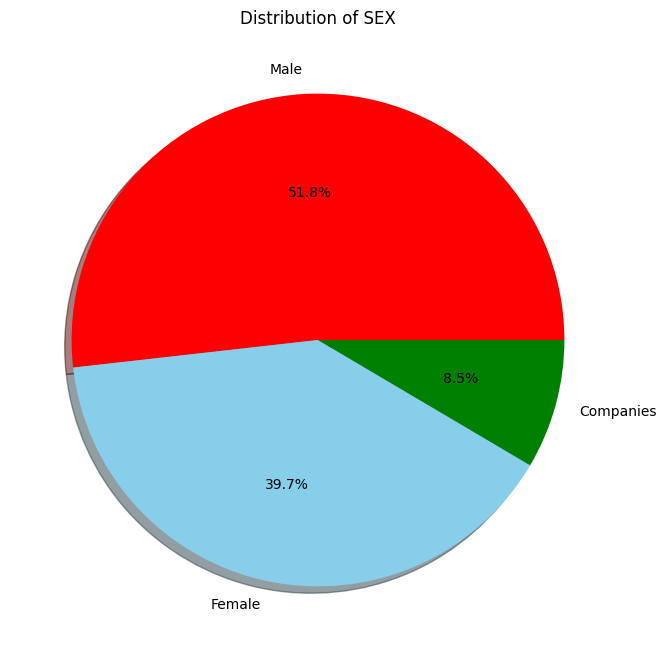

In [23]:
df['SEX'] = df['SEX'].map({0:'Male' , 1:'Female' , 2: 'Companies'})

sex_m = df[df['SEX'] == 'Male']['SEX'].count()
sex_f = df[df['SEX'] == 'Female']['SEX'].count()
sex_c = df[df['SEX'] == 'Companies']['SEX'].count()
plt.figure(figsize=(8, 8))
plt.pie(x=[sex_m, sex_f, sex_c], labels=['Male', 'Female', 'Companies'],colors= ['red' , 'skyblue','green'],radius=1, shadow=True, autopct="%1.1f%%")
plt.title("Distribution of SEX")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


👨 **مردها (Male):** بیشترین سهم رو دارن با حدود **51.8%** → یعنی بیشتر از نیمی از بیمه‌گذاران مرد هستن.  
👩 **زن‌ها (Female):** حدود **39.7%** → سهم بزرگی دارن ولی کمتر از مردها.  
🏢 **شرکت‌ها (Companies):** فقط **8.5%** → نشون میده سهم سازمانی/شرکتی خیلی کمتر از افراد حقیقیه.  

### 📌 نکات کلیدی (Insights):  
- بازار اصلی بیمه وسایل نقلیه در دست **افراد حقیقی (زن و مرد)** است، نه شرکت‌ها.  
- 👨 مردان بیشترین سهم رو دارن → احتمالاً به دلیل مالکیت بیشتر خودرو یا الگوهای استفاده.  
- 👩 زنان سهم قابل توجهی دارن (~40%) → یک بازار مهم و رو به رشد برای هدف‌گذاری بیمه.  
- 🏢 بخش شرکتی کوچک ولی با **پتانسیل رشد** (مثل بیمه‌های ناوگان حمل‌ونقل).  

</div>

---

👨 **Males:** Largest group with about **51.8%** → More than half of the insured clients are men.  
👩 **Females:** Around **39.7%** → A significant share but smaller than males.  
🏢 **Companies:** Only **8.5%** → Organizational customers represent a much smaller portion of the market.  

### 📌 Key Insights:  
- The insurance market is dominated by **individual customers (male & female)**, not companies.  
- 👨 Males form the majority → likely due to higher vehicle ownership or usage patterns.  
- 👩 Females are a strong segment (~40%) → showing **considerable market potential**.  
- 🏢 Corporate clients are underrepresented but could be a **growth opportunity**, especially for fleet/business insurance packages.  


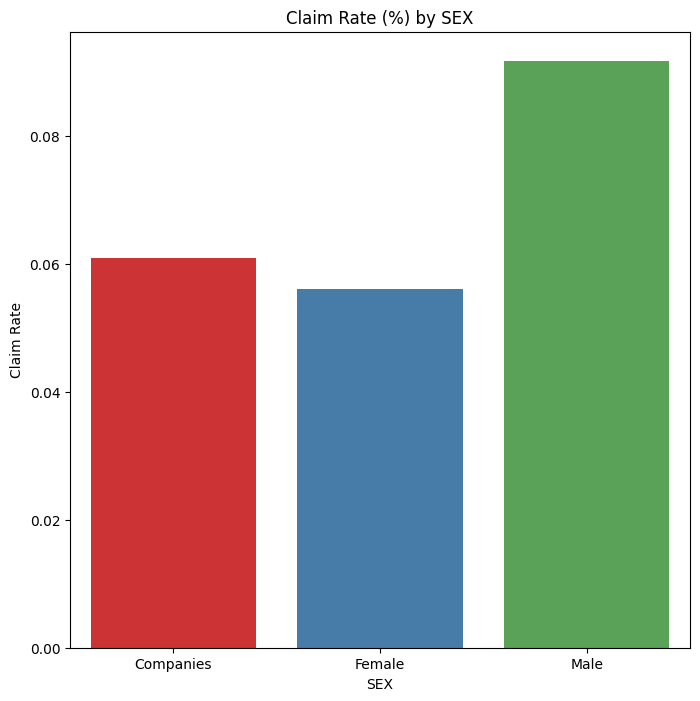

In [24]:
claim_rate = df.groupby('SEX')['CLAIM_FLAG'].mean().reset_index()

plt.figure(figsize=(8,8))
sns.barplot(x='SEX', y='CLAIM_FLAG', data=claim_rate, palette='Set1')
plt.title("Claim Rate (%) by SEX")
plt.ylabel("Claim Rate")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


👨 **مردان (Male):** بیشترین نرخ خسارت با حدود %9+ → نشان‌دهنده **ریسک بالاتر** برای شرکت بیمه.  

👩 **زنان (Female):** کمترین نرخ خسارت با حدود %5.5 → مشتریانی با **سودآوری بیشتر** برای بیمه‌گر.  

🏢 **شرکت‌ها (Companies):** نرخ خسارت متوسط حدود %6 → با وجود سهم بازار کوچک، می‌توانند بازار **پایدار و قابل توسعه** باشند.  

✨ **این یعنی:**  
- 👨 مردان → بیشترین سهم + بیشترین خسارت → نیاز به **مدیریت ریسک** و شاید **تعرفه‌های بالاتر**.  
- 👩 زنان → سهم قابل توجه + خسارت کمتر → فرصت عالی برای طراحی **طرح‌های تشویقی و تخفیفی**.  
- 🏢 شرکت‌ها → سهم کوچک + ریسک متوسط → پتانسیل رشد در **بیمه‌های سازمانی و ناوگان**.  

</div>

---


👨 **Males:** Highest claim rate (9%+) → Represent the **riskiest group** for insurers.  

👩 **Females:** Lowest claim rate (~5.5%) → A **profitable and attractive** customer segment.  

🏢 **Companies:** Moderate claim rate (~6%) → Though small in share, they offer **stable future potential**, especially in fleet insurance.  

✨ **This means:**  
- 👨 Males → High share + High claims → Require **risk-based pricing** or stricter underwriting.  
- 👩 Females → Significant share + Low claims → Great opportunity for **discounts & loyalty programs**.  
- 🏢 Companies → Small share + Medium risk → Potential growth in **corporate packages**.  


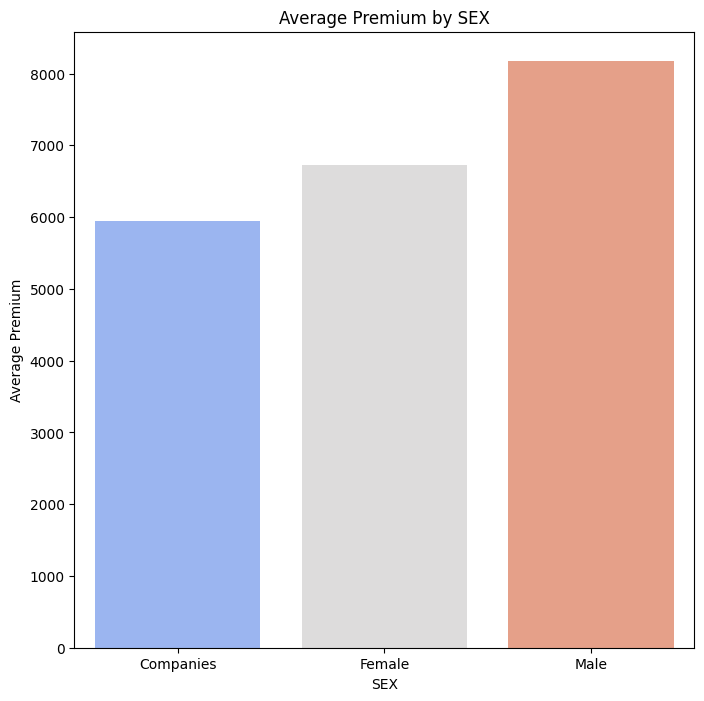

In [25]:
premium_by_sex = df.groupby('SEX')['PREMIUM'].mean().reset_index()

plt.figure(figsize=(8,8))
sns.barplot(x='SEX', y='PREMIUM', data=premium_by_sex, palette='coolwarm')
plt.title("Average Premium by SEX")
plt.ylabel("Average Premium")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">
 

👨 **مردان (Male):** بالاترین میانگین حق‌بیمه، حدود **8200** → نشان‌دهنده ریسک بالاتر یا استفاده بیشتر از خدمات بیمه‌ای.  

👩 **زنان (Female):** میانگین حق‌بیمه حدود **6700** → کمتر از مردان ولی بیشتر از شرکت‌ها.  

🏢 **شرکت‌ها (Companies):** پایین‌ترین میانگین حق‌بیمه، حدود **6000** → سهم کوچک و ریسک متوسط.  

### 📌 نکات کلیدی (Insights):  
- 👨 مردان با وجود بیشترین خسارت (نمودار قبلی)، بالاترین حق‌بیمه رو هم پرداخت می‌کنن → این موضوع با **مدل قیمت‌گذاری ریسک‌محور** سازگاره.  
- 👩 زنان با نرخ خسارت کمتر و حق‌بیمه متوسط → **سودآورترین گروه** برای شرکت بیمه.  
- 🏢 شرکت‌ها حق‌بیمه پایین‌تری پرداخت می‌کنن → احتمالاً به خاطر قراردادهای گروهی یا تخفیف‌های سازمانی.  

</div>

---



👨 **Males:** Highest average premium (~8200) → Indicates higher risk or higher insurance usage.  

👩 **Females:** Medium premium (~6700) → Lower than males but higher than companies.  

🏢 **Companies:** Lowest average premium (~6000) → Possibly due to bulk contracts or organizational discounts.  

### 📌 Key Insights:  
- 👨 Males pay the highest premiums, aligned with their **higher claim rates** (previous chart).  
- 👩 Females show **lower risk + medium premiums**, making them the **most profitable group**.  
- 🏢 Companies pay the least, likely benefiting from **corporate discounts or fleet packages**.  


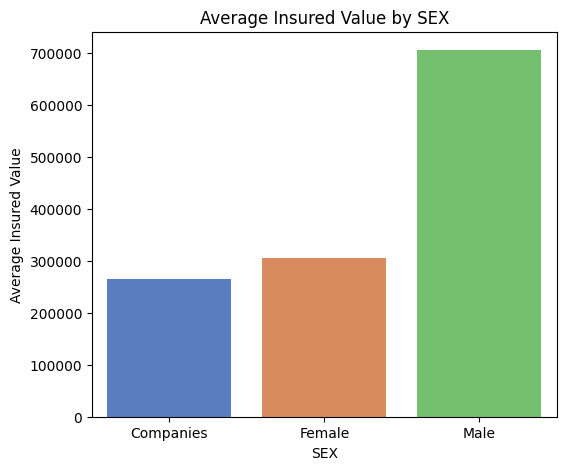

In [26]:
insured_value_by_sex = df.groupby('SEX')['INSURED_VALUE'].mean().reset_index()

plt.figure(figsize=(6,5))
sns.barplot(x='SEX', y='INSURED_VALUE', data=insured_value_by_sex, palette='muted')
plt.title("Average Insured Value by SEX")
plt.ylabel("Average Insured Value")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


👨 **مردان (Male):** بالاترین میانگین ارزش بیمه‌شده با حدود **700,000+** → یعنی خودروها یا دارایی‌های تحت پوشش مردان معمولاً **ارزشمندتر** هستند.  

👩 **زنان (Female):** میانگین ارزش بیمه‌شده حدود **310,000** → کمتر از مردان اما بیشتر از شرکت‌ها.  

🏢 **شرکت‌ها (Companies):** کمترین میانگین ارزش بیمه‌شده، حدود **270,000** → نشان‌دهنده این که اغلب دارایی‌های بیمه‌شده توسط شرکت‌ها **کم‌ارزش‌تر یا اقتصادی‌تر** هستند.  

### 📌 نکات کلیدی (Insights):  
- 👨 مردان علاوه بر بیشترین سهم بازار، خودروهایی با ارزش بالاتر دارند → ریسک بیمه‌گر در این گروه **سنگین‌تر** است.  
- 👩 زنان با ارزش بیمه‌شده متوسط و نرخ خسارت پایین (نمودار قبل) → گروهی **کم‌ریسک و سودآور** محسوب می‌شوند.  
- 🏢 شرکت‌ها با پایین‌ترین ارزش بیمه‌شده → احتمالاً بیشتر در بخش خودروهای خدماتی یا اقتصادی حضور دارند.  

</div>

---


👨 **Males:** Highest average insured value (~700,000+) → Men typically insure **more valuable assets/vehicles**.  

👩 **Females:** Medium insured value (~310,000) → Less than males but higher than companies.  

🏢 **Companies:** Lowest insured value (~270,000) → Suggests that corporate-insured vehicles are mostly **economical or utilitarian**.  

### 📌 Key Insights:  
- 👨 Males own higher-value vehicles → leading to **greater risk exposure** for insurers.  
- 👩 Females show **moderate insured values + low claim rates**, making them a **profitable and stable segment**.  
- 🏢 Companies insure lower-value vehicles → likely focusing on **fleet or service cars**.  


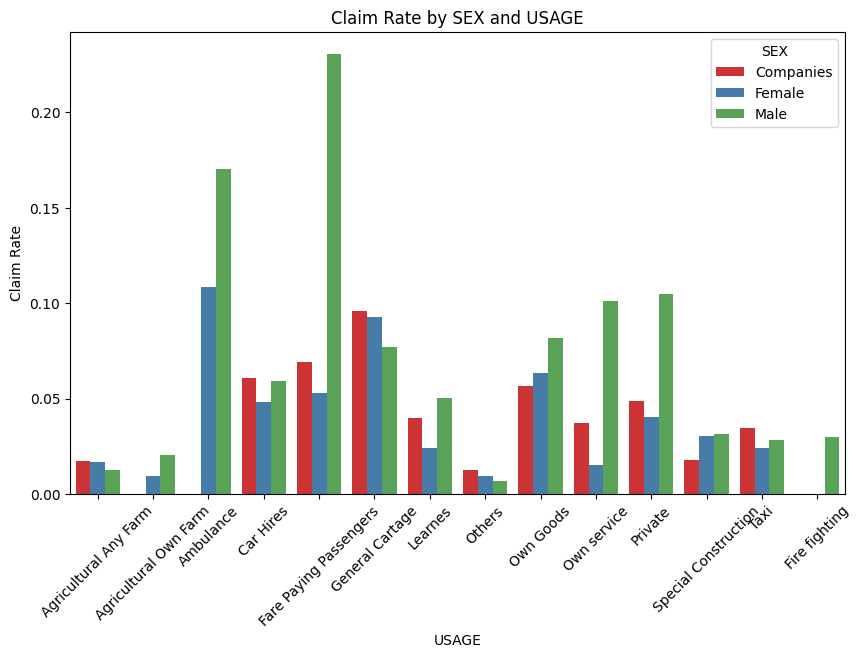

In [27]:
cross = df.groupby(['SEX','USAGE'])['CLAIM_FLAG'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='USAGE', y='CLAIM_FLAG', hue='SEX', data=cross, palette='Set1')
plt.title("Claim Rate by SEX and USAGE")
plt.xticks(rotation=45)
plt.ylabel("Claim Rate")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


📊 مشاهده‌ها:  
- 👨 **مردان (Male):** در اکثر کاربری‌ها نرخ خسارت بالاتری نسبت به زنان و شرکت‌ها دارند. به‌خصوص در:  
  - 🚕 **Fare Paying Passengers (مسافربرها):** بیشترین نرخ خسارت (بیش از 20%).  
  - 🚚 **Agricultural Own Farm** و **Own Goods** → نرخ خسارت چشمگیر بالاتر.  
- 👩 **زنان (Female):** در بیشتر دسته‌ها نرخ خسارت پایین‌تر از مردان دارند، اما در برخی مثل **Ambulance** نزدیک به شرکت‌ها هستند.  
- 🏢 **شرکت‌ها (Companies):** معمولاً نرخ خسارتشان بین مردان و زنان است، اما در بعضی کاربری‌ها مثل **Car Hires** یا **General Cartage** کمی بالاتر ظاهر می‌شوند.  

✨ **این یعنی:**  
- 👨 مردان در کاربری‌های پرریسک (مسافربری، کشاورزی شخصی، حمل بار شخصی) **ریسک بیشتری** برای بیمه‌گر ایجاد می‌کنند.  
- 👩 زنان همچنان **ریسک کمتر** دارند و برای شرکت بیمه گروهی **ایمن‌تر و سودآورتر** هستند.  
- 🏢 شرکت‌ها با نرخ خسارت متوسط می‌توانند بازار **باثبات‌تری** نسبت به افراد حقیقی پرریسک باشند.  

</div>

---



📊 Observations:  
- 👨 **Males:** Generally higher claim rates across most usage categories. Especially in:  
  - 🚕 **Fare Paying Passengers:** Extremely high (~20%+).  
  - 🚚 **Agricultural Own Farm** and **Own Goods** → noticeable higher risks.  
- 👩 **Females:** Typically show **lower claim rates**, but in categories like **Ambulance** they are close to companies.  
- 🏢 **Companies:** Usually in the middle, but in some categories (e.g., **Car Hires**, **General Cartage**) they are relatively higher.  

✨ **This means:**  
- 👨 Males dominate the **high-risk usages** (passenger transport, own farm/agriculture, own goods transport).  
- 👩 Females remain **lower-risk**, offering a **safer portfolio** for insurers.  
- 🏢 Companies show **moderate risk**, making them a **stable and balanced segment** compared to individual high-risk drivers.  


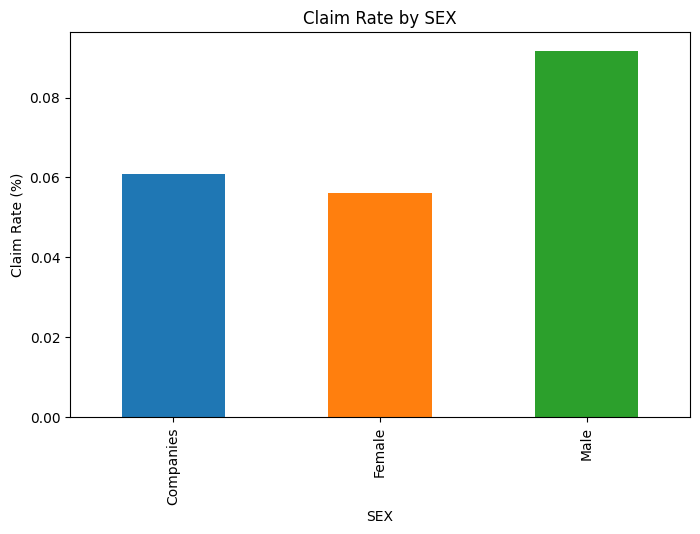

In [28]:
claim_rate = df.groupby('SEX')['CLAIM_FLAG'].mean()

claim_rate.plot(kind='bar', figsize=(8,5), color=['#1f77b4','#ff7f0e','#2ca02c'])
plt.title("Claim Rate by SEX")
plt.ylabel("Claim Rate (%)")
plt.xlabel("SEX")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

 

👨 **مردان (Male):** بالاترین نرخ خسارت، حدود **9%** → نشان‌دهنده **ریسک بالاتر** و نیازمند توجه ویژه در قیمت‌گذاری بیمه.  

👩 **زنان (Female):** کمترین نرخ خسارت، حدود **5.5%** → مشتریانی **ایمن‌تر و سودآورتر** برای شرکت بیمه.  

🏢 **شرکت‌ها (Companies):** نرخ خسارت متوسط، حدود **6%** → گروهی متعادل که می‌توانند بازار **پایدار** ایجاد کنند.  

### 📌 نکات کلیدی (Insights):  
- 👨 مردان → بیشترین خسارت → نیاز به **مدیریت ریسک و تعرفه‌های متناسب**.  
- 👩 زنان → سهم بزرگ + خسارت کمتر → بهترین گزینه برای **طرح‌های تشویقی و وفاداری**.  
- 🏢 شرکت‌ها → نرخ متوسط → مناسب برای **بیمه‌های سازمانی و ناوگان**.  

</div>

---



👨 **Males:** Highest claim rate (~9%) → Represent the **riskiest group**, requiring stricter underwriting.  

👩 **Females:** Lowest claim rate (~5.5%) → **Profitable and safer** customers for insurers.  

🏢 **Companies:** Moderate claim rate (~6%) → Provide a **balanced and stable** market segment.  

### 📌 Key Insights:  
- 👨 Males → Higher claims → Need **risk-adjusted pricing**.  
- 👩 Females → Significant share + Lower claims → Best suited for **discounts and loyalty programs**.  
- 🏢 Companies → Medium risk → Potential for **corporate and fleet insurance expansion**.  


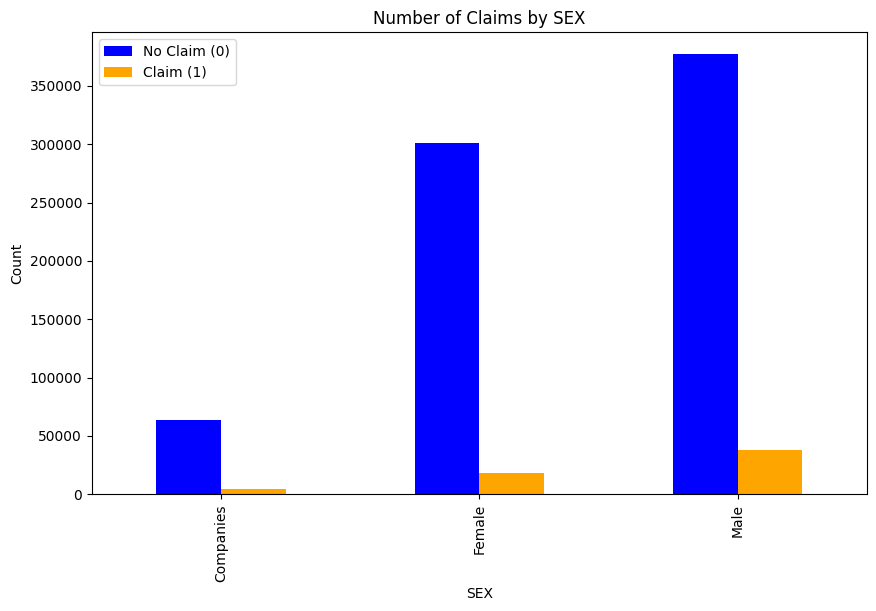

In [29]:
claim_counts = df.groupby(['SEX', 'CLAIM_FLAG']).size().unstack()

claim_counts.plot(kind='bar', figsize=(10,6), color=['blue', 'orange'])

plt.title("Number of Claims by SEX")
plt.xlabel("SEX")
plt.ylabel("Count")
plt.legend(["No Claim (0)", "Claim (1)"])
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


📊 مشاهده‌ها:  
- 👨 **مردان (Male):** بیشترین تعداد خسارت ثبت‌شده رو دارن (بیش از **40,000 Claim**).  
- 👩 **زنان (Female):** تعداد خسارت کمتر از مردان (حدود **20,000 Claim**)، در حالی که تعداد بیمه‌نامه‌هاشون بالاست.  
- 🏢 **شرکت‌ها (Companies):** کمترین تعداد خسارت (چند هزار Claim)، هم‌راستا با سهم بازار کوچکشان.  

### 📌 نکات کلیدی (Insights):  
- 👨 مردان نه‌تنها بالاترین نرخ خسارت رو دارن (نمودار قبلی)، بلکه **بیشترین تعداد خسارت مطلق** رو هم ثبت می‌کنن → فشار مالی اصلی روی شرکت بیمه.  
- 👩 زنان با تعداد خسارت کمتر و نرخ پایین‌تر → گروهی **سودآور و کم‌ریسک** هستند.  
- 🏢 شرکت‌ها خسارت‌های کمتری دارن → با توجه به حجم کم بازار، ریسک این بخش نسبتاً پایین‌تره.  

</div>

---


📊 Observations:  
- 👨 **Males:** Record the highest number of claims (**40,000+**), making them the **largest risk contributor**.  
- 👩 **Females:** Fewer claims (~20,000) despite having a large insured base → safer and more profitable segment.  
- 🏢 **Companies:** Very few claims (a few thousand), aligned with their small share of the market.  

### 📌 Key Insights:  
- 👨 Males → Highest claim rate + Highest claim volume → **major financial burden** for insurers.  
- 👩 Females → Lower rate + Fewer claims → **most profitable group**.  
- 🏢 Companies → Small volume + Few claims → **low-risk but limited potential** segment.  


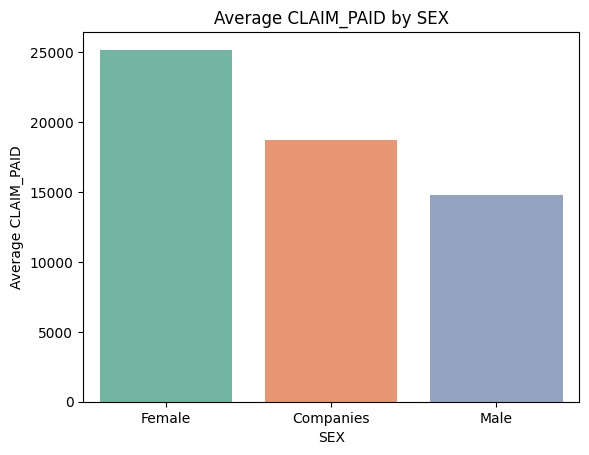

In [30]:
Claim_paid = df.groupby('SEX')['CLAIM_PAID'].mean().reset_index().sort_values(by='CLAIM_PAID', ascending=False)
sns.barplot(data=Claim_paid, x='SEX', y='CLAIM_PAID', palette='Set2')
plt.title('Average CLAIM_PAID by SEX')
plt.ylabel('Average CLAIM_PAID')
plt.xlabel('SEX')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



👩 **زنان (Female):** بالاترین میانگین خسارت پرداختی، حدود **25,000** → یعنی هر بار خسارت در این گروه معمولاً **مبلغ بالاتری** داشته.  

🏢 **شرکت‌ها (Companies):** میانگین خسارت پرداختی حدود **19,000** → در سطح متوسط.  

👨 **مردان (Male):** پایین‌ترین میانگین خسارت پرداختی، حدود **15,000** → خسارت‌هایشان به طور میانگین **کم‌هزینه‌تر** بوده.  

### 📌 نکات کلیدی (Insights):  
- 👩 با اینکه زنان نرخ خسارت پایین‌تری دارند (نمودارهای قبلی)، ولی وقتی خسارت اتفاق می‌افتد، **مبلغ پرداختی بیشتر** است.  
- 👨 مردان خسارت‌های بیشتری دارند اما مبلغ هر خسارت معمولاً کمتر است → فشار بیمه‌گر بیشتر از حجم زیاد خسارت‌هاست نه مبلغ هر کدام.  
- 🏢 شرکت‌ها در وسط قرار دارند → هم از نظر نرخ و هم مبلغ خسارت، گروهی متعادل محسوب می‌شوند.  

</div>

---
 

👩 **Females:** Highest average claim paid (~25,000) → Each claim tends to be **more expensive**.  

🏢 **Companies:** Moderate average claim paid (~19,000).  

👨 **Males:** Lowest average claim paid (~15,000) → Individual claims are **cheaper**, but occur more frequently.  

### 📌 Key Insights:  
- 👩 Females → Fewer claims, but when they happen, they **cost more**.  
- 👨 Males → More frequent claims, but each one is **lower in value**.  
- 🏢 Companies → Balanced position, with **moderate claim costs**.  


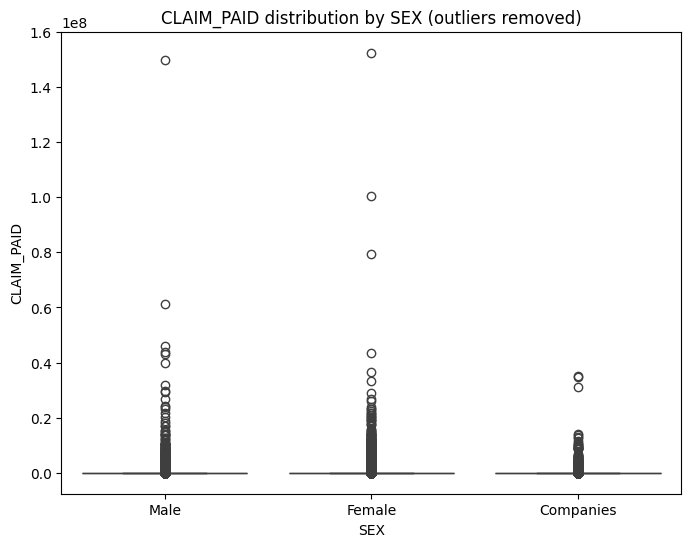

In [31]:
plt.figure(figsize=(8,6))
sns.boxplot(x='SEX', y='CLAIM_PAID', data=df, showfliers=True)  
plt.title("CLAIM_PAID distribution by SEX (outliers removed)")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

 

📊 مشاهده‌ها:  
- 👨 **مردان (Male):** گستره‌ی خسارت‌ها نسبتاً وسیع است، با موارد متعددی در محدوده بالا (ولی کمتر از زنان).  
- 👩 **زنان (Female):** توزیع خسارت‌ها پهن‌تر و پراکندگی بیشتر دارد → نشان می‌دهد که در بین زنان، وقتی خسارت رخ می‌دهد، احتمال پرداخت‌های بسیار بالا وجود دارد.  
- 🏢 **شرکت‌ها (Companies):** دامنه خسارت‌ها محدودتر است و پراکندگی بسیار کمتر از افراد حقیقی → نشان‌دهنده‌ی **ریسک پایین‌تر در تنوع مبلغ خسارت‌ها**.  

### 📌 نکات کلیدی (Insights):  
- 👨 مردان خسارت‌های پرتعداد ولی با مبالغ معمولاً کمتر دارند.  
- 👩 زنان خسارت‌های کمتری دارند، اما وقتی خسارت اتفاق می‌افتد، **ریسک خسارت‌های بسیار بزرگ‌تر** بالاست.  
- 🏢 شرکت‌ها خسارت‌های یکنواخت‌تر دارند، بدون شوک‌های خیلی بزرگ، و از این نظر برای بیمه‌گر **قابل پیش‌بینی‌تر** هستند.  

</div>

---



📊 Observations:  
- 👨 **Males:** Wide range of claims, but extreme high values are less common compared to females.  
- 👩 **Females:** Show a broader distribution with higher outliers → when claims occur, they can sometimes be **very costly**.  
- 🏢 **Companies:** Narrower distribution with lower variability → **more predictable** claim costs.  

### 📌 Key Insights:  
- 👨 Males → Many claims, but typically smaller amounts.  
- 👩 Females → Fewer claims, but **potential for very high payouts**.  
- 🏢 Companies → Consistent and more **stable claim distributions**.  


In [32]:
# Remove outliers using IQR
Q1 = df['CLAIM_PAID'].quantile(0.25)
Q3 = df['CLAIM_PAID'].quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = df[(df['CLAIM_PAID'] >= Q1 - 1.5 * IQR) & (df['CLAIM_PAID'] <= Q3 + 1.5 * IQR)]

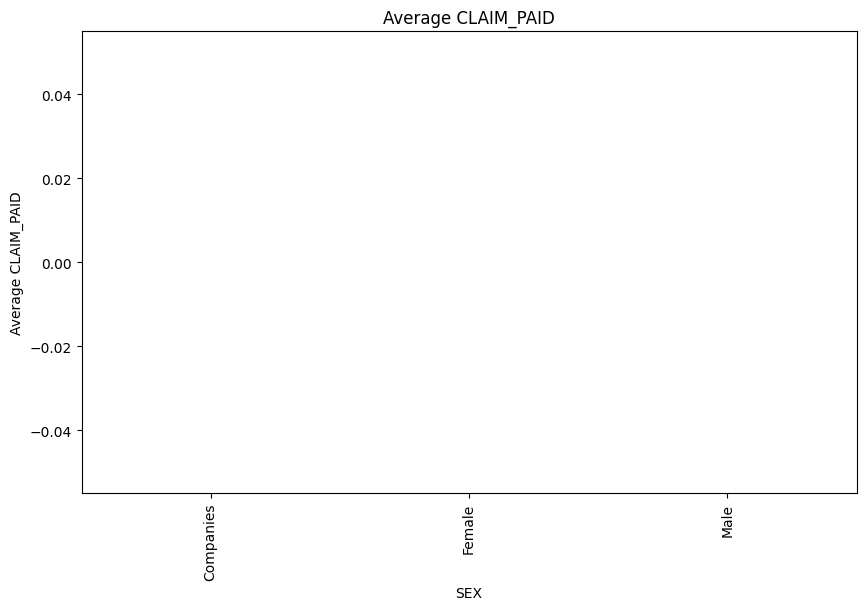

In [33]:
df_no_outliers.groupby('SEX')['CLAIM_PAID'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title("Average CLAIM_PAID")
plt.xlabel("SEX")
plt.ylabel("Average CLAIM_PAID")
plt.show()

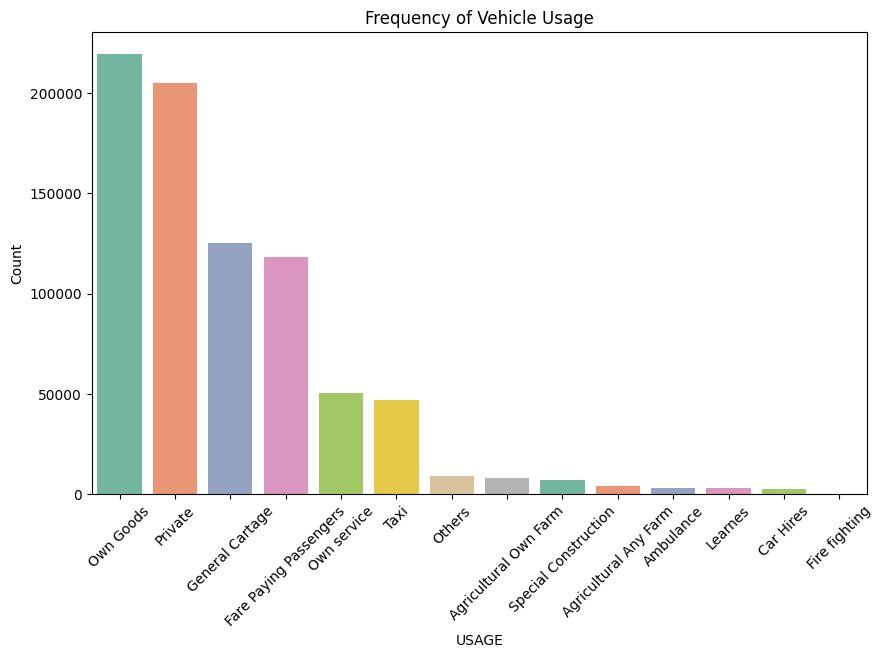

In [34]:
plt.figure(figsize=(10,6))
sns.countplot(x="USAGE", data=df, order=df["USAGE"].value_counts().index, palette="Set2")
plt.title("Frequency of Vehicle Usage")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



📊 مشاهده‌ها:  
- 🚚 **Own Goods (حمل کالای شخصی):** بیشترین سهم (بیش از 220,000 وسیله نقلیه).  
- 🚗 **Private (شخصی):** دومین رتبه با بیش از 200,000 وسیله.  
- 🚛 **General Cartage (حمل بار عمومی):** سومین رتبه با حدود 125,000 وسیله.  
- 🚌 **Fare Paying Passengers (مسافربری):** سهم قابل توجه، کمی کمتر از 120,000.  
- 🚕 **Taxi:** رتبه بعدی، حدود 50,000 وسیله.  
- ⚙️ سایر دسته‌ها (مانند **کشاورزی، ساخت‌وساز ویژه، آمبولانس، اجاره‌ای، آتش‌نشانی**) سهم خیلی کمتری دارند.  

### 📌 نکات کلیدی (Insights):  
- بازار بیمه وسایل نقلیه به شدت تحت تأثیر **خودروهای شخصی و باری (Own Goods + Private)** است → این دو دسته بیش از **نیمی از کل بازار** را تشکیل می‌دهند.  
- **وسایل نقلیه عمومی (General Cartage + Fare Paying Passengers + Taxi)** سهم قابل توجهی دارند و به دلیل ریسک بالاتر باید در **مدل قیمت‌گذاری دقیق‌تر** لحاظ شوند.  
- دسته‌های کوچک‌تر (کشاورزی، خدمات ویژه و غیره) حجم کمی دارند، اما می‌توانند فرصت‌های **بازاریابی تخصصی** ایجاد کنند.  

</div>

---

 

📊 Observations:  
- 🚚 **Own Goods:** Largest segment (>220,000 vehicles).  
- 🚗 **Private:** Second largest (>200,000).  
- 🚛 **General Cartage:** Third (~125,000).  
- 🚌 **Fare Paying Passengers:** Significant (~115,000).  
- 🚕 **Taxi:** Moderate (~50,000).  
- ⚙️ Other categories (Agriculture, Special Construction, Ambulance, Hires, Firefighting) → very small share.  

### 📌 Key Insights:  
- The insurance market is dominated by **Own Goods + Private vehicles**, together forming **over half the market**.  
- **Public/commercial vehicles (General Cartage, Fare Paying, Taxi)** are important high-risk groups requiring **risk-based premium strategies**.  
- Smaller categories, though limited in volume, represent **niche opportunities** for tailored insurance products.  


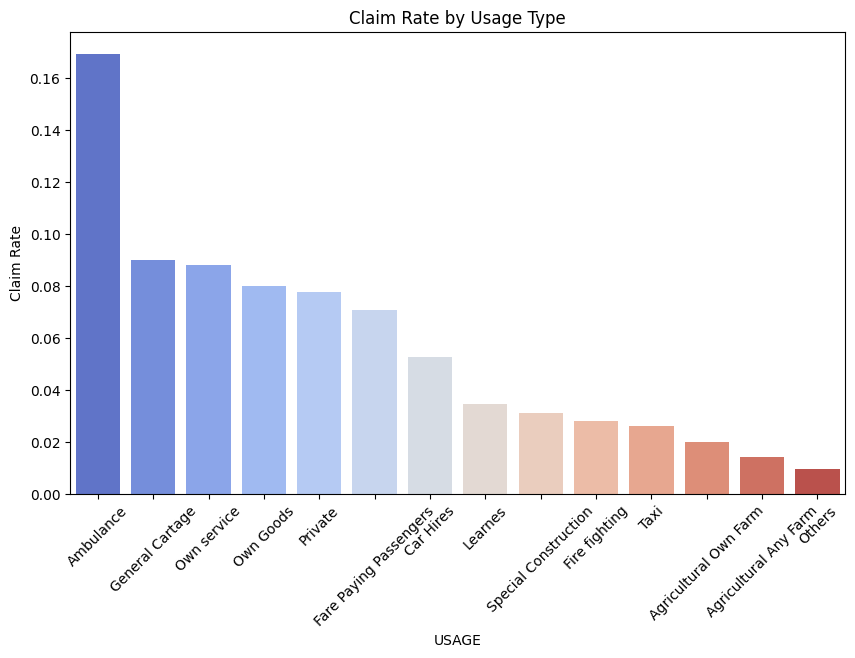

In [35]:
claim_rate_usage = df.groupby("USAGE")["CLAIM_FLAG"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x="USAGE", y="CLAIM_FLAG", data=claim_rate_usage, order=claim_rate_usage.sort_values("CLAIM_FLAG", ascending=False)["USAGE"], palette="coolwarm")
plt.title("Claim Rate by Usage Type")
plt.ylabel("Claim Rate")
plt.xticks(rotation=45)
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



📊 مشاهده‌ها:  
- 🚑 **Ambulance (آمبولانس):** بالاترین نرخ خسارت با حدود **17%**.  
- 🚛 **General Cartage (حمل بار عمومی):** نرخ نسبتاً بالا، حدود **9%**.  
- ⚙️ **Own Service / Own Goods:** نرخ خسارت بالاتر از میانگین (~8–9%).  
- 🚗 **Private (شخصی):** کمی کمتر از متوسط (~7%).  
- 🚌 **Fare Paying Passengers:** نرخ خسارت پایین‌تر (~5%).  
- 🚕 **Taxi** و دسته‌های **کشاورزی** (Agricultural) → کمترین نرخ خسارت (~2–3%).  
- 🔥 **Fire Fighting** و **Special Construction:** نزدیک به میانگین پایین (~3–4%).  

### 📌 نکات کلیدی (Insights):  
- 🚑 **آمبولانس‌ها پرریسک‌ترین گروه هستند** → به دلیل ماهیت عملیاتی و تردد در شرایط اضطراری.  
- 🚛 **خودروهای باری عمومی** هم نرخ خسارت بالایی دارند → نیازمند مدیریت ریسک ویژه و تعرفه‌های دقیق‌تر.  
- 🚗 خودروهای شخصی و عمومی (Private + Fare Paying) ریسک متوسط رو به پایین دارند → بازار اصلی اما نسبتاً امن‌تر.  
- 🚕 تاکسی‌ها و وسایل کشاورزی نرخ خسارت پایین دارند → اما ممکن است **حجم خسارت** بالا نباشد چون تعدادشان هم محدود است.  

</div>

---



📊 Observations:  
- 🚑 **Ambulances:** Highest claim rate (~17%).  
- 🚛 **General Cartage:** High (~9%).  
- ⚙️ **Own Service / Own Goods:** Above average (~8–9%).  
- 🚗 **Private:** Slightly below average (~7%).  
- 🚌 **Fare Paying Passengers:** Lower (~5%).  
- 🚕 **Taxis** and **Agricultural vehicles:** Lowest claim rates (~2–3%).  
- 🔥 **Fire Fighting** & **Special Construction:** Also relatively low (~3–4%).  

### 📌 Key Insights:  
- 🚑 **Ambulances are the riskiest segment** due to emergency and high-frequency usage.  
- 🚛 **General Cartage vehicles** show high risk → need **special pricing and risk control**.  
- 🚗 **Private and passenger vehicles** are safer, making them the **core stable market**.  
- 🚕 **Taxis & Agricultural vehicles** have low claim rates, but their market volume is small.  


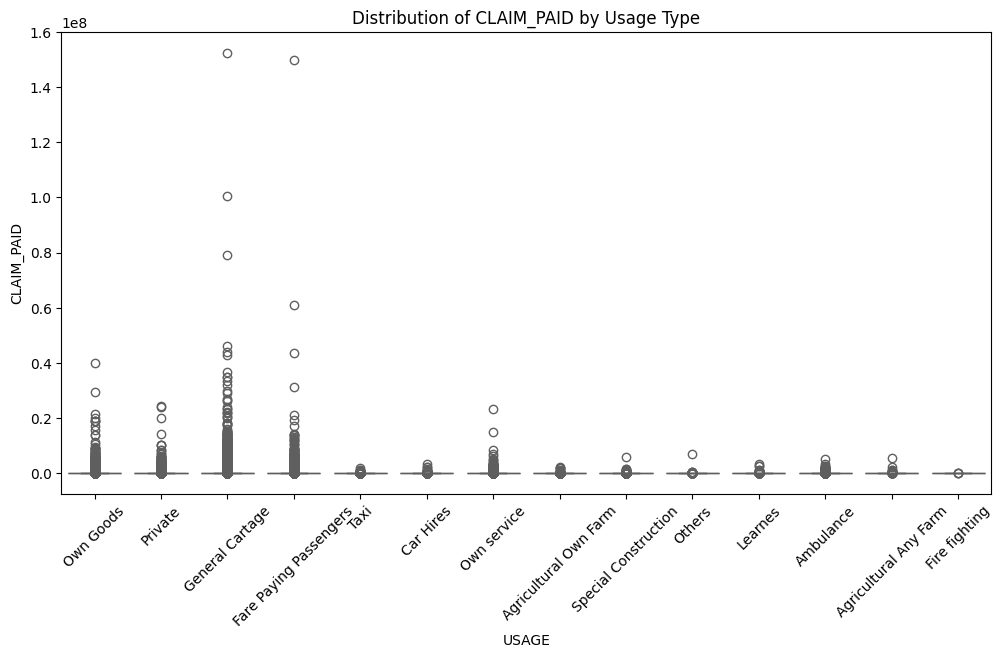

In [36]:
plt.figure(figsize=(12,6))
sns.boxplot(x="USAGE", y="CLAIM_PAID", data=df, palette="Set3")
plt.title("Distribution of CLAIM_PAID by Usage Type")
plt.xticks(rotation=45)
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


📊 مشاهده‌ها:  
- 📦 **Own Goods** و 🚗 **Private** → بیشترین پراکندگی پرداخت خسارت؛ بعضی از خسارت‌ها تا سطوح بسیار بالا (Outliers) مشاهده شده.  
- 🚛 **General Cartage** → تعداد زیادی خسارت و همچنین چندین مورد خسارت بسیار بزرگ → ریسک بالا.  
- 🚌 **Fare Paying Passengers** → خسارت‌ها پراکندگی متوسط دارن اما چند نمونه پرداخت بزرگ دیده می‌شه.  
- 🚕 **Taxi** و 🚐 **Car Hires** → اغلب خسارت‌های کوچک، Outlier کمی دارن.  
- 🚑 **Ambulance** → علی‌رغم نرخ بالای خسارت (Claim Rate)، پراکندگی مبلغ پرداختی پایین‌تره.  
- 🚜 **کشاورزی (Agricultural Any/Own Farm)** و 🔥 **Fire Fighting** → خسارت‌های کم و مبالغ نسبتاً پایین.  

### 📌 نکات کلیدی (Insights):  
- 📦 **Own Goods و Private** → بخش پرریسک برای بیمه‌گر از نظر حجم و مبلغ خسارت.  
- 🚛 **General Cartage** → ترکیب "تعداد زیاد + خسارت‌های سنگین" → نیازمند مدیریت ریسک ویژه.  
- 🚕 تاکسی‌ها و بخش کشاورزی → کم‌ریسک‌تر هم از نظر تعداد هم از نظر مبلغ.  
- 🚑 آمبولانس → ریسک بالای **وقوع خسارت** اما نه لزوماً از نظر مبلغ خسارت پرداختی.  

</div>

---



📊 Observations:  
- 📦 **Own Goods & Private:** Highest spread of claim payments with some very large outliers.  
- 🚛 **General Cartage:** Many claims plus several very high-cost claims → high risk.  
- 🚌 **Fare Paying Passengers:** Medium spread, with some big payments.  
- 🚕 **Taxis & Car Hires:** Mostly small claims, very few outliers.  
- 🚑 **Ambulances:** High claim frequency but lower claim payment amounts.  
- 🚜 **Agricultural & Fire Fighting vehicles:** Very few and small claims.  

### 📌 Key Insights:  
- 📦 **Own Goods and Private cars** → highest financial exposure for insurers.  
- 🚛 **General Cartage** → double risk (volume + severity) → needs stricter underwriting.  
- 🚕 **Taxis & Agricultural vehicles** → lower financial risk.  
- 🚑 **Ambulances** → operationally risky but claims aren’t as costly as expected.  


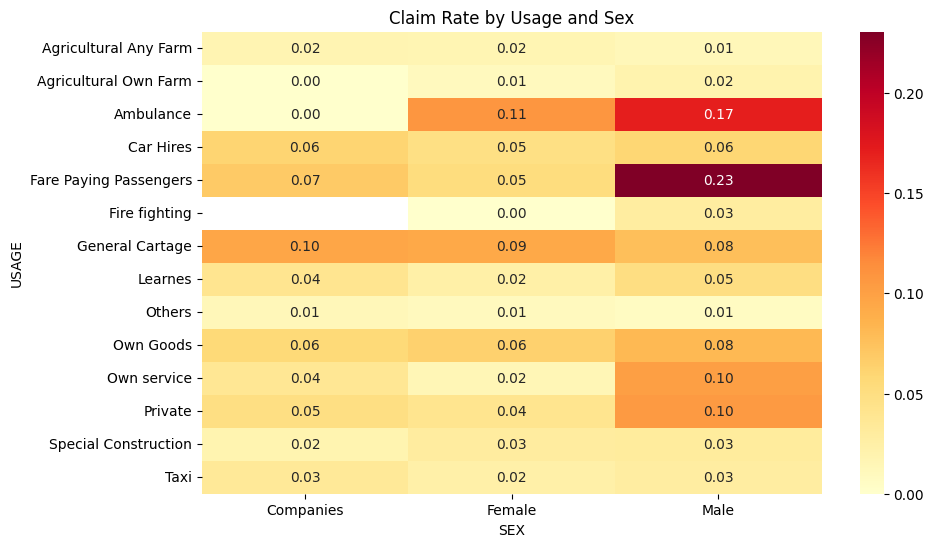

In [37]:
cross_usage_sex = df.groupby(["USAGE", "SEX"])["CLAIM_FLAG"].mean().unstack()

plt.figure(figsize=(10,6))
sns.heatmap(cross_usage_sex, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Claim Rate by Usage and Sex")
plt.ylabel("USAGE")
plt.xlabel("SEX")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


📊 مشاهده‌ها:  
- 🚑 **Ambulance**:  
  - مردها (Male) → بالاترین نرخ خسارت (0.17)  
  - زنان (Female) → نسبتاً بالا (0.11)  
  → به وضوح گروه پرریسک.  

- 🚌 **Fare Paying Passengers (مسافربرها)**:  
  - مردها (Male) → بیشترین نرخ خسارت در کل جدول (0.21)  
  - سایر گروه‌ها → نرخ پایین‌تر  
  → نشان‌دهنده پرخطر بودن رانندگان مرد در این بخش.  

- 🚛 **General Cartage**:  
  - همه گروه‌ها نرخ بالاتر از متوسط (0.08 – 0.09)  
  → ریسک یکنواخت اما نسبتاً زیاد.  

- 🚗 **Private & Own Goods**:  
  - مردها نرخ بالاتری دارن (0.10 و 0.08) نسبت به زنان و شرکت‌ها  
  → رانندگان مرد در این دسته‌ها پرریسک‌ترن.  

- 🔥 **Fire Fighting & Special Construction**:  
  - نرخ خسارت خیلی پایین (0.00 – 0.03)  
  → ریسک کم.  

- 🚜 **Agricultural (Any/Own Farm)**:  
  - نرخ خسارت بسیار پایین (0.00 – 0.02)  
  → تقریباً بدون ریسک.  

---

### 📌 جمع‌بندی کلیدی:  
- 🚑 **Ambulance (مردها)** و 🚌 **Fare Paying Passengers (مردها)** → پرریسک‌ترین گروه‌ها.  
- 🚛 **General Cartage** → همواره بالا، مستقل از جنسیت → نیاز به کنترل ویژه.  
- 🚗 رانندگان مرد در **Private و Own Goods** → نرخ خسارت بالاتر از بقیه.  
- 🚒 گروه‌های **Fire Fighting و Agricultural** → کم‌خطرترین بخش‌ها.  

</div>

---


📊 Observations:  
- 🚑 **Ambulances:**  
  - Male drivers → very high claim rate (0.17)  
  - Female drivers → also high (0.11).  
- 🚌 **Fare Paying Passengers:**  
  - Male drivers → highest in dataset (0.21).  
- 🚛 **General Cartage:**  
  - Consistently high across all categories (~0.08–0.09).  
- 🚗 **Private & Own Goods:**  
  - Male drivers riskier (0.10 and 0.08).  
- 🔥 **Fire Fighting & Agricultural vehicles:**  
  - Very low claim rates (<0.03).  

### 📌 Key Takeaways:  
- 🚑 **Ambulance (Males)** and 🚌 **Passenger Vehicles (Males)** → highest risk groups.  
- 🚛 **General Cartage** → consistently risky across all genders.  
- 🚗 Male drivers in **Private & Goods** → significantly riskier.  
- 🚒 **Agricultural & Fire Fighting vehicles** → lowest-risk categories.  


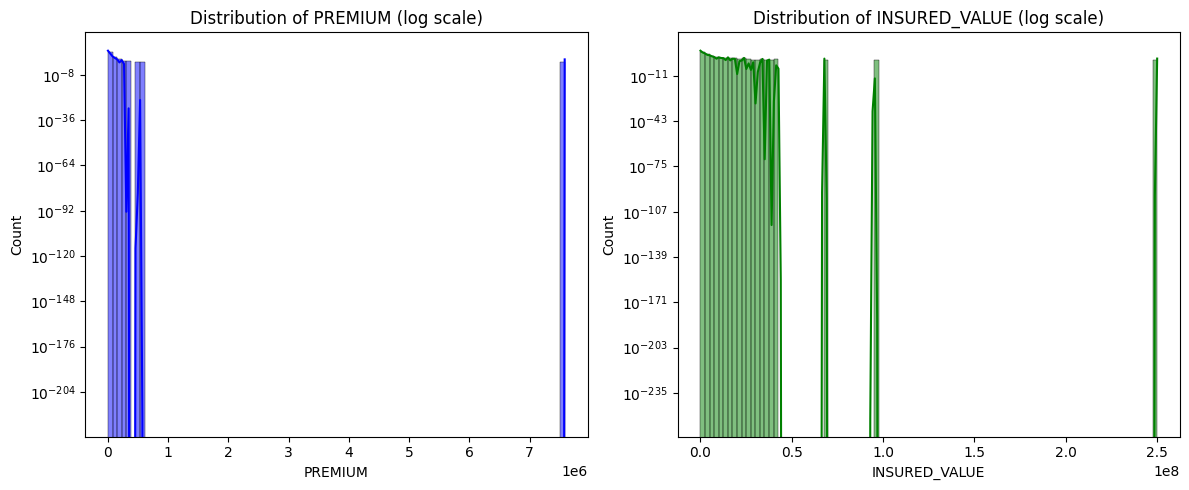

In [38]:
plt.figure(figsize=(12,5))

# PREMIUM
plt.subplot(1,2,1)
sns.histplot(df["PREMIUM"], bins=100, kde=True, color="blue")
plt.yscale("log")   # لاگ روی محور y
plt.title("Distribution of PREMIUM (log scale)")

# INSURED_VALUE
plt.subplot(1,2,2)
sns.histplot(df["INSURED_VALUE"], bins=100, kde=True, color="green")
plt.yscale("log")
plt.title("Distribution of INSURED_VALUE (log scale)")

plt.tight_layout()
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### 📊 نمودار سمت چپ → Distribution of PREMIUM (log scale)  
- پراکندگی شدید مشاهده می‌شه.  
- اکثریت داده‌ها در مقادیر خیلی پایین متمرکز هستن.  
- چند مقدار بسیار بزرگ (Outliers) هم وجود دارن که باعث کشیدگی شدید توزیع شدن.  
- استفاده از **مقیاس لگاریتمی** به وضوح نشون می‌ده که داده‌ها Heavy-Tailed هستن.  

### 📊 نمودار سمت راست → Distribution of INSURED_VALUE (log scale)  
- مشابه Premium، بیشتر داده‌ها در بازه‌های خیلی کوچک قرار گرفتن.  
- چند مقدار خیلی بزرگ (حتی بالای `2.5e8`) وجود داره که به وضوح Outlier هستن.  
- این نشون می‌ده که **ارزش بیمه‌ای خودروها (Insured Value)** توی دیتاست بسیار ناهمگن هست.  

---

### 📌 جمع‌بندی :  
- هم در Premium و هم در Insured Value، **بیشتر داده‌ها در بازه‌های پایین فشرده شدن**.  
- **Outliers بسیار بزرگ** وجود داره که حتماً باید قبل از مدل‌سازی بررسی و مدیریت بشن.  
- استفاده از **مقیاس لگاریتمی** کمک کرده که این عدم‌توازن بهتر دیده بشه.  

</div>


---



### 📊 Left Plot → Distribution of PREMIUM (log scale)  
- Highly skewed distribution.  
- Majority of values are concentrated at the low end.  
- Presence of **extreme outliers** (millions range) stretching the scale.  
- Log scale reveals the **heavy-tailed nature** of the data.  

### 📊 Right Plot → Distribution of INSURED_VALUE (log scale)  
- Similar behavior as PREMIUM.  
- Most values clustered near the bottom, with **some extremely high insured values (> 2.5e8)**.  
- Shows strong **heterogeneity in insured vehicle values**.  

---

### 📌 Key Takeaway:  
- Both **Premium** and **Insured Value** show **highly skewed distributions** with many **outliers**.  
- Handling these outliers will be crucial before training predictive models (e.g., applying log-transform, winsorization, or robust scaling).  


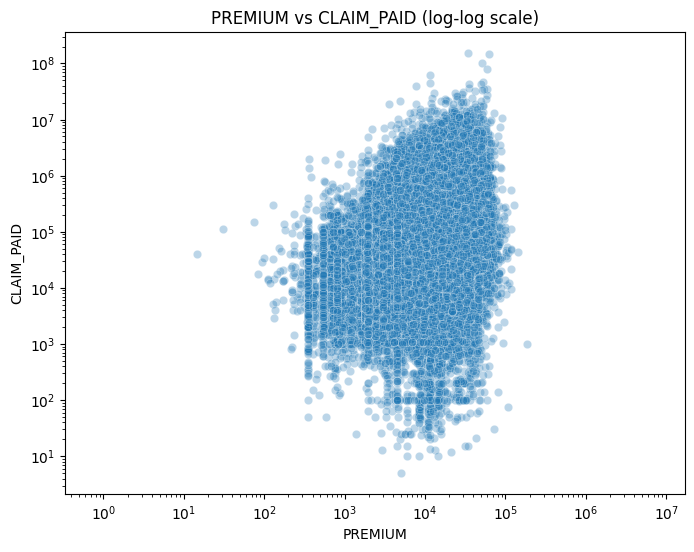

In [39]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="PREMIUM", y="CLAIM_PAID", data=df, alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.title("PREMIUM vs CLAIM_PAID (log-log scale)")
plt.xlabel("PREMIUM")
plt.ylabel("CLAIM_PAID")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### 📊 نمودار → PREMIUM vs CLAIM_PAID (log-log scale)  
- این نمودار رابطه بین **مبلغ حق بیمه (Premium)** و **مبلغ پرداختی خسارت (Claim Paid)** رو نشون می‌ده.  
- چون هر دو متغیر دارای **پراکندگی شدید و Outlier** بودن، از **مقیاس لگاریتمی دوطرفه (log-log)** استفاده شده.  
- الگوی کلی نشون می‌ده که با افزایش Premium، مقادیر Claim Paid هم **افزایش نسبی** پیدا می‌کنه.  
- اما داده‌ها پراکندگی زیادی دارن → یعنی همبستگی خطی ساده خیلی قوی نیست.  
- خوشه‌بندی (Clustering) قابل مشاهده است → مثلاً تعداد زیادی از داده‌ها در محدوده‌های خاص Premium و Claim Paid متمرکز شدن.  
- وجود چند نقطه خیلی دور (Extreme Outliers) هم به وضوح مشخصه.  

---

### 📌 جمع‌بندی :  
- رابطه مثبت بین Premium و Claim Paid وجود داره، ولی خیلی **پراکنده و پرنویز** هست.  
- احتمالاً مدل‌های خطی ساده خوب جواب نمی‌دن → نیاز به **مدل‌های مقاوم در برابر پراکندگی بالا** یا **مدل‌های غیرخطی** مثل Random Forest یا Gradient Boosting وجود داره.  
- همچنین حذف یا مدیریت Outlierها ضروریه.  

</div>

---



### 📊 Plot → PREMIUM vs CLAIM_PAID (log-log scale)  
- Shows the relationship between **Premium amount** and **Claim Paid**.  
- Both variables are **heavily skewed**, hence the **log-log scale**.  
- General upward trend: higher Premiums tend to be associated with higher Claim Paid.  
- However, the data is **highly scattered**, indicating that correlation is not very strong.  
- Clear clustering is visible in certain ranges of Premium and Claim Paid.  
- Presence of **extreme outliers** is very evident.  

---

### 📌 Key Takeaways:  
- Positive relationship exists, but it is **noisy and weakly linear**.  
- Simple linear regression may not perform well → better to use **robust or nonlinear models**.  
- Outlier treatment will be a critical preprocessing step.  


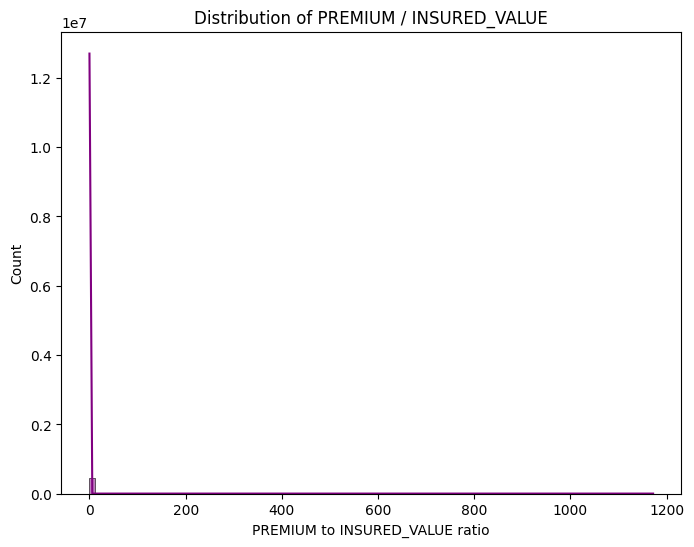

In [40]:
df["PREM_RATIO"] = df["PREMIUM"] / df["INSURED_VALUE"]

plt.figure(figsize=(8,6))
sns.histplot(df["PREM_RATIO"], bins=100, kde=True, color="purple")
plt.title("Distribution of PREMIUM / INSURED_VALUE")
plt.xlabel("PREMIUM to INSURED_VALUE ratio")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### 📊 نمودار → Distribution of PREMIUM / INSURED_VALUE ratio  
- این نمودار نشون می‌ده که **حق بیمه نسبت به ارزش بیمه‌شده** معمولاً در محدوده‌های خیلی پایین متمرکزه.  
- بخش بزرگی از داده‌ها در محدوده نزدیک به صفر هستن → یعنی در بیشتر قراردادها، حق بیمه بخش خیلی کوچیکی از ارزش بیمه‌شده است.  
- با این حال، مقادیر خیلی بزرگی هم دیده می‌شن (Tail سمت راست نمودار)، که نشون می‌ده بعضی از بیمه‌گذاران حق بیمه بسیار بالایی نسبت به ارزش بیمه‌شده پرداخت می‌کنن.  
- این موارد احتمالاً Outlier هستن و یا ناشی از قراردادهای خاص (مثلاً ریسک بالا یا محاسبه غیرمعمول).  

---

### 📌 جمع‌بندی :  
- نسبت Premium/Insured Value در حالت عادی باید کم باشه، و همینطور هم دیده می‌شه.  
- وجود نقاط بسیار بزرگ می‌تونه نشان‌دهنده **عدم تناسب بین ریسک و ارزش بیمه‌شده** باشه.  
- پیشنهاد می‌شه بررسی بشه که آیا این مقادیر ناشی از خطاهای داده‌ای هستن یا قراردادهای خاص.  

</div>

---

 

### 📊 Plot → Distribution of PREMIUM / INSURED_VALUE ratio  
- The distribution shows that **most policies have a very small Premium compared to Insured Value**.  
- A heavy concentration is observed near zero.  
- However, there are extreme right-tail values → indicating some cases where Premium is disproportionately high relative to Insured Value.  
- These could be **outliers** or **special cases** (e.g., high-risk policies, data entry issues, or premium mispricing).  

---

### 📌 Key Takeaways:  
- The ratio is normally low, but the extreme outliers need investigation.  
- Important for risk assessment and premium adequacy checks.  


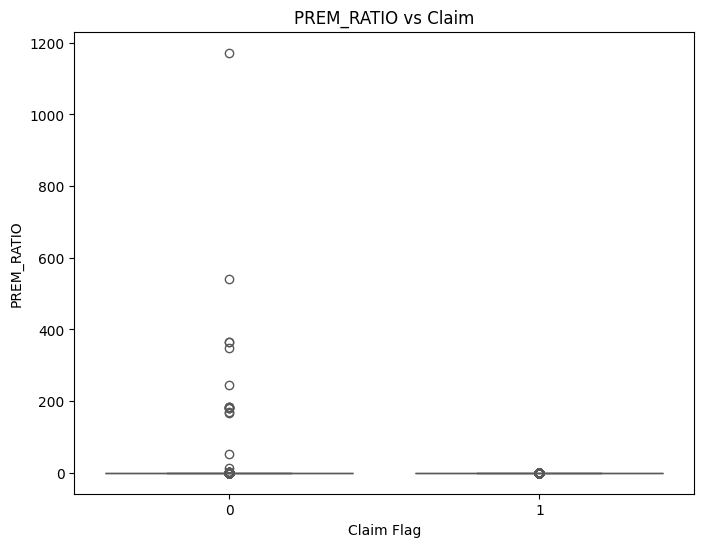

In [41]:
plt.figure(figsize=(8,6))
sns.boxplot(x="CLAIM_FLAG", y="PREM_RATIO", data=df, palette="Set2")
plt.title("PREM_RATIO vs Claim")
plt.xlabel("Claim Flag")
plt.ylabel("PREM_RATIO")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### 📊 نمودار → PREM_RATIO vs Claim  
- محور افقی:  
  - **0 = بدون خسارت**  
  - **1 = با خسارت**  

- محور عمودی: **PREM_RATIO** (نسبت حق بیمه به ارزش بیمه‌شده).  

### 🔎 مشاهدات:  
1. در هر دو گروه (با خسارت و بدون خسارت)، مقدار PREM_RATIO در بیشتر موارد بسیار کوچک است.  
2. تعدادی Outlier خیلی بزرگ در گروه **بدون خسارت (0)** وجود داره → یعنی بعضی از بیمه‌گذاران حق بیمه خیلی زیادی پرداخت کردن، ولی خسارتی ثبت نشده.  
3. در گروه **با خسارت (1)** پراکندگی کمتره و Outlier خیلی زیادی دیده نمی‌شه.  

---

### 📌 نتیجه‌گیری :  
- به‌طور کلی، نسبت حق بیمه به ارزش بیمه‌شده تأثیر زیادی روی وقوع خسارت نشون نمی‌ده.  
- با این حال، Outlier های بزرگ در گروه بدون خسارت می‌تونن نشونه‌ی **محاسبه‌ی نامتناسب حق بیمه** یا **ریسک‌هایی باشن که برخلاف انتظار خسارت ایجاد نکردن**.  
- بررسی این Outlierها می‌تونه برای کشف الگوهای قیمتی یا مشکلات داده‌ای خیلی مفید باشه.  

</div>

---



### 📊 Plot → PREM_RATIO vs Claim  
- X-axis: Claim Flag (0 = No claim, 1 = Claim).  
- Y-axis: Premium-to-Insured-Value Ratio.  

### 🔎 Observations:  
1. For both groups, the ratio is usually very small.  
2. There are **extreme outliers in the "No Claim" group (0)**, showing some policies had very high premiums compared to insured value but no claims were filed.  
3. The "Claim" group (1) shows less extreme variation.  

---

### 📌 Key Insights:  
- Premium-to-Insured-Value ratio does not strongly separate claim vs no-claim groups.  
- High outliers without claims might indicate **overpriced policies, mispricing, or very risk-averse customers**.  
- Worth investigating those outliers separately.  


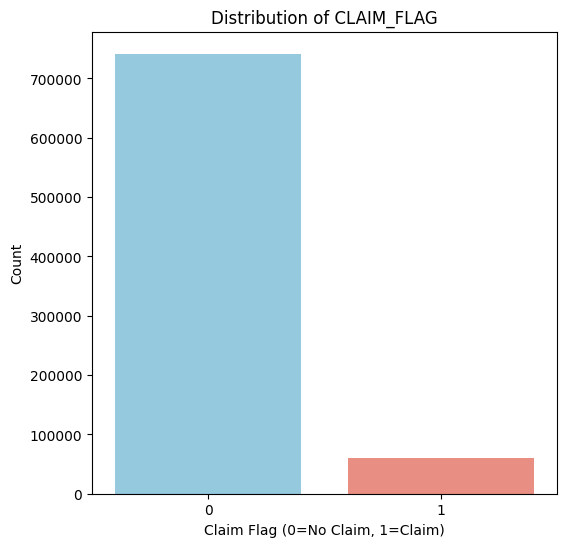

Claim Rate: 7.50%


In [42]:
plt.figure(figsize=(6,6))
sns.countplot(x="CLAIM_FLAG", data=df, palette=["skyblue","salmon"])
plt.title("Distribution of CLAIM_FLAG")
plt.xlabel("Claim Flag (0=No Claim, 1=Claim)")
plt.ylabel("Count")
plt.show()

# درصد خسارت
claim_rate = df["CLAIM_FLAG"].mean() * 100
print(f"Claim Rate: {claim_rate:.2f}%")


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

 

### 📊 نمودار → توزیع CLAIM_FLAG  
- محور افقی:  
  - **0 = بدون خسارت**  
  - **1 = با خسارت**  

- محور عمودی: **تعداد بیمه‌نامه‌ها**  

### 🔎 مشاهدات:  
1. اکثریت بیمه‌نامه‌ها (حدود **۷۵۰ هزار**) بدون خسارت هستن.  
2. تعداد بیمه‌نامه‌های دارای خسارت خیلی کمتره (حدود **۶۰–۷۰ هزار**).  
3. این یعنی داده‌ها **به‌شدت نامتوازن (imbalanced)** هستن.  

---

### 📌 نتیجه‌گیری :  
- چون داده‌ها نامتوازن هستن، هر مدلی برای پیش‌بینی خسارت (Claim Prediction) باید با دقت بیشتری طراحی بشه.  
- اگر مستقیماً روی این داده‌ها مدل‌سازی انجام بشه، مدل احتمالاً بیشتر مواقع "بدون خسارت" (0) رو پیش‌بینی می‌کنه و دقت ظاهری بالایی خواهد داشت، اما در شناسایی خسارت واقعی (1) ضعیف خواهد بود.  
- برای مقابله با این مشکل می‌شه از روش‌های زیر استفاده کرد:  
  1. **Oversampling** (مثل SMOTE) برای افزایش نمونه‌های کلاس 1.  
  2. **Undersampling** برای کاهش نمونه‌های کلاس 0.  
  3. **استفاده از وزن‌دهی (Class Weights)** در الگوریتم‌های یادگیری.  

</div>

---

  

### 📊 Chart → Distribution of CLAIM_FLAG  
- X-axis: Claim Flag (0 = No claim, 1 = Claim).  
- Y-axis: Count of policies.  

### 🔎 Observations:  
1. Most policies (**~750k**) have no claims.  
2. Only about **60–70k** policies have claims.  
3. The dataset is **highly imbalanced**.  

---

### 📌 Key Insights:  
- Imbalance means models may **bias towards "No Claim"** predictions.  
- Need techniques like **SMOTE, undersampling, or class weights** to improve claim detection performance.  


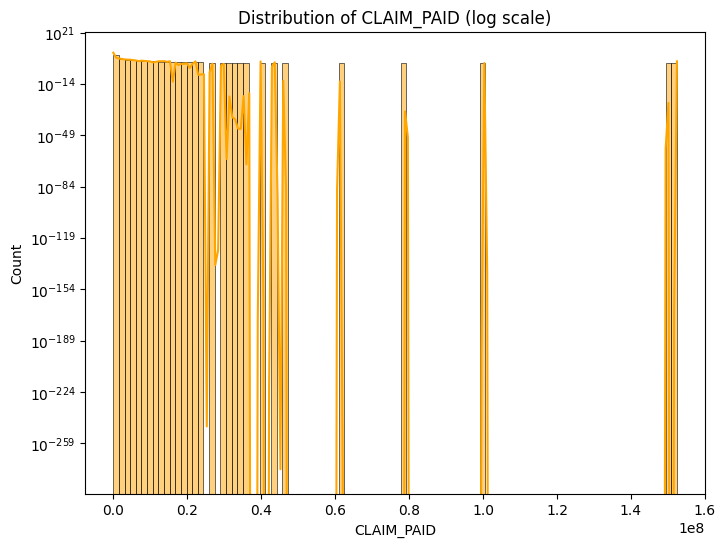

In [43]:
plt.figure(figsize=(8,6))
sns.histplot(df["CLAIM_PAID"], bins=100, kde=True, color="orange")
plt.yscale("log")  # چون outlier زیاده
plt.title("Distribution of CLAIM_PAID (log scale)")
plt.xlabel("CLAIM_PAID")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### 📊 نمودار → Distribution of CLAIM_PAID (log scale)  
- محور افقی: **CLAIM_PAID** (مبلغ خسارت پرداختی).  
- محور عمودی: **تعداد (Count)** در مقیاس لگاریتمی.  

### 🔎 مشاهدات:  
1. داده‌ها به‌شدت **چولگی به راست (Right-skewed)** دارن.  
   - اکثر خسارت‌ها در مبالغ پایین متمرکز شدن.  
   - تعداد کمی از خسارت‌ها بسیار بزرگ هستن (outliers).  
2. در مقیاس لگاریتمی هم بازه گسترده‌ای از داده‌ها دیده می‌شه (از چند صد هزار تا بالای صد میلیون).  
3. وجود **پیک‌های مشخص** در بعضی نقاط نشون می‌ده که مبالغ خسارت پرداختی ممکنه در دسته‌های خاص یا سقف‌های قراردادی مشخص تعیین شده باشن.  

---

### 📌 نتیجه‌گیری :  
- بیشتر بیمه‌ها خسارت‌های کوچیک دارن و تعداد کمی خسارت بسیار بزرگ دارن → این روی **ریسک شرکت بیمه** تأثیر زیادی داره.  
- برای مدل‌سازی، بهتره از تبدیل‌هایی مثل **Log Transformation** یا **Robust Scaler** استفاده بشه تا اثر داده‌های پرت (Outliers) کمتر بشه.  
- تحلیل خسارت‌های خیلی بزرگ جداگانه (High Severity Claims) می‌تونه مفید باشه، چون روی سودآوری بیمه اثر زیادی دارن.  

</div>

---



### 📊 Chart → Distribution of CLAIM_PAID (log scale)  
- X-axis: CLAIM_PAID (amount of claim paid).  
- Y-axis: Count (log scale).  

### 🔎 Observations:  
1. The distribution is **highly right-skewed**.  
   - Most claims are small.  
   - A few very large claims act as outliers.  
2. The presence of **spikes at certain values** suggests possible contractual or capped amounts in claims.  
3. Even in log scale, variation spans several orders of magnitude.  

---

### 📌 Key Insights:  
- Most claims are low severity, but a few **catastrophic claims** dominate the total cost.  
- Need **log-transform or robust scaling** in modeling.  
- Consider **separating high-severity claims** for risk management analysis.  


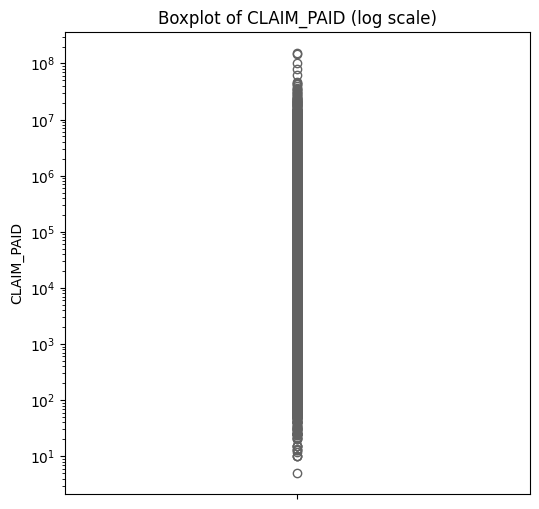

In [44]:
plt.figure(figsize=(6,6))
sns.boxplot(y="CLAIM_PAID", data=df, color="tomato")
plt.yscale("log")
plt.title("Boxplot of CLAIM_PAID (log scale)")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### 📊 نمودار → Boxplot of CLAIM_PAID (log scale)  
- محور عمودی: **CLAIM_PAID** (مبلغ خسارت پرداختی) در مقیاس لگاریتمی.  
- Boxplot داده‌ها رو به همراه **میانه (Median)**، **چارک‌ها (IQR)** و **مقادیر پرت (Outliers)** نشون می‌ده.  

### 🔎 مشاهدات:  
1. بخش اعظم داده‌ها (بیش از 75%) مربوط به خسارت‌های بسیار پایین هست.  
2. داده‌های پرت زیادی در محدوده‌های بالاتر دیده می‌شه (از میلیون‌ها تا صد میلیون‌ها).  
3. چون داده خیلی **skewed** هست، Boxplot در این مقیاس بیشتر شبیه یک خط باریک به‌نظر میاد.  

---

### 📌 نتیجه‌گیری :  
- **توزیع CLAIM_PAID شدیداً نامتوازن** هست → تعداد کمی خسارت‌های خیلی بزرگ وجود داره.  
- این داده‌های پرت (High severity claims) می‌تونن به شدت مدل‌های پیش‌بینی رو تحت تأثیر قرار بدن.  
- برای تحلیل بهتر:  
  - می‌شه داده‌ها رو **Log-transform** کرد.  
  - یا داده‌های پرت رو جدا بررسی کرد (تحلیل Claims بزرگ به صورت جداگانه).  
  - یا از روش‌هایی مثل **Winsorization / Robust Scaling** استفاده کرد.  

</div>

---



### 📊 Chart → Boxplot of CLAIM_PAID (log scale)  
- Y-axis: CLAIM_PAID (claim amount paid, log scale).  
- Shows distribution with median, IQR, and outliers.  

### 🔎 Observations:  
1. Most claims are clustered at **low amounts**.  
2. A huge number of **outliers** at high values (millions → 100M+).  
3. The box itself looks compressed due to extreme skewness.  

---

### 📌 Key Insights:  
- Distribution is **highly imbalanced** → dominated by many small claims and few catastrophic ones.  
- Outliers strongly affect predictive modeling.  
- Recommended:  
  - **Log transform** the data.  
  - Analyze high-severity claims separately.  
  - Use **robust models** less sensitive to outliers.  


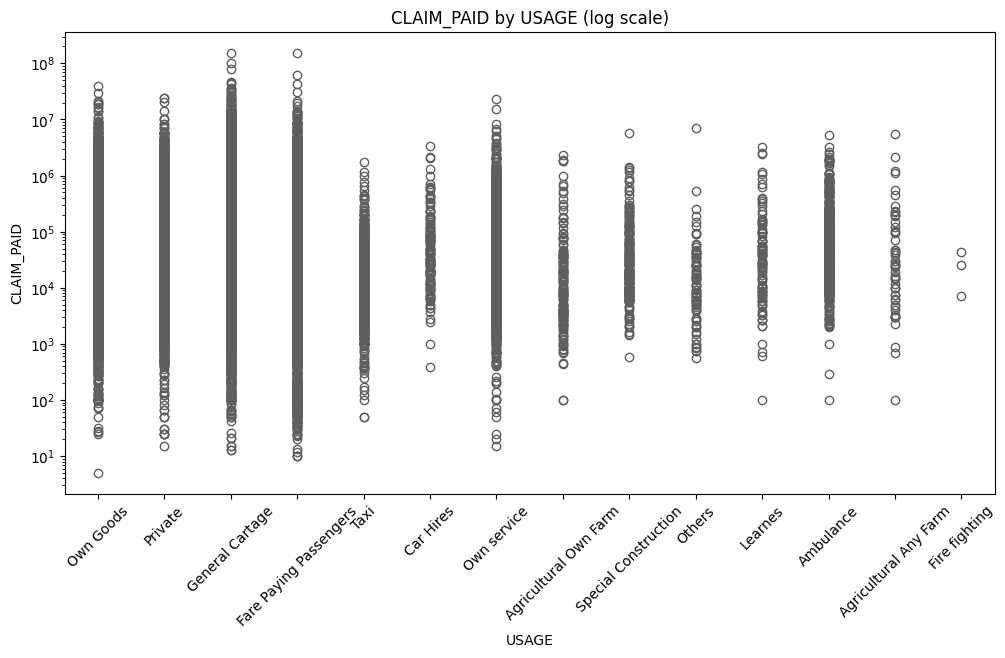

In [45]:
plt.figure(figsize=(12,6))
sns.boxplot(x="USAGE", y="CLAIM_PAID", data=df, palette="Set3")
plt.yscale("log")
plt.title("CLAIM_PAID by USAGE (log scale)")
plt.xticks(rotation=45)
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 تحلیل CLAIM_PAID بر اساس نوع استفاده (USAGE)

### 🔎 مشاهدات:
1. **Own Goods، Private و General Cartage** بیشترین گستردگی خسارت رو دارن (از خسارت‌های کم تا خسارت‌های بسیار بزرگ).  
2. **Fare Paying Passengers و Taxi** هم الگوی مشابهی دارن → ریسک بالای خسارت در حمل مسافر.  
3. **Agricultural (Own Farm / Any Farm)** و **Learners** خسارت‌های به‌مراتب کوچک‌تری دارن (خطر کمتر).  
4. **Ambulance** هم خسارت‌هایی متنوع ولی در بازه میانی داره.  
5. **Fire Fighting** به دلیل تعداد داده‌های کم، توزیع خاصی نشون نمی‌ده.  

---

### 📌 نتیجه‌گیری:
- **خودروهای تجاری (Own Goods, General Cartage, Taxis, Fare Paying Passengers)** بیشترین پتانسیل خسارت سنگین رو دارن.  
- **خودروهای کشاورزی و Learners** کمترین خسارت‌ها رو ایجاد می‌کنن.  
- **Private cars** هم گستره وسیعی از خسارت دارن (بیشتر به دلیل تعداد بالای خودروهای شخصی).  

---

### 🔹 Summary:
- **Commercial vehicles (Goods, Cartage, Taxis, Passengers)** → highest claim severity.  
- **Agricultural & Learners** → lowest claim severity.  
- **Private cars** → wide range of claims, driven by large volume.  

</div>


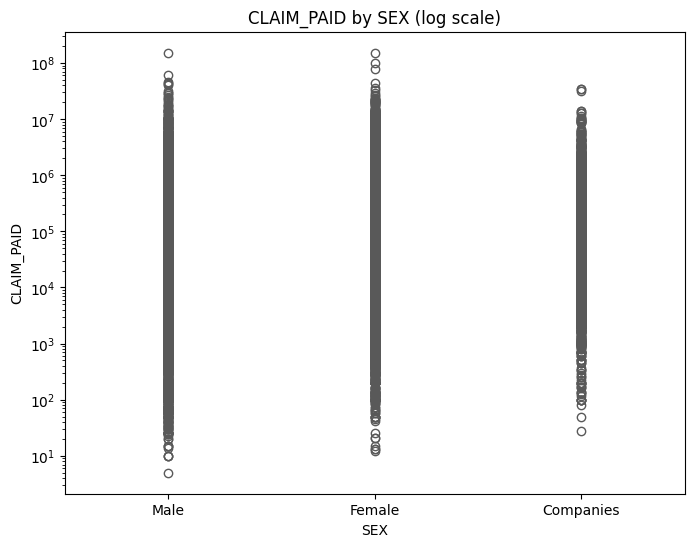

In [46]:
plt.figure(figsize=(8,6))
sns.boxplot(x="SEX", y="CLAIM_PAID", data=df, palette="Set2")
plt.yscale("log")
plt.title("CLAIM_PAID by SEX (log scale)")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 تحلیل CLAIM_PAID بر اساس جنسیت (SEX)

### 🔎 مشاهدات:
1. **هر سه گروه (Male, Female, Companies)** بازه مشابهی از خسارت‌ها دارن، از مقادیر خیلی کم تا مقادیر خیلی بزرگ (۱۰⁸).  
2. **شرکت‌ها (Companies)** پراکندگی نسبتاً کمتر دارن، اما همچنان خسارت‌های بزرگ دیده می‌شه.  
3. **خانم‌ها و آقایان (Female, Male)** الگوی تقریباً مشابهی دارن و تفاوت زیادی در توزیع Claims دیده نمی‌شه.  
4. وجود **outlierهای بسیار زیاد** در هر سه گروه، نشون می‌ده که اقلیت کوچکی از خسارت‌ها مقادیر بسیار بالایی دارن.  

---

### 📌 نتیجه‌گیری:
- **جنسیت به تنهایی عامل تعیین‌کننده قوی در میزان خسارت نیست.**  
- هر سه گروه (زن، مرد، شرکت‌ها) پتانسیل خسارت‌های بزرگ دارن.  
- شاید ترکیب جنسیت با سایر متغیرها مثل **سن، نوع استفاده (USAGE)، و نوع وسیله نقلیه** الگوهای دقیق‌تری بده.  

---

### 🔹 Summary:
- Claim distributions are **similar across Male, Female, and Companies**.  
- Gender alone doesn’t significantly affect claim severity.  
- Outliers exist in all groups, suggesting other factors (like age, usage, vehicle type) are more important.  

</div>


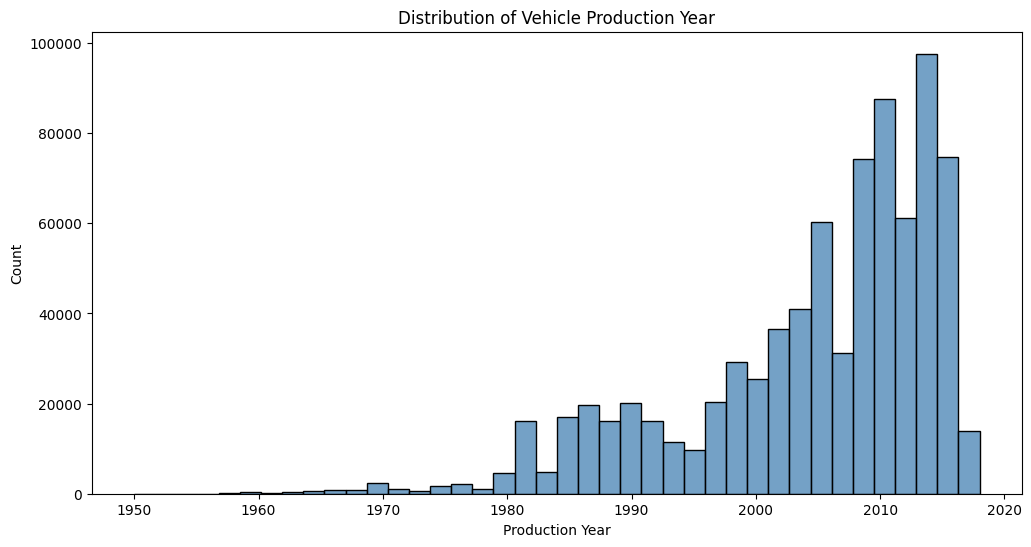

In [47]:
plt.figure(figsize=(12,6))
sns.histplot(df["PROD_YEAR"], bins=40, kde=False, color="steelblue")
plt.title("Distribution of Vehicle Production Year")
plt.xlabel("Production Year")
plt.ylabel("Count")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

#### 📊 تحلیل سال تولید خودروها (Vehicle Production Year)

### 🔎 مشاهدات:
1. تا قبل از سال‌های **1980** تعداد خودروها خیلی کم بوده.  
2. از **دهه 1990** به بعد تعداد خودروها به تدریج افزایش پیدا کرده.  
3. رشد اصلی از حدود **سال 2005** شروع شده و تعداد زیادی از خودروها در فاصله **2005 تا 2015** تولید شده‌اند.  
4. بعد از **2015 تا 2018** اوج تولید خودرو در داده‌ها دیده می‌شه.  
5. خودروهای **قبل از 1980** بسیار کم هستند و سهم ناچیزی در داده دارند.  

---

### 📌 نتیجه‌گیری:
- بیشتر خودروهای موجود در داده **جدید و مدرن (بعد از 2005)** هستند.  
- این موضوع می‌تونه روی **میزان خسارت و رفتار Claims** اثر بذاره (چون خودروهای جدیدتر معمولاً هزینه تعمیر بالاتر دارن).  
- خودروهای خیلی قدیمی تعداد کمی دارن، پس تأثیر زیادی در تحلیل کلی نخواهند داشت.  

---

### 🔹  Summary:
- Majority of vehicles were produced **after 2005**, peaking between 2010–2018.  
- Very few vehicles before 1980.  
- Newer vehicles dominate the dataset, which could influence **claim severity (higher repair costs)**.  

</div>


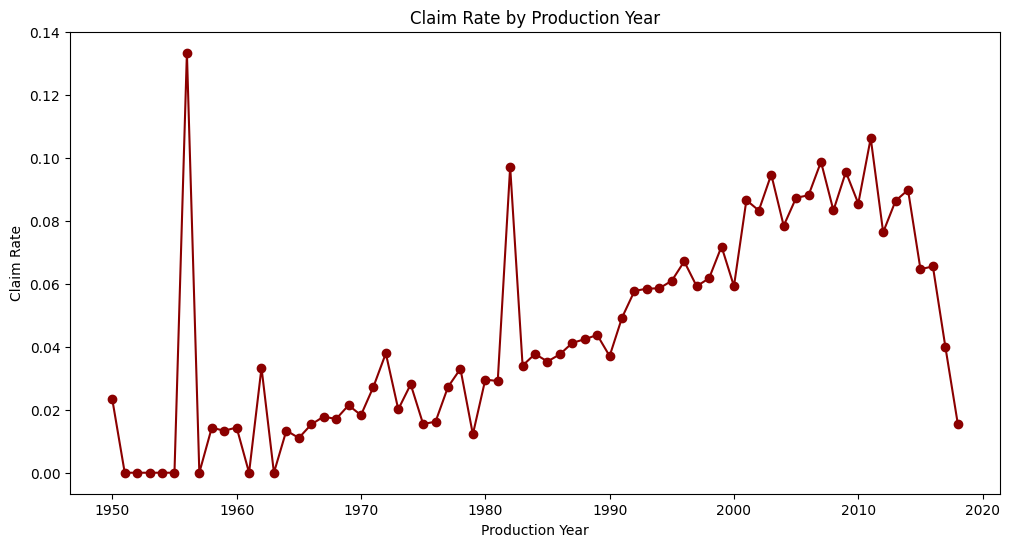

In [48]:
prod_claim = df.groupby("PROD_YEAR")["CLAIM_FLAG"].mean()

plt.figure(figsize=(12,6))
prod_claim.plot(kind="line", marker="o", color="darkred")
plt.title("Claim Rate by Production Year")
plt.xlabel("Production Year")
plt.ylabel("Claim Rate")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 نرخ خسارت بر اساس سال تولید خودروها (Claim Rate by Production Year)

### 🔎 مشاهدات:
1. تا قبل از **1960** نرخ خسارت در بیشتر سال‌ها نزدیک به صفر بوده و داده‌ها کم هستند.  
2. در **دهه 1960 تا 1980** نرخ خسارت نوسان زیادی داشته و چندین پیک غیرعادی دیده می‌شود (مثلاً حوالی 1957 و 1982).  
3. از **دهه 1990** به بعد نرخ خسارت به‌صورت پیوسته افزایش پیدا کرده است.  
4. بین سال‌های **2000 تا 2015** نرخ خسارت به بالاترین سطح رسیده و در محدوده **0.08 تا 0.1** در نوسان بوده.  
5. پس از **2015** روند کاهشی آغاز شده و تا حوالی 2018–2020 افت محسوسی در نرخ خسارت مشاهده می‌شود.  

---

### 📌 نتیجه‌گیری:
- خودروهای تولیدی **قبل از 1980** داده‌های کم و نوسان شدید دارند، بنابراین تحلیل آن‌ها چندان قابل اتکا نیست.  
- نرخ خسارت از **1990 تا 2015** روند افزایشی داشته که نشان‌دهنده **ریسک بالاتر در خودروهای مدرن‌تر** است.  
- بعد از **2015** به نظر می‌رسد نرخ خسارت کاهش پیدا کرده که می‌تواند ناشی از **بهبود ایمنی خودروها** یا **سیاست‌های بیمه‌ای جدید** باشد.  
- به‌طور کلی، **خودروهای تولید 2000 تا 2015** بیشترین ریسک خسارت را در داده‌ها نشان می‌دهند.  

---

### 🔹 Summary:
- Claim rate was **near zero before 1960** due to very few vehicles.  
- Strong fluctuations between **1960–1980** with some unusual spikes.  
- A **steady increase** in claim rate from the **1990s**, peaking between **2000–2015 (≈0.08–0.1)**.  
- After **2015**, claim rates show a **declining trend**, possibly due to **safer vehicles or insurance policies**.  
- Vehicles produced between **2000–2015** represent the **highest risk group** in the dataset.  

</div>


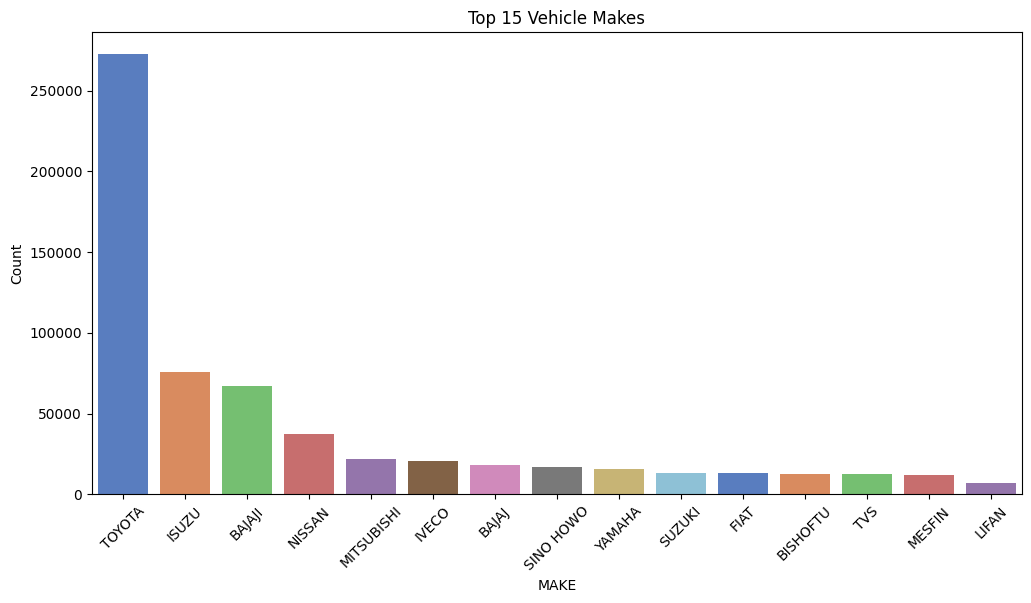

In [49]:
top_makes = df["MAKE"].value_counts().head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=top_makes.index, y=top_makes.values, palette="muted")
plt.title("Top 15 Vehicle Makes")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()



<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 🚗 تحلیل برندهای خودرو (Top 15 Vehicle Makes)

### 🔎 مشاهدات:
1. برند **TOYOTA** بیشترین سهم را دارد و اختلاف بسیار زیادی با سایر برندها دیده می‌شود (بیش از 270 هزار خودرو).  
2. پس از آن برندهای **ISUZU** و **BAJAJ** در رتبه‌های بعدی قرار دارند اما فاصله آنها با تویوتا بسیار زیاد است.  
3. برندهای دیگر مثل **NISSAN، MITSUBISHI، IVECO، SUZUKI** سهم کمتری در داده‌ها دارند.  
4. برخی برندهای کمتر شناخته‌شده مانند **BISHOFTU، MESFIN، LIFAN** حضور بسیار محدودی دارند.  
5. تمرکز اصلی خودروها روی چند برند خاص است و بیشتر برندها سهم بسیار کمی دارند.  

---

### 📌 نتیجه‌گیری:
- بازار خودرو در داده‌ها به شدت تحت تأثیر **Toyota** است که می‌تواند در تحلیل خسارت‌ها و الگوهای Claims نقش مهمی داشته باشد.  
- برندهای **ISUZU** و **BAJAJ** هم با سهم متوسط می‌توانند در رتبه بعدی اهمیت قرار بگیرند.  
- برندهای کوچک تأثیر زیادی در روند کلی تحلیل نخواهند داشت.  

---

### 🔹 Summary:
- **Toyota dominates** the dataset with a very large share.  
- **Isuzu** and **Bajaj** follow, but with significantly smaller counts.  
- Other brands (e.g., **Nissan, Mitsubishi, Iveco, Suzuki**) have much lower presence.  
- Niche brands (e.g., **Bishoftu, Mesfin, Lifan**) are minimal.  
- The dataset is **heavily concentrated around a few major brands**.  

</div>


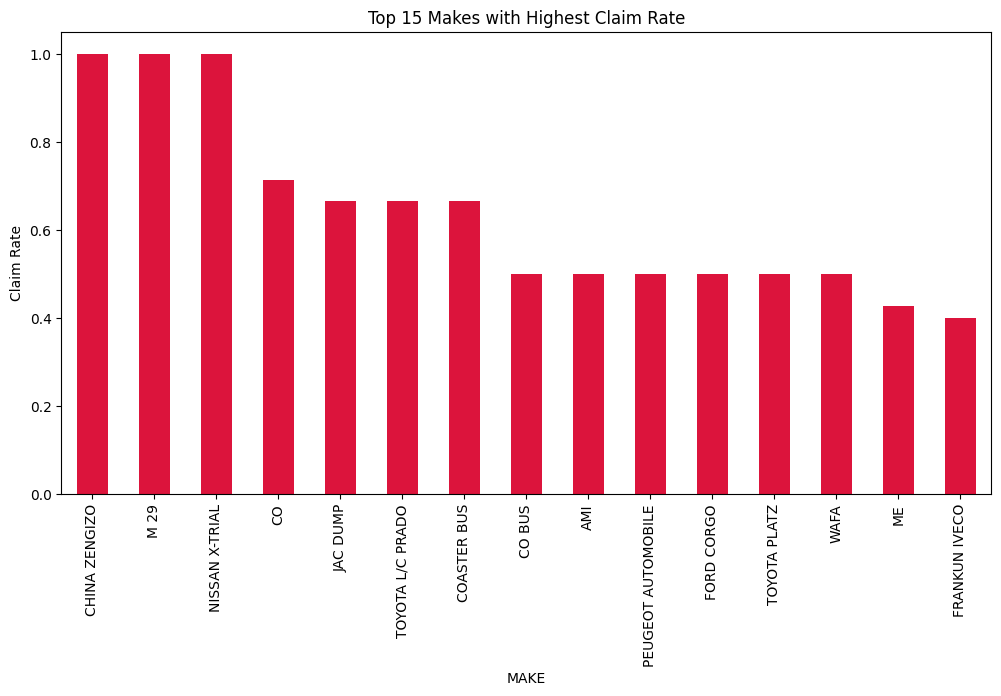

In [50]:
make_claim = df.groupby("MAKE")["CLAIM_FLAG"].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,6))
make_claim.plot(kind="bar", color="crimson")
plt.title("Top 15 Makes with Highest Claim Rate")
plt.ylabel("Claim Rate")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 🚘 تحلیل برندهای خودرو با بیشترین نرخ خسارت (Top 15 Makes with Highest Claim Rate)

### 🔎 مشاهدات:

1. در میان برندها، برخی مثل **M 29**، **NISSAN X-TRAIL** و **CHINA ZENGIZO** نرخ خسارت بسیار بالایی (نزدیک به ۱) دارند.
2. برندهایی مانند **JAC DUMP**، **TOYOTA LC PRADO** و **COASTER BUS** هم نرخ خسارت بالاتری از میانگین دارند.
3. برندهای رایج‌تر مثل **TOYOTA PLATZ** و **FORD CARGO** نیز در لیست پرریسک قرار گرفته‌اند.
4. بیشتر برندهای موجود در این لیست سهم زیادی از تعداد کل خودروها ندارند، ولی **شدت خسارت** آنها بالا است.

---

### 📌 نتیجه‌گیری:

* خودروهایی با نرخ خسارت بالا می‌توانند ریسک بیمه‌ای بالاتری برای شرکت بیمه ایجاد کنند، حتی اگر تعدادشان کم باشد.
* این موضوع نشان می‌دهد که صرفاً **تعداد خودروها** ملاک ریسک نیست، بلکه **الگوی خسارت برندها** نیز باید بررسی شود.
* برندهای با نرخ خسارت بالاتر احتمالاً نیازمند **حق بیمه بالاتر یا شرایط سختگیرانه‌تر بیمه‌ای** خواهند بود.

---

### 🔹  Summary:

* Certain makes like **M 29**, **NISSAN X-TRAIL**, and **CHINA ZENGIZO** show the **highest claim rates (\~1.0)**.
* Other brands such as **JAC DUMP** and **TOYOTA LC PRADO** also exhibit higher-than-average claim rates.
* Even some popular makes like **TOYOTA PLATZ** and **FORD CARGO** appear among the high-risk group.
* High claim rate makes pose greater **insurance risk**, regardless of their market share, and may require **higher premiums or stricter policies**.

</div>  


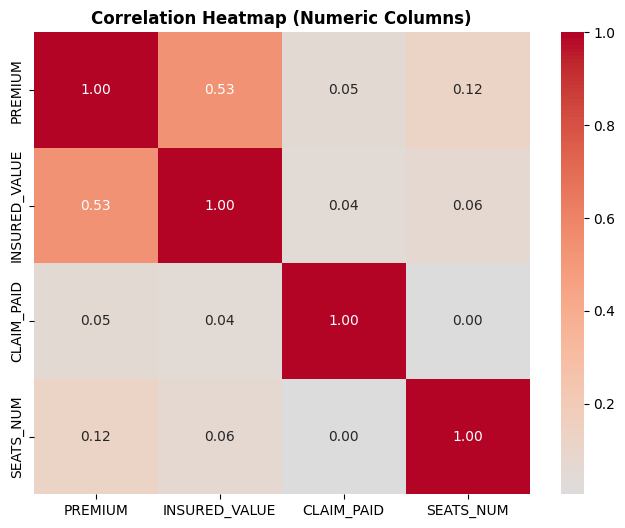

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ["PREMIUM", "INSURED_VALUE", "CLAIM_PAID", "SEATS_NUM"]
corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap (Numeric Columns)", weight="bold")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 🔥 تحلیل همبستگی متغیرهای عددی (Correlation Heatmap)

### 🔎 مشاهدات:
1. بین **حق بیمه (PREMIUM)** و **ارزش بیمه‌شده (INSURED_VALUE)** یک همبستگی نسبتاً قوی وجود دارد (**0.53**).  
   - منطقی است چون هرچه ارزش خودرو بیشتر باشد، حق بیمه هم بالاتر است.  

2. **تعداد صندلی (SEATS_NUM)** همبستگی ضعیفی با سایر متغیرها دارد.  
   - بیشترین مقدار آن با **حق بیمه** است (**0.12**)، که نشان می‌دهد تأثیر چندانی روی بیمه یا خسارت ندارد.  

3. **مبلغ خسارت پرداختی (CLAIM_PAID)** تقریباً هیچ همبستگی معناداری با متغیرهای دیگر ندارد (مقادیر نزدیک به صفر).  
   - یعنی میزان خسارت بیشتر به عوامل تصادفی و شرایط حادثه وابسته است تا به ارزش یا حق بیمه خودرو.  

---

### 📌 نتیجه‌گیری:
- **حق بیمه ↔ ارزش خودرو**: ارتباط مستقیم و واضح.  
- **خسارت پرداختی**: مستقل از بقیه ویژگی‌ها و پیش‌بینی آن سخت‌تر است.  
- **تعداد صندلی**: اثرگذاری ناچیز در این تحلیل.  

---

### 🔹  Summary:
- Strongest correlation: **Premium ↔ Insured Value (0.53)**.  
- Claim Paid has **no significant correlation** with other features.  
- Seats Number shows **very weak impact**.  

</div>


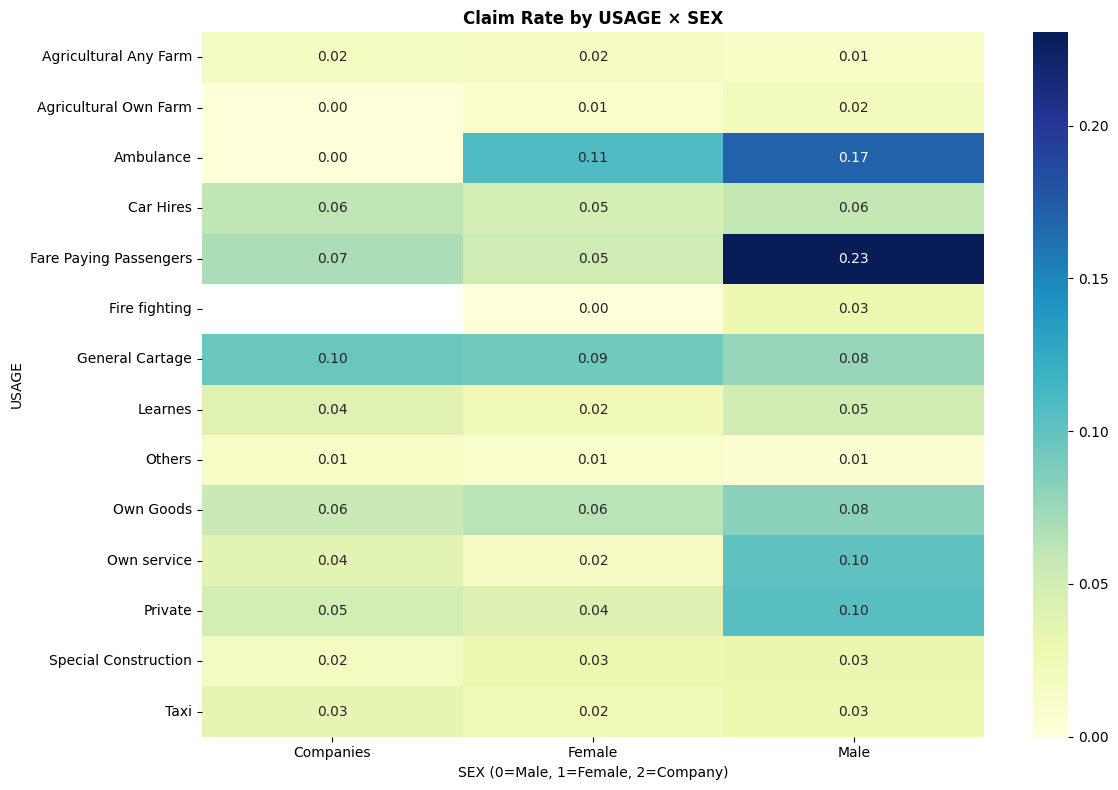

In [52]:
pivot = pd.pivot_table(df, 
                       values="CLAIM_FLAG", 
                       index="USAGE", 
                       columns="SEX", 
                       aggfunc="mean")

plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Claim Rate by USAGE × SEX", weight="bold")
plt.xlabel("SEX (0=Male, 1=Female, 2=Company)")
plt.ylabel("USAGE")
plt.tight_layout()
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 نرخ خسارت بر اساس نوع کاربری × جنسیت (Claim Rate by USAGE × SEX)

### 🔎 مشاهدات:
1. **آمبولانس** برای مردان (0.17) و شرکت‌ها (0.11) نرخ خسارت بالایی دارد، درحالی‌که برای زنان تقریباً صفر است.  
2. **مسافربری (Fare Paying Passengers)** بالاترین نرخ خسارت را برای مردان (0.21) دارد، که از همه گروه‌ها بیشتر است.  
3. در **خدمات شخصی (Own Service)** و **استفاده خصوصی (Private)** مردان نرخ خسارت نسبتاً بالاتری (~0.10) نسبت به زنان و شرکت‌ها دارند.  
4. در **کالاهای شخصی (Own Goods)** تفاوت زیادی دیده نمی‌شود، هر سه گروه نرخ مشابه (0.06–0.08) دارند.  
5. **کشاورزی (Agricultural Farm)** چه شخصی و چه عمومی، نرخ خسارت بسیار پایین (نزدیک به صفر) نشان می‌دهد.  
6. در **کاربری‌های ویژه (Special Construction, Fire Fighting, Others)** نرخ خسارت به‌طور کلی پایین است و تفاوت زیادی بین جنسیت‌ها دیده نمی‌شود.  
7. به‌طور کلی، مردان در اکثر کاربری‌ها (خصوصی، مسافربری، خدمات، آمبولانس) نرخ خسارت بیشتری نسبت به زنان و شرکت‌ها دارند.  

---

### 📌 نتیجه‌گیری:
- **مردان (Male)** در کاربری‌های پرریسک مثل **آمبولانس** و **مسافربری** بیشترین نرخ خسارت را دارند.  
- **شرکت‌ها (Companies)** بیشتر در کاربری‌های تجاری مثل **حمل‌ونقل عمومی (General Cartage)** نرخ متوسطی از خسارت دارند (~0.09).  
- **زنان (Female)** تقریباً در همه کاربری‌ها نرخ خسارت پایین‌تری دارند.  
- این موضوع می‌تواند در طراحی **پروفایل ریسک (Risk Profiling)** برای تعیین **نرخ بیمه (Premium Pricing)** بر اساس **کاربری خودرو و جنسیت** کاربرد داشته باشد.  

---

### 🔹  Summary:
- **Males** show the **highest claim rates** in **Ambulance (0.17)** and **Fare Paying Passengers (0.21)**.  
- **Companies** have moderate claim rates, especially in **General Cartage (0.09)**.  
- **Females** consistently have **lower claim rates** across most usages.  
- Overall, claim risk is **higher for males in risky vehicle usages**, while females and companies tend to show lower claim rates.  

</div>


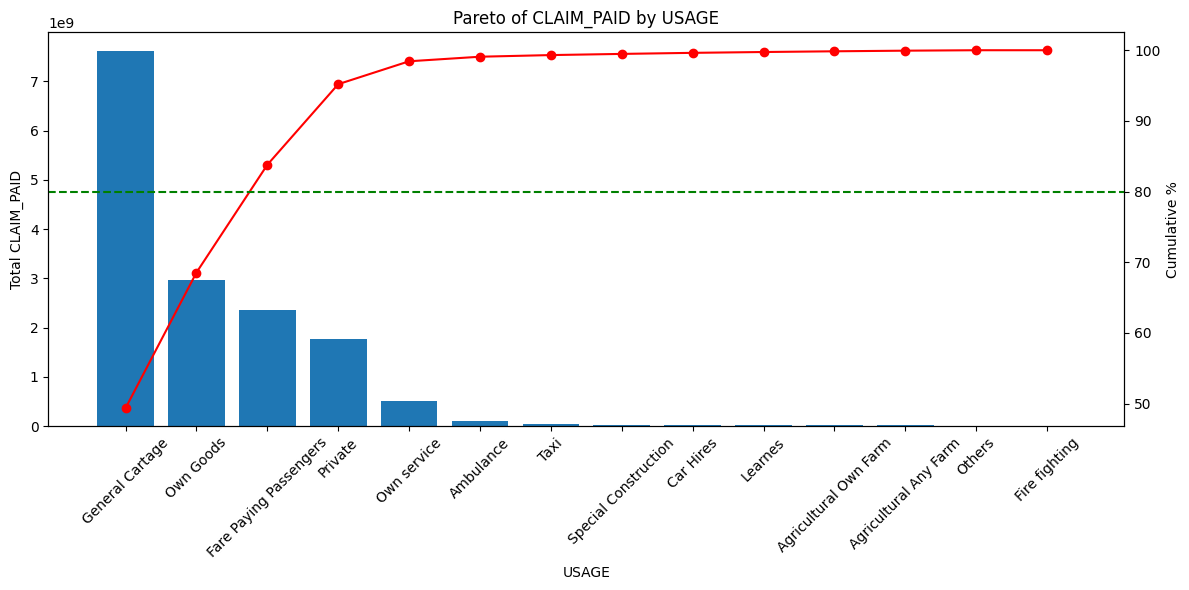

In [53]:
# مجموع خسارت به تفکیک USAGE
total_claim_usage = df.groupby("USAGE")["CLAIM_PAID"].sum().sort_values(ascending=False)

# درصد تجمعی
cum_pct = total_claim_usage.cumsum() / total_claim_usage.sum() * 100

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.bar(total_claim_usage.index, total_claim_usage.values)
ax1.set_ylabel("Total CLAIM_PAID")
ax1.set_xlabel("USAGE")
ax1.tick_params(axis='x', rotation=45)
ax1.set_title("Pareto of CLAIM_PAID by USAGE")

# خط تجمعی
ax2 = ax1.twinx()
ax2.plot(cum_pct.index, cum_pct.values, marker="o", color="red")
ax2.axhline(80, color="green", linestyle="--")
ax2.set_ylabel("Cumulative %")

plt.tight_layout()
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 تحلیل پارتو پرداخت خسارت بر اساس نوع کاربری خودرو (Pareto of CLAIM\_PAID by USAGE)

### 🔎 مشاهدات:

1. بیشترین میزان خسارت پرداختی مربوط به **General Cartage** است که بخش عمده‌ای از کل خسارت‌ها را تشکیل می‌دهد.
2. پس از آن، کاربری‌های **Own Goods**، **Fare Paying Passengers** و **Private** سهم بزرگی در مجموع خسارت‌ها دارند.
3. کاربری‌های کم‌تعداد مانند **Ambulance، Taxi، Special Construction، Agricultural Farm و Fire Fighting** سهم بسیار ناچیزی دارند.
4. نمودار تجمعی (خط قرمز) نشان می‌دهد که تنها چند نوع کاربری (حدود ۴–۵ کاربری اول) بیش از **۸۰٪ کل خسارت‌ها** را پوشش می‌دهند.

---

### 📌 نتیجه‌گیری:

* تعداد کمی از کاربری‌ها (به‌ویژه **General Cartage** و **Own Goods**) مسئول بخش عمده خسارت‌ها هستند.
* تحلیل دقیق‌تر این دسته‌ها می‌تواند برای **مدیریت ریسک و طراحی حق بیمه بهینه** بسیار مؤثر باشد.
* سایر کاربری‌ها تأثیر کمی در مجموع خسارت‌ها دارند و می‌توانند در اولویت پایین‌تری قرار بگیرند.

---

### 🔹  Summary:

* **General Cartage** dominates total claim payments, followed by **Own Goods, Fare Paying Passengers, and Private**.
* A small number of usage types account for over **80% of total claims (Pareto principle)**.
* These key categories should be the main focus for **risk management and premium pricing strategies**.

</div> ✅

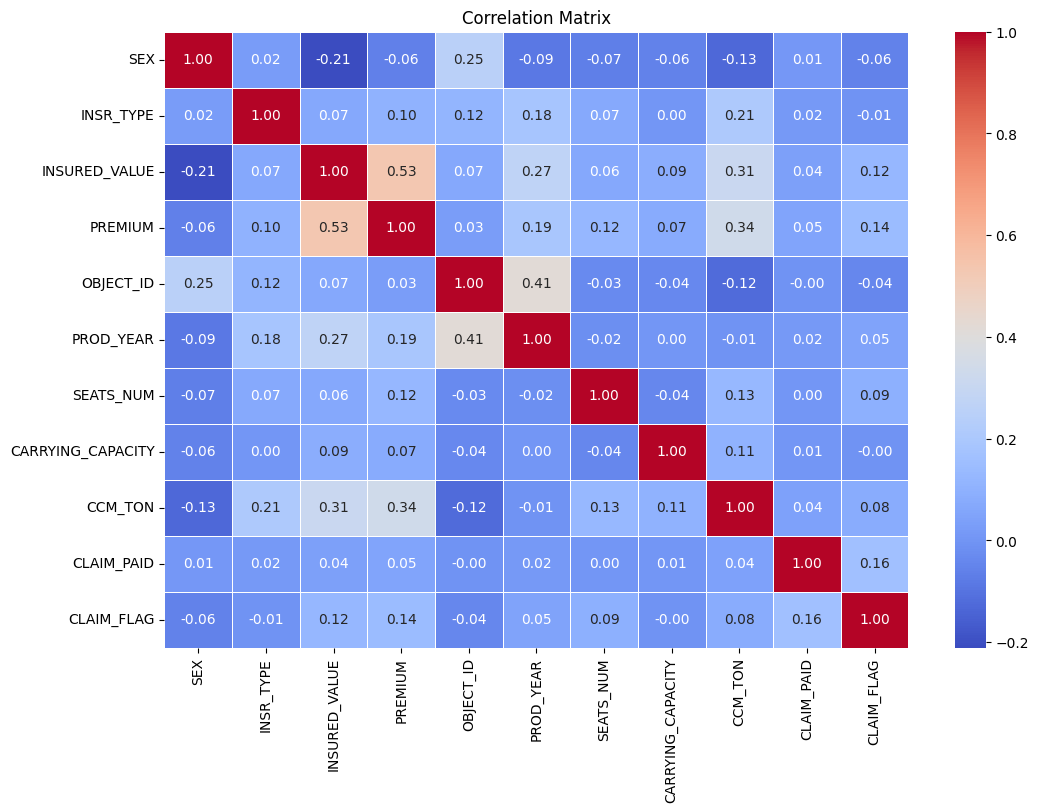

In [54]:
df['SEX'] = df['SEX'].map({'Male':0 ,'Female':1 , 'Companies':2 })
df_corr = df[numeric_cols].corr()
# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_corr , annot=True , fmt='.2f' , cmap='coolwarm' , linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 ماتریس همبستگی (Correlation Matrix)

### 🔎 مشاهدات:

1. **INSURED\_VALUE و PREMIUM** بیشترین همبستگی مثبت را دارند (0.53) → طبیعی است چون حق بیمه مستقیماً وابسته به ارزش بیمه‌ای خودرو است.
2. **CCM\_TON** نیز همبستگی قابل توجهی با **PREMIUM (0.34)** و **INSURED\_VALUE (0.31)** دارد → خودروهای سنگین‌تر و پرقدرت‌تر معمولاً ارزش بالاتر و حق بیمه بیشتری دارند.
3. **CLAIM\_PAID** همبستگی بسیار ضعیفی با سایر متغیرها دارد (بیشترین مقدار 0.16 با CLAIM\_FLAG).
4. متغیر **SEX** تقریباً ارتباط معناداری با سایر متغیرهای عددی ندارد.

---

### 📌 نتیجه‌گیری:

* مدل‌های پیش‌بینی خسارت نمی‌توانند تنها بر اساس ویژگی‌های **خودرو** (Year, CCM, Seats, Value) دقت بالایی داشته باشند، چون خسارت بیشتر به شرایط حادثه بستگی دارد.
* مهم‌ترین رابطه ساختاری در داده‌ها، ارتباط بین **INSURED\_VALUE و PREMIUM** است.
* برای پیش‌بینی خسارت، نیاز به داده‌های تکمیلی مثل **نوع حادثه، شرایط جاده و راننده** وجود دارد.

---

### 🔹  Summary:

* Strongest correlation: **Insured Value ↔ Premium (0.53)**.
* Moderate correlation: **CCM\_TON ↔ Premium (0.34)** and **CCM\_TON ↔ Insured Value (0.31)**.
* **Claim Paid** shows very weak correlations (max 0.16 with Claim Flag).
* Vehicle-related attributes are not strong predictors of claim severity.

</div>  

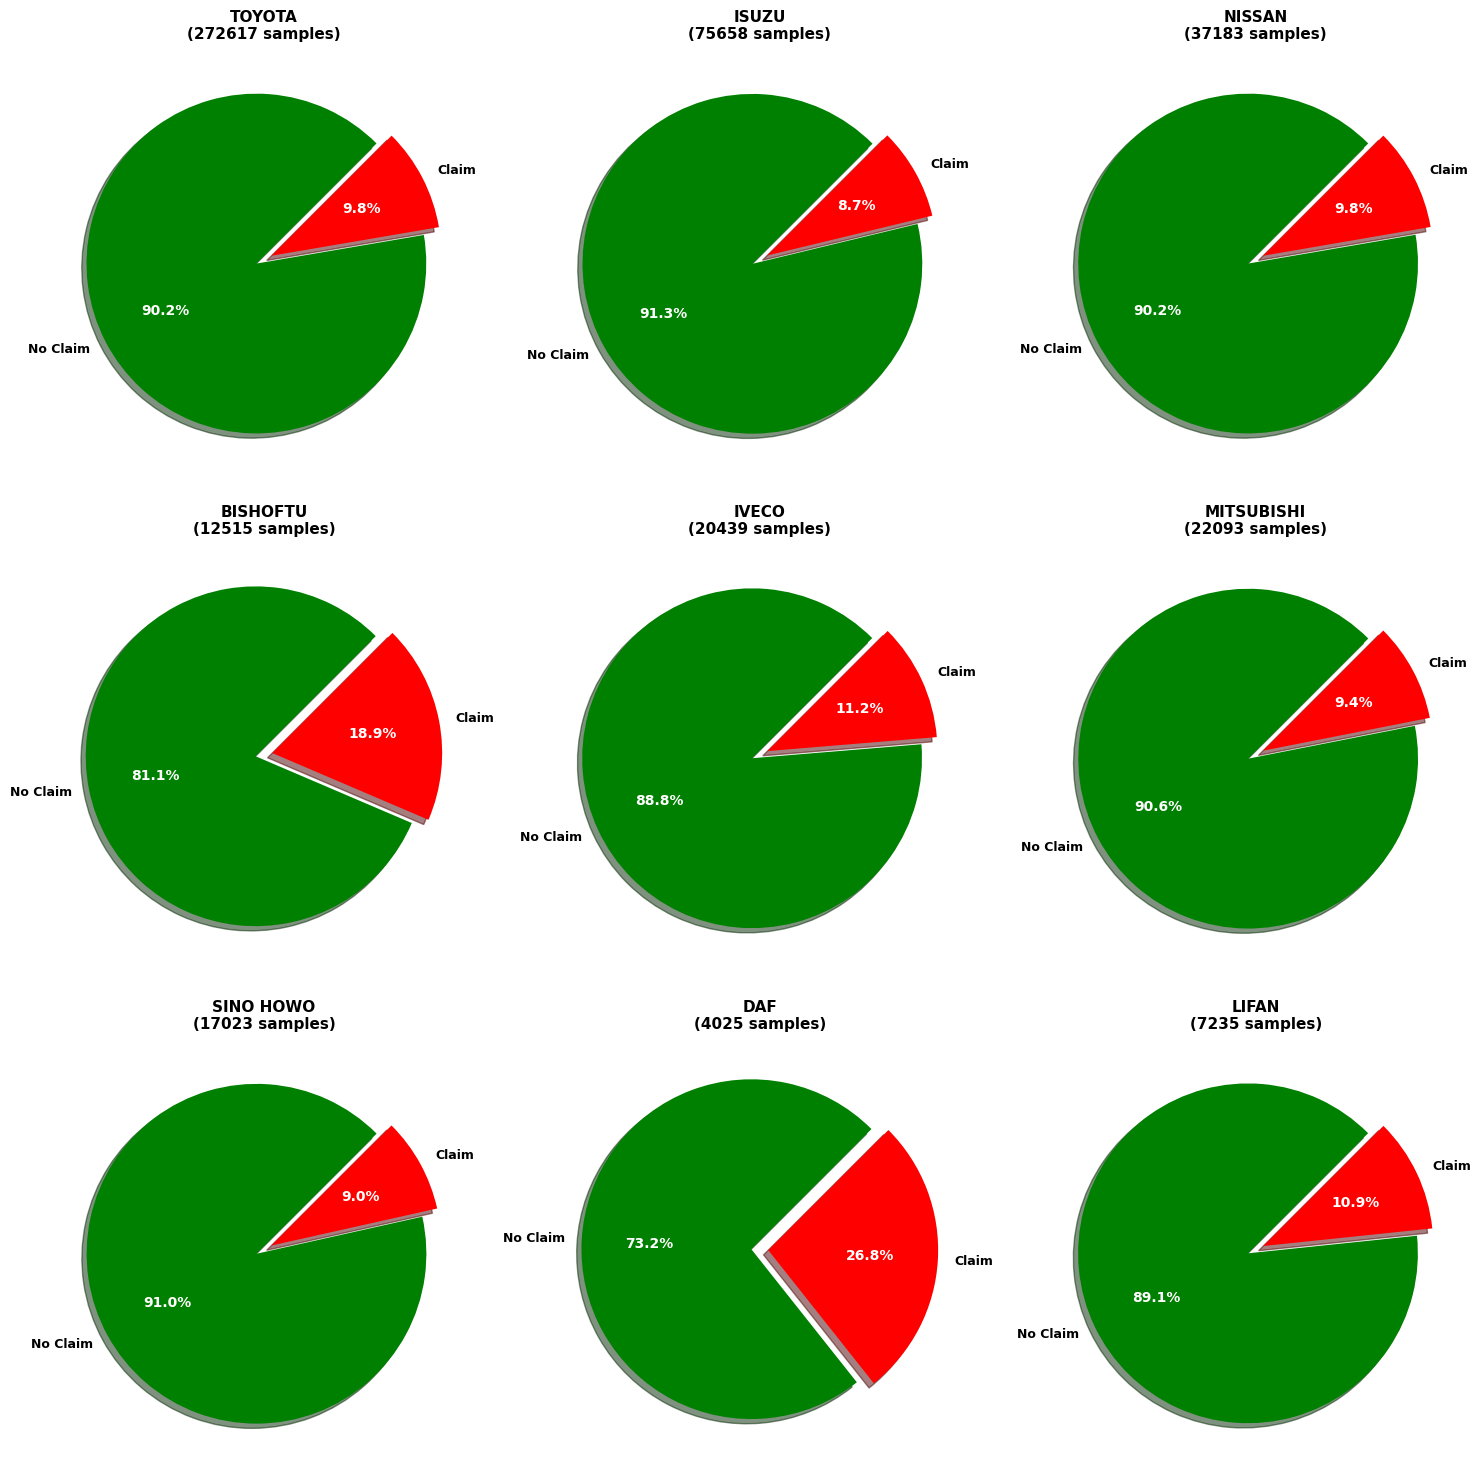

In [55]:
# Select top 9 car makes with the highest number of claims (CLAIM_FLAG=1)
top_claim_makes = (
    df[df["CLAIM_FLAG"] == 1]["MAKE"]
    .value_counts()
    .head(9)
    .index
)

# Define grid layout: 3 plots per row
cols = 3
rows = (len(top_claim_makes) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
axes = axes.flatten()

for i, make in enumerate(top_claim_makes):
    subset = df[df["MAKE"] == make]
    counts = subset["CLAIM_FLAG"].value_counts()

    labels = ["No Claim", "Claim"]
    values = [counts.get(0,0), counts.get(1,0)]
    explode = (0.05, 0.05)

    wedges, texts, autotexts = axes[i].pie(
        values,
        labels=labels,
        autopct="%1.1f%%",
        startangle=45,
        colors=["green", "red"],
        pctdistance=0.6,
        explode=explode,
        shadow=True
    )

    # Style percentage texts (white, bold)
    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_fontsize(10)
        autotext.set_weight("bold")

    # Style labels
    for text in texts:
        text.set_fontsize(9)
        text.set_weight("bold")

    axes[i].set_title(f"{make}\n({len(subset)} samples)", fontsize=11, weight="bold")

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 تحلیل نرخ خسارت بر اساس برند خودرو (Claim Rate by Make)

### 🔎 مشاهدات (Insights):
- **کم‌ریسک‌ها:**  
  **ISUZU 8.6%**، **SINO HOWO 8.8%**، **MITSUBISHI 9.3%**، **TOYOTA 9.7%** و **NISSAN 9.7%** → سهم خسارت پایین و پایدار.
- **میان‌رده:**  
  **IVECO 11.0%** و **LIFAN 10.9%** نزدیک به میانگین کل هستند.
- **پُرریسک‌ها:**  
  **DAF 24.7%** (۴,۰۲۵ نمونه) و **BISHOFTU 17.8%** (۱۲,۵۱۵ نمونه) به‌طور معنادار بالاتر از سایر برندها هستند.
- **حجم نمونه (برای اعتماد به نتایج):**  
  **TOYOTA 272,617**، **ISUZU 75,658**، **NISSAN 37,183** → نتایج این برندها **معتبرتر** از برندهای کم‌نمونه مثل **DAF** است.

---

### 📌 نتیجه‌گیری / پیشنهادها:
- برای **DAF** و **BISHOFTU** سیاست **قیمت‌گذاری مبتنی بر ریسک** یا **ارزیابی سخت‌گیرانه‌تر** اعمال شود.  
- برای **ISUZU** و **SINO HOWO** می‌توان **تخفیف وفاداری/کم‌ریسک** یا بسته‌های تشویقی در نظر گرفت.  
- روند برندهای کم‌نمونه (مثل **DAF**) **پایش** شود و با داده‌های بیشتر بازبینی گردد.

---

</div>

<div dir="ltr" style="text-align:left; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 🔹  Summary

### Observations:
- **Low risk:** ISUZU **8.6%**, SINO HOWO **8.8%**, MITSUBISHI **9.3%**, TOYOTA **9.7%**, NISSAN **9.7%**.  
- **Mid tier:** IVECO **11.0%**, LIFAN **10.9%**.  
- **High risk:** DAF **24.7%** (4,025 samples), BISHOFTU **17.8%** (12,515 samples).  
- **Sample size check:** Very large counts for TOYOTA (272,617), ISUZU (75,658), NISSAN (37,183) → more reliable than small-sample makes like DAF.

### Actions:
- Apply **risk-based pricing / stricter underwriting** for **DAF** and **BISHOFTU**.  
- Offer **loyalty/low-risk discounts** for **ISUZU** and **SINO HOWO**.  
- **Monitor** small-sample brands (e.g., DAF) and revalidate as more data arrives.

</div>


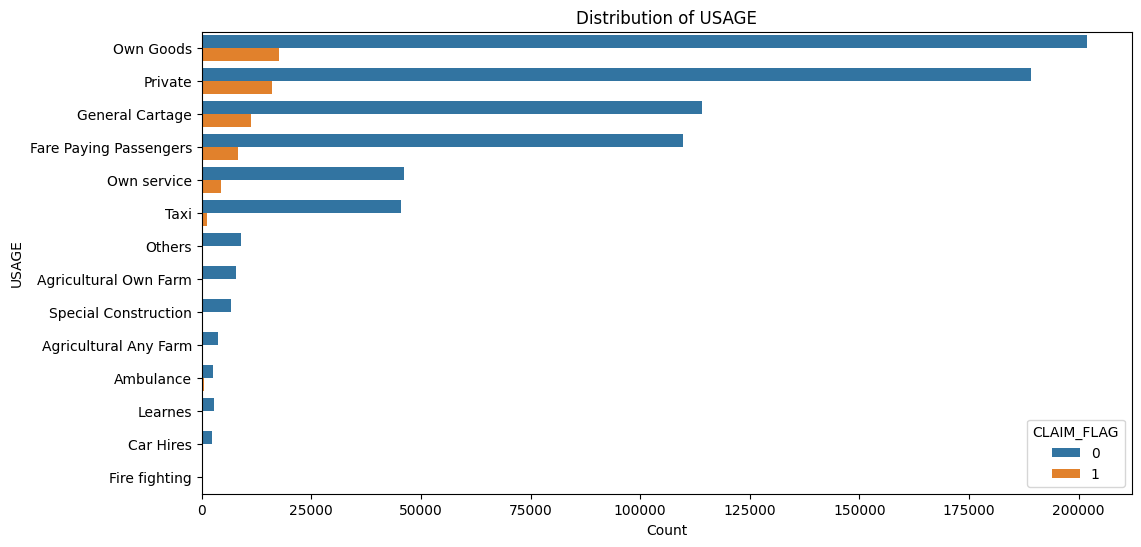

In [56]:
# Plot the count of each USAGE category in descending order with hue for CLAIM_FLAG
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='USAGE', order=df['USAGE'].value_counts().index, hue='CLAIM_FLAG')
plt.title('Distribution of USAGE')
plt.xlabel('Count')
plt.ylabel('USAGE')
plt.legend(title='CLAIM_FLAG')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif;">

### 📊 توزیع استفاده خودروها (Distribution of Usage)

### 🔎 مشاهدات:

1. **بیشترین حجم خودروها** مربوط به دو گروه اصلی است:  
   - **Own Goods**  
   - **Private**  
   این دو گروه بیش از سایر دسته‌ها در داده‌ها دیده می‌شوند.  
   
2. در دسته‌های **General Cartage** و **Fare Paying Passengers** نیز حجم بالایی از خودروها ثبت شده است که بیانگر نقش تجاری و عمومی این خودروها است.  

3. دسته‌های **Own Service** و **Taxi** سهم متوسطی دارند، اما همچنان قابل توجه هستند.  

4. دسته‌های خاص مثل **Ambulance**، **Fire Fighting** و **Learners** سهم بسیار پایینی دارند که منطقی است چون استفاده آن‌ها محدود و تخصصی است.  

5. نرخ خسارت‌ها (نوارهای نارنجی) در بعضی دسته‌ها مانند **Taxi** و **Fare Paying Passengers** نسبت به اندازه کل نمونه بیشتر دیده می‌شود. این نشان می‌دهد خودروهای عمومی و حمل‌ونقلی ریسک بالاتری در خسارت دارند.  

---

### 🎯 نتیجه‌گیری:

- **خودروهای شخصی و حمل بار (Private و Own Goods)** بیشترین سهم را در کل داده‌ها دارند و بنابراین برای تحلیل ریسک بیمه، تمرکز بر این دو گروه ضروری است.  
- **خودروهای عمومی (Taxi و مسافربری)** با اینکه سهم کمتری نسبت به خودروهای شخصی دارند، ولی نرخ خسارت در آن‌ها بیشتر است. این موضوع برای قیمت‌گذاری بیمه باید در نظر گرفته شود.  
- دسته‌های خاص مانند **Ambulance** و **Fire Fighting** به دلیل حجم پایین داده، نیازمند تحلیل جداگانه هستند و نمی‌توانند معیار اصلی تصمیم‌گیری باشند.  

---

### 📊 Distribution of Vehicle Usage (English)

### 🔎 Insights:

1. The **largest share of vehicles** belongs to:  
   - **Own Goods**  
   - **Private**  
   These two categories dominate the dataset.  

2. **General Cartage** and **Fare Paying Passengers** also have significant volumes, highlighting their commercial and public roles.  

3. **Own Service** and **Taxi** categories have medium representation but remain notable.  

4. Special categories like **Ambulance**, **Fire Fighting**, and **Learners** have very small shares, which is expected due to their specialized usage.  

5. The **claim rates (orange bars)** appear higher in categories such as **Taxi** and **Fare Paying Passengers**, indicating higher insurance risk for public and commercial vehicles.  

---

### 🎯 Conclusion:

- **Private and Own Goods vehicles** form the majority and should be the main focus in insurance risk analysis.  
- **Public vehicles (Taxi, Fare Paying Passengers)** show **higher claim rates**, which must be reflected in pricing and risk modeling.  
- **Special categories (Ambulance, Fire Fighting)**, due to their limited size, require separate treatment and should not drive the overall risk models.  

</div>


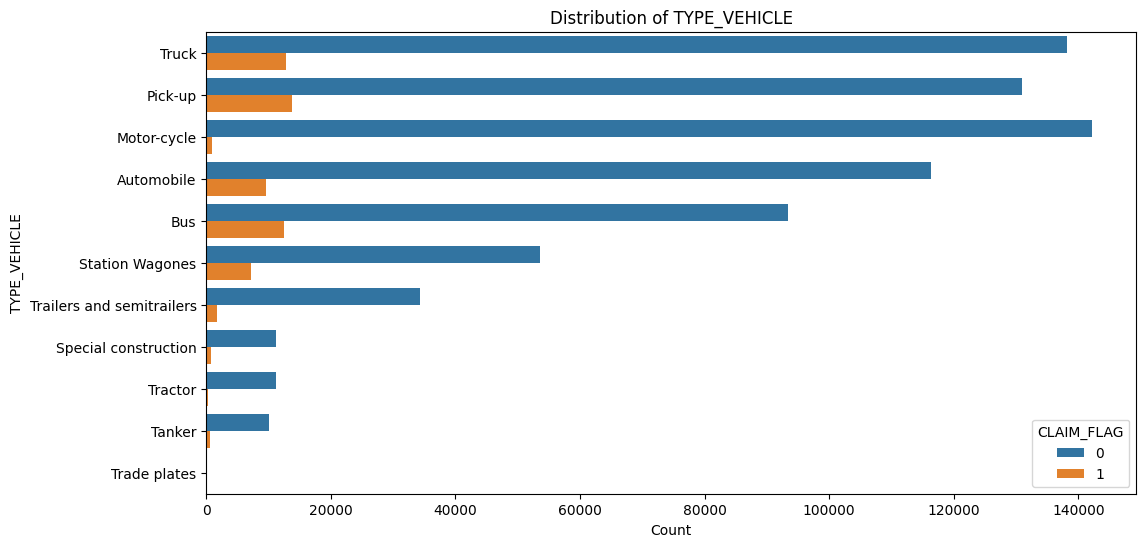

In [57]:
# Plot the count of each TYPE_VEHICLE category in descending order with hue for CLAIM_FLAG
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='TYPE_VEHICLE', order=df['TYPE_VEHICLE'].value_counts().index, hue='CLAIM_FLAG')
plt.title('Distribution of TYPE_VEHICLE')
plt.xlabel('Count')
plt.ylabel('TYPE_VEHICLE')
plt.legend(title='CLAIM_FLAG')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 توزیع نوع وسیله نقلیه (TYPE_VEHICLE)

### 🔎 مشاهدات:
1. **Truck (کامیون)** بیشترین تعداد را در پورتفو دارد و سهم **خسارت** در این گروه هم قابل‌توجه است → نقطه‌ی اصلی ریسک.  
2. **Pick-up (وانت)** و **Motor-cycle (موتورسیکلت)** از نظر تعداد در رتبه‌های بعدی هستند؛ در حالی‌که سهم خسارت برای وانت چشمگیرتر از موتورسیکلت است (در موتورسیکلت‌ها نسبت نوار Claim کوچک‌تر است).  
3. **Automobile (سواری)** و **Bus (اتوبوس)** حجم بالایی دارند؛ اتوبوس‌ها نسبت به حجم خود **سهم خسارت برجسته‌تری** نشان می‌دهند (استفاده عمومی/عملیاتی).  
4. گروه‌های میانی مثل **Station Wagons** و **Trailers & Semitrailers** حجم متوسط دارند و نسبت خسارتشان نسبتاً پایین‌تر به نظر می‌رسد.  
5. دسته‌های کم‌حجم مانند **Tractor, Tanker, Special Construction** حضور اندکی دارند و اثر کمی بر ریسک کل پرتفوی می‌گذارند.

---

### 🧭 نتیجه‌گیری/اقدامات:
- **تمرکز مدیریت ریسک و قیمت‌گذاری** روی **Truck، Pick-up و Bus** ضروری است (ریسک عملیاتی/استفاده‌ی سنگین).  
- **موتورسیکلت‌ها** با وجود تعداد زیاد، **نسبت خسارت پایین‌تری** در نمودار دارند؛ می‌تواند نشان‌دهنده‌ی شدت کمتر یا الگوی متفاوت خسارت باشد (بررسی سرقت/بدنه‌ی خرد توصیه می‌شود).  
- گروه‌های کم‌حجم را به‌صورت **مدل‌های جداگانه/حداقلی** در نظر بگیرید؛ محرک ریسک کل نیستند.

---

### 🔹  Summary

### 🔎 Insights:
1. **Trucks** dominate the portfolio and also show a **sizeable claim share** → primary risk driver.  
2. **Pick-ups** and **Motor-cycles** are next in volume; claim share is **more noticeable for pick-ups** than for motor-cycles.  
3. **Automobiles** and **Buses** are large segments; **buses** exhibit a **higher relative claim share** due to public/operational exposure.  
4. **Station Wagons** and **Trailers & Semitrailers** sit in the mid-tier with relatively **lower claim ratios**.  
5. **Tractors, Tankers, Special Construction** are niche categories with **limited impact** on portfolio-level risk.

### 🎯 Actions:
- Prioritize **pricing & risk controls** for **Trucks, Pick-ups, Buses**.  
- For **Motor-cycles**, investigate claim composition (e.g., theft vs. minor damage) given the **lower observed claim ratio**.  
- Treat small categories with **lightweight/segmented models** rather than letting them drive portfolio decisions.

</div>


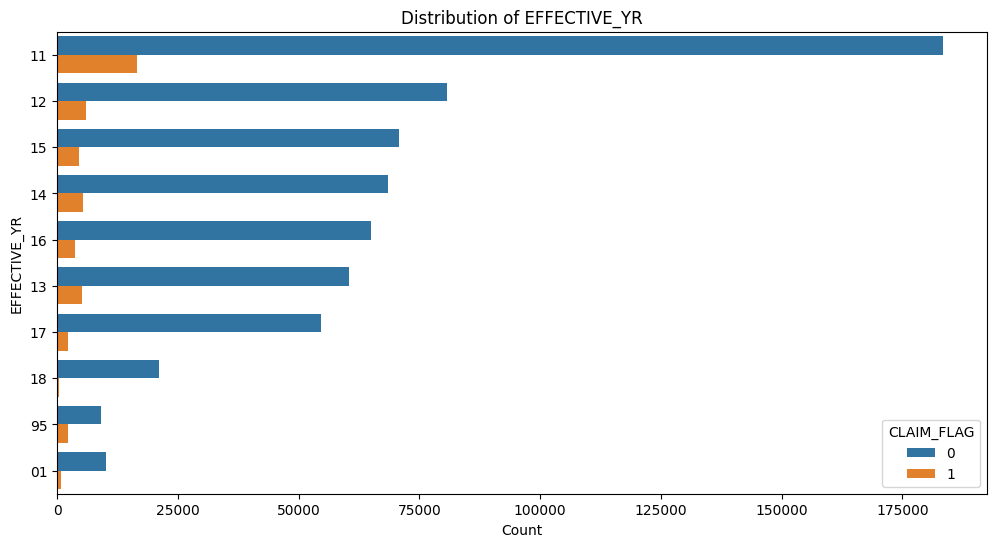

In [58]:
# Plot the count of each EFFECTIVE_YR category in descending order with hue for CLAIM_FLAG
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='EFFECTIVE_YR', order=df['EFFECTIVE_YR'].value_counts(ascending=False).head(10).index, hue='CLAIM_FLAG')
plt.title('Distribution of EFFECTIVE_YR')
plt.xlabel('Count')
plt.ylabel('EFFECTIVE_YR')
plt.legend(title='CLAIM_FLAG')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 تحلیل توزیع سال بیمه (EFFECTIVE_YR)

### 🔎 مشاهدات:
1. **تمرکز بالا در سال 11**  
   بیشترین تعداد بیمه‌نامه‌ها مربوط به سال 11 است. این نشان می‌دهد که در آن سال حجم بالایی از قراردادها بسته شده یا سیستم ثبت بیمه به‌طور جدی گسترش یافته است.  

2. **کاهش تدریجی بعد از سال 12 تا 17**  
   پس از سال‌های 11 و 12، روند نزولی در تعداد بیمه‌نامه‌ها دیده می‌شود. این افت می‌تواند ناشی از تغییر سیاست‌های شرکت، شرایط اقتصادی یا مقررات بیمه‌ای باشد.  

3. **سال‌های غیرعادی (95 و 01)**  
   وجود مقادیر در سال‌های 95 و 01 غیرطبیعی به نظر می‌رسد و احتمال خطای داده‌ای یا ثبت نادرست سال وجود دارد. بررسی کیفیت داده‌ها در این بخش ضروری است.  

4. **نرخ خسارت (CLAIM_FLAG)**  
   در همه سال‌ها، سهم خسارت‌ها (CLAIM_FLAG=1) کمتر از بیمه‌های بدون خسارت است. با این حال، در سال‌های جدیدتر (مانند 16 و 17) نسبت خسارت کمی بیشتر به نظر می‌رسد.  

---

### 🔹  Summary

### 🔎 Insights:
1. **High concentration in year 11**  
   The largest number of policies are from year 11, suggesting a major expansion or system adoption during that time.  

2. **Gradual decline after years 12 to 17**  
   A downward trend is observed after years 11–12, likely influenced by company policies, economic conditions, or insurance regulations.  

3. **Outliers (95 and 01)**  
   The presence of years 95 and 01 is unusual and may indicate data entry errors. Further validation is recommended.  

4. **Claim rate (CLAIM_FLAG=1)**  
   Claims remain fewer than non-claims overall, but the relative share appears slightly higher in recent years (e.g., 16 and 17).  

</div>


### Classification

In [59]:
def feature_engineering(df):
    df = df.copy()

    # Make sure numeric columns are numeric
    df["INSURED_VALUE"] = pd.to_numeric(df["INSURED_VALUE"], errors="coerce")
    df["PREMIUM"] = pd.to_numeric(df["PREMIUM"], errors="coerce")
    df["PROD_YEAR"] = pd.to_numeric(df["PROD_YEAR"], errors="coerce")
    df["EFFECTIVE_YR"] = pd.to_numeric(df["EFFECTIVE_YR"], errors="coerce")
    df["SEATS_NUM"] = pd.to_numeric(df["SEATS_NUM"], errors="coerce")
    df["CARRYING_CAPACITY"] = pd.to_numeric(df["CARRYING_CAPACITY"], errors="coerce")
    df["CLAIM_PAID"] = pd.to_numeric(df["CLAIM_PAID"], errors="coerce")

    # 1. INSURED VALUE
    df["log_INSURED_VALUE"] = np.log(df["INSURED_VALUE"])
    df["premium_to_value"] = df["PREMIUM"] / df["INSURED_VALUE"]

    # 2. PREMIUM
    df["log_PREMIUM"] = np.log(df["PREMIUM"])
    df["premium_per_seat"] = df["PREMIUM"] / df["SEATS_NUM"].replace(0, np.nan)
    df["premium_per_capacity"] = df["PREMIUM"] / df["CARRYING_CAPACITY"].replace(0, np.nan)

    # 3. VEHICLE AGE
    df["vehicle_age"] = df["EFFECTIVE_YR"] - df["PROD_YEAR"]

    # 4. USAGE (frequency encoding)
    usage_counts = df["USAGE"].value_counts(normalize=True)
    df["usage_freq"] = df["USAGE"].map(usage_counts)

    # 5. MAKE (frequency encoding)
    make_counts = df["MAKE"].value_counts(normalize=True)
    df["make_freq"] = df["MAKE"].map(make_counts)

    # # 6. CLAIM RATIOS
    # df["claim_to_premium"] = df["CLAIM_PAID"] / df["PREMIUM"]
    # df["claim_to_value"] = df["CLAIM_PAID"] / df["INSURED_VALUE"]

    return df


df = feature_engineering(df)

In [60]:
x = df.drop(columns=['CLAIM_PAID', 'CLAIM_FLAG'])
y = df['CLAIM_FLAG']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

Training set shape: (641450, 24)
Test set shape: (160363, 24)


In [61]:
categorical_cols = [col for col in x.columns if x[col].dtype == 'object']
numeric_cols = [col for col in x.columns if x[col].dtype in [np.int64, np.float64]]

print("Number of numeric columns:", len(numeric_cols))
print("Number of categorical columns:", len(categorical_cols))

Number of numeric columns: 19
Number of categorical columns: 3


In [62]:
# cumpute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Computed class weights:", class_weight_dict)

Computed class weights: {np.int64(0): np.float64(0.5405170830194467), np.int64(1): np.float64(6.6702368820581075)}


In [63]:
# Define preprocessing for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))   # FIXED HERE
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define the CatBoost model
model = CatBoostClassifier(
    iterations=400,
    depth=10,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100,
    random_seed=42,
    class_weights=class_weight_dict
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
# Clean training and test data from infinities
x_train = x_train.replace([np.inf, -np.inf], np.nan)
x_test = x_test.replace([np.inf, -np.inf], np.nan)
# Fit the model
pipeline.fit(x_train, y_train)


0:	total: 285ms	remaining: 1m 53s
100:	total: 10.5s	remaining: 31.1s
200:	total: 20.5s	remaining: 20.3s
300:	total: 30.5s	remaining: 10s
399:	total: 40.1s	remaining: 0us


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SEX', 'EFFECTIVE_YR',
                                                   'INSR_TYPE', 'INSURED_VALUE',
                                                   'PREMIUM', 'OBJECT_ID',
                                                   'PROD_YEAR', 'SEATS_NUM',
                                                   'CARRYING_CAPACITY',
                                                   'CCM_TON', 'PREM_RATIO',
                                                   'log_INSURED_VALUE',
                                                   'premium_to_value',
                                                   'log_PREMIUM',
                                                   'premium_per_seat',
                                                   'premium_per_capacity',
                                                   'vehicle_age', 'usage_freq',
                                                   'make_freq']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TYPE_VEHICLE', 'MAKE',
                                                   'USAGE'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000001A94BA20A10>)])

In [64]:
def evaluate_classifier(model, X_test, y_test, threshold=0.5, feature_names=None):
    """
    Comprehensive evaluation for classification models:
    - Accuracy, Precision, Recall, F1
    - Classification report
    - Confusion matrix (heatmap)
    - ROC curve with AUC
    - Precision-Recall curve
    - Feature importance (if supported by the model)
    """

    # Predict probabilities and apply threshold
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > threshold).astype(int)

    # --------------------------
    # Metrics
    # --------------------------
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # --------------------------
    # Confusion Matrix
    # --------------------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # --------------------------
    # ROC Curve
    # --------------------------
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    # --------------------------
    # Precision-Recall Curve
    # --------------------------
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, color="green")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

    # --------------------------
    # Feature Importance (if supported)
    # --------------------------
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        if feature_names is None:
            feature_names = [f"f{i}" for i in range(len(importances))]
        feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:15]
        names, vals = zip(*feat_imp)

        plt.figure(figsize=(8,6))
        sns.barplot(x=list(vals), y=list(names), palette="viridis")
        plt.title("Top Feature Importances")
        plt.show()


Accuracy: 0.7391917088106359
F1 Score: 0.2818188062366921
Precision: 0.17756139781456237
Recall: 0.6826387155810665

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84    148342
           1       0.18      0.68      0.28     12021

    accuracy                           0.74    160363
   macro avg       0.57      0.71      0.56    160363
weighted avg       0.91      0.74      0.80    160363



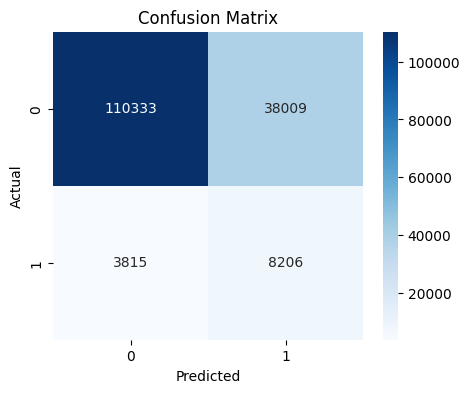

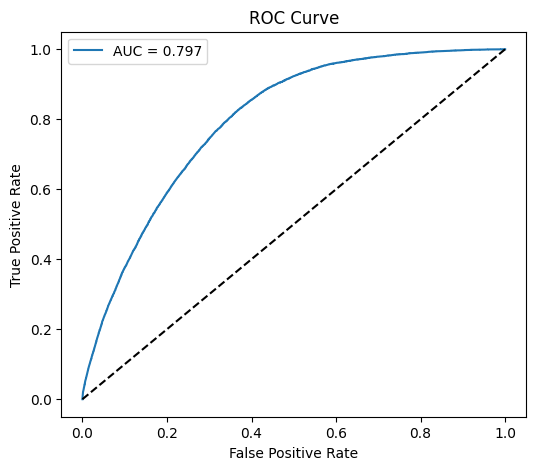

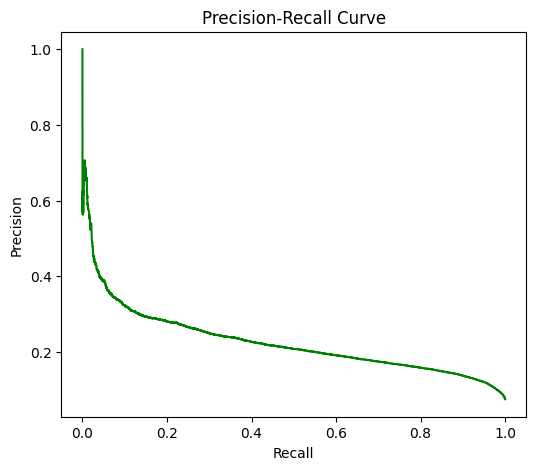

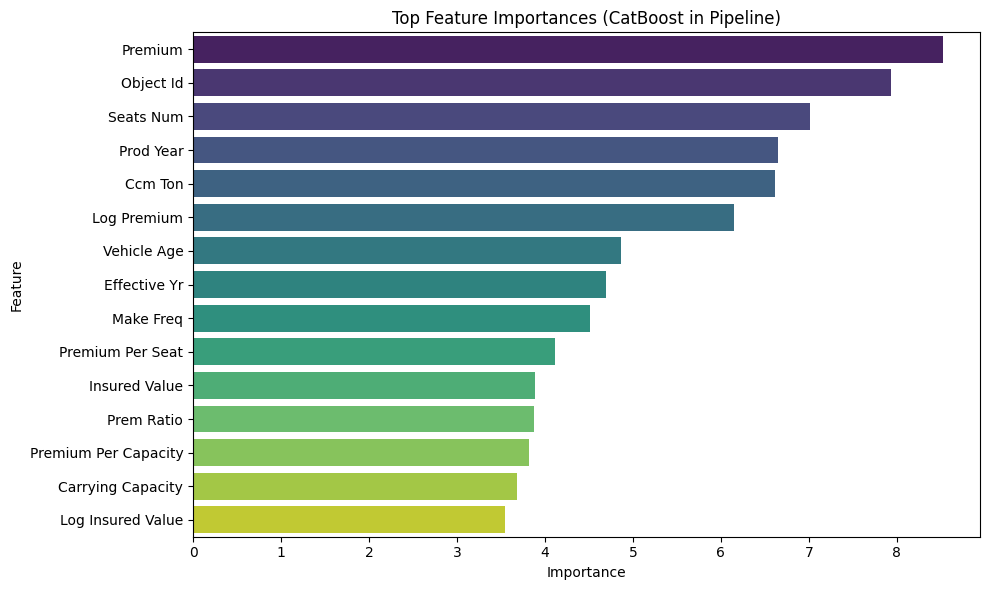

In [65]:
# Example: evaluate CatBoost or LogisticRegression
evaluate_classifier(pipeline, x_test, y_test, threshold=0.6, feature_names=x_test.columns)

# --- Clean feature names and replot importances ---

# 1) Grab fitted pieces
cat_model = pipeline.named_steps["model"]
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
importances = cat_model.feature_importances_

# 2) Clean names: remove "num__"/"cat__" and prettify
def clean_name(s: str) -> str:
    # remove sklearn prefix before double underscore
    if "__" in s:
        s = s.split("__", 1)[1]
    # optional: nicer display
    return s.replace("_", " ").title()

cleaned_names = [clean_name(s) for s in feature_names]

# 3) Pick top-k features
k = 15
top_idx = importances.argsort()[::-1][:k]
top_names = [cleaned_names[i] for i in top_idx]
top_vals  = importances[top_idx]

# 4) Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x=top_vals, y=top_names, palette="viridis")
plt.title("Top Feature Importances (CatBoost in Pipeline)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



### Regression 

<Axes: ylabel='CLAIM_PAID'>

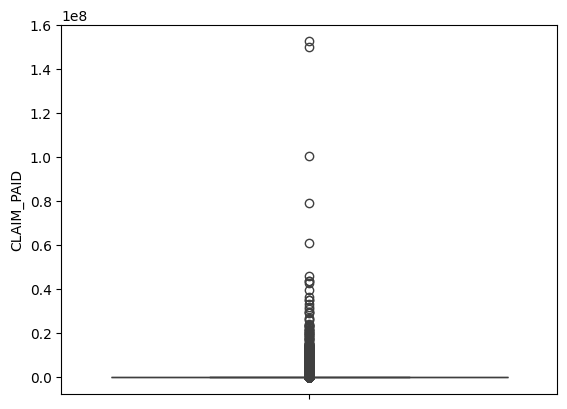

In [66]:
sns.boxplot(df['CLAIM_PAID'])

In [67]:
def train_claim_regressor(data, test_size=0.2, random_state=42):
    """
    Train & evaluate CatBoost Regressor on insurance claims dataset.
    data : pd.DataFrame (must include CLAIM_PAID)
    test_size : float, test split ratio
    random_state : int, reproducibility
    """

    print("Filtered dataset shape:", data.shape)

    # -----------------------------
    # Features & target
    # -----------------------------
    X = data.drop(columns=["CLAIM_PAID", "CLAIM_FLAG"], errors="ignore")
    y = data["CLAIM_PAID"]

    # -----------------------------
    # Train/Test split
    # -----------------------------
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # -----------------------------
    # Preprocessing
    # -----------------------------
    numeric_cols = x_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = x_train.select_dtypes(exclude=[np.number]).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols)
        ]
    )

    # -----------------------------
    # Model (CatBoost Regressor)
    # -----------------------------
    cat_model = CatBoostRegressor(
        iterations=500,
        depth=10,
        learning_rate=0.1,
        loss_function="MAE",
        verbose=50,
        random_seed=random_state
    )

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", cat_model)
    ])

    # Clean infinities
    x_train = x_train.replace([np.inf, -np.inf], np.nan)
    x_test = x_test.replace([np.inf, -np.inf], np.nan)

    # -----------------------------
    # Train & Evaluate
    # -----------------------------
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)

    print("\n===== Results on Claims Dataset =====")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("y_test range:", (y_test.min(), y_test.max()))
    print("y_pred range:", (y_pred.min(), y_pred.max()))

    return pipeline, y_test, y_pred

In [68]:
def results_reg(data_filtered, y_test, y_pred, pipeline, top_k=15):
    """
    Show regression results: error metrics, plots, feature importances.
    data_filtered : pd.DataFrame with CLAIM_PAID
    y_test : true values
    y_pred : predicted values
    pipeline : trained pipeline (must contain 'model' step with CatBoost)
    top_k : number of top features to plot
    """

    # -------------------------------
    # Error Metrics
    # -------------------------------
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rel_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    std_claim = data_filtered["CLAIM_PAID"].std()

    print("===== Regression Results =====")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Mean Relative Error (%): {rel_error:.2f}")
    print(f"Std of CLAIM_PAID: {std_claim:.2f}")

    # -------------------------------
    # Boxplot of target variable
    # -------------------------------
    plt.figure(figsize=(6,4))
    sns.boxplot(x=data_filtered['CLAIM_PAID'])
    plt.title("Distribution of CLAIM_PAID")
    plt.show()

    # -------------------------------
    # Predicted vs Actual
    # -------------------------------
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual CLAIM_PAID")
    plt.ylabel("Predicted CLAIM_PAID")
    plt.title("Predicted vs Actual")
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # Feature Importances (CatBoost inside pipeline)
    # -------------------------------
    cat_model = pipeline.named_steps["model"]
    feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
    importances = cat_model.feature_importances_

    # Clean names
    def clean_name(s):
        return s.split("__", 1)[-1] if "__" in s else s

    cleaned_names = [clean_name(s) for s in feature_names]

    # Select top features
    top_idx = importances.argsort()[::-1][:top_k]
    top_names = [cleaned_names[i] for i in top_idx]
    top_vals  = importances[top_idx]

    plt.figure(figsize=(10,6))
    sns.barplot(x=top_vals, y=top_names, palette="viridis")
    plt.title("Top Feature Importances (CatBoost)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

Filtered dataset shape: (3623, 26)
0:	learn: 1241.0206415	total: 52.4ms	remaining: 26.1s
50:	learn: 964.3196383	total: 2.77s	remaining: 24.4s
100:	learn: 804.1339219	total: 5.37s	remaining: 21.2s
150:	learn: 711.7480300	total: 7.94s	remaining: 18.4s
200:	learn: 626.2263826	total: 10.5s	remaining: 15.6s
250:	learn: 576.9305033	total: 13s	remaining: 12.9s
300:	learn: 532.1785139	total: 15.6s	remaining: 10.3s
350:	learn: 498.8314307	total: 18.3s	remaining: 7.76s
400:	learn: 471.2641142	total: 20.8s	remaining: 5.15s
450:	learn: 447.8468934	total: 23.4s	remaining: 2.54s
499:	learn: 429.1081907	total: 25.9s	remaining: 0us

===== Results on Claims Dataset =====
MAE: 1267.973284547873
RMSE: 1526.9586127416746
y_test range: (np.float64(20015.17), np.float64(24999.52))
y_pred range: (np.float64(20149.86179180498), np.float64(24728.479641304046))
===== Regression Results =====
MAE: 1267.97
RMSE: 1526.96
Mean Relative Error (%): 5.66
Std of CLAIM_PAID: 1429.87


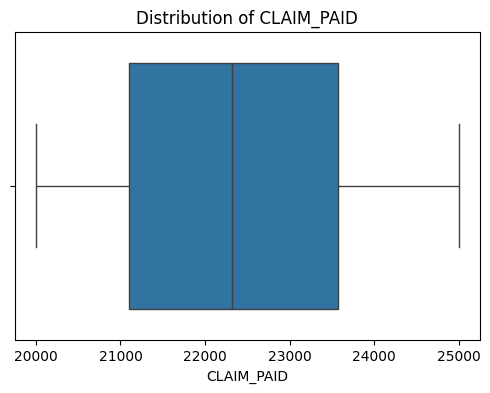

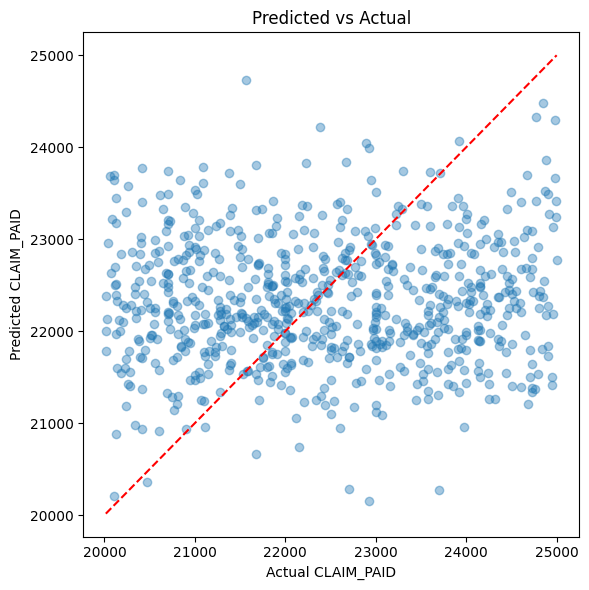

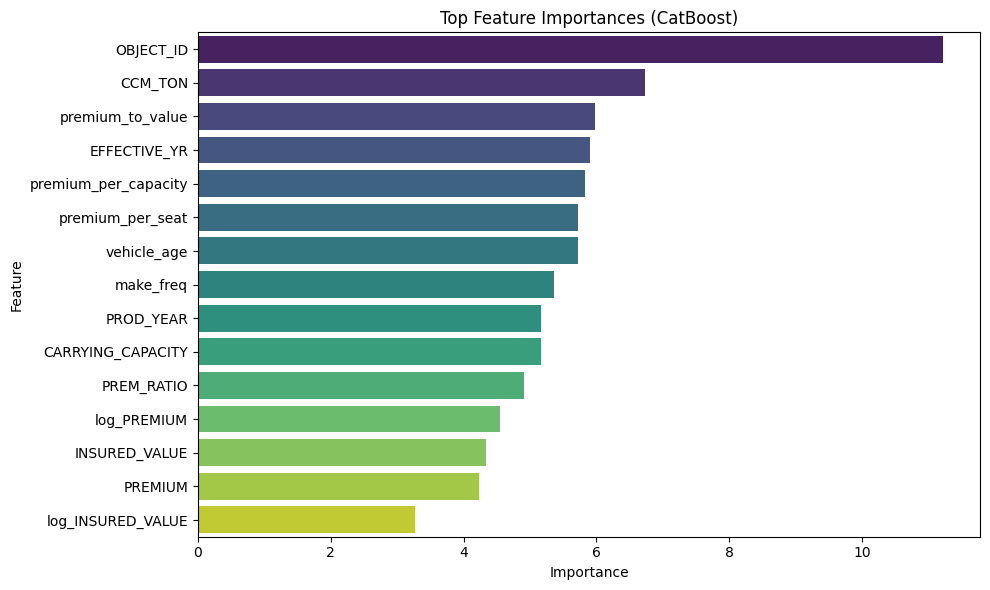

In [69]:
data_filtered = df[(df["CLAIM_PAID"] > 0.2*100000) & (df["CLAIM_PAID"] < 0.25*100000)]
pipeline, y_test, y_pred = train_claim_regressor(data_filtered, test_size=0.2, random_state=42)
results_reg(data_filtered, y_test, y_pred, pipeline)

Filtered dataset shape: (6233, 26)
0:	learn: 2392.1098657	total: 57.7ms	remaining: 28.8s
50:	learn: 2072.2018548	total: 2.9s	remaining: 25.5s
100:	learn: 1867.1215322	total: 5.78s	remaining: 22.8s
150:	learn: 1681.7844608	total: 8.61s	remaining: 19.9s
200:	learn: 1524.1694132	total: 11.5s	remaining: 17.1s
250:	learn: 1415.6250963	total: 14.4s	remaining: 14.3s
300:	learn: 1334.2880093	total: 17.2s	remaining: 11.3s
350:	learn: 1280.4852669	total: 20s	remaining: 8.5s
400:	learn: 1229.3266645	total: 22.9s	remaining: 5.66s
450:	learn: 1191.5709795	total: 25.7s	remaining: 2.8s
499:	learn: 1139.6229782	total: 28.6s	remaining: 0us

===== Results on Claims Dataset =====
MAE: 2494.564001353274
RMSE: 2978.786504896837
y_test range: (np.float64(20000.7), np.float64(29999.99))
y_pred range: (np.float64(20702.860296705894), np.float64(28237.229049254813))
===== Regression Results =====
MAE: 2494.56
RMSE: 2978.79
Mean Relative Error (%): 10.20
Std of CLAIM_PAID: 2823.42


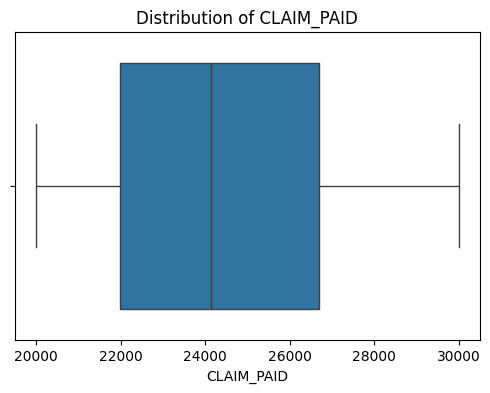

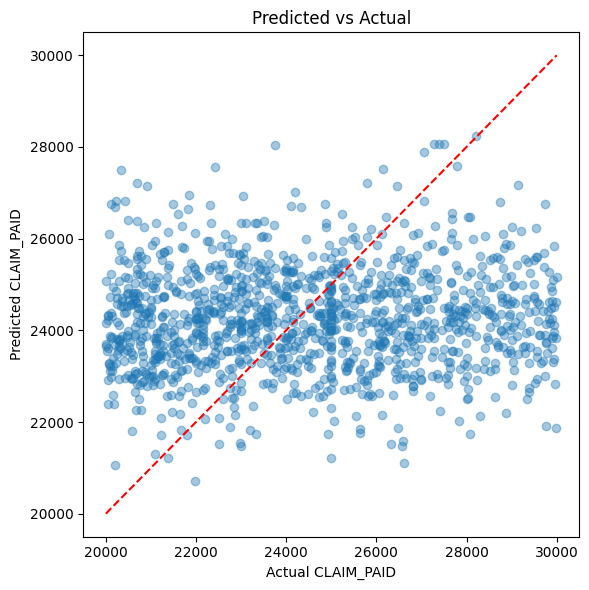

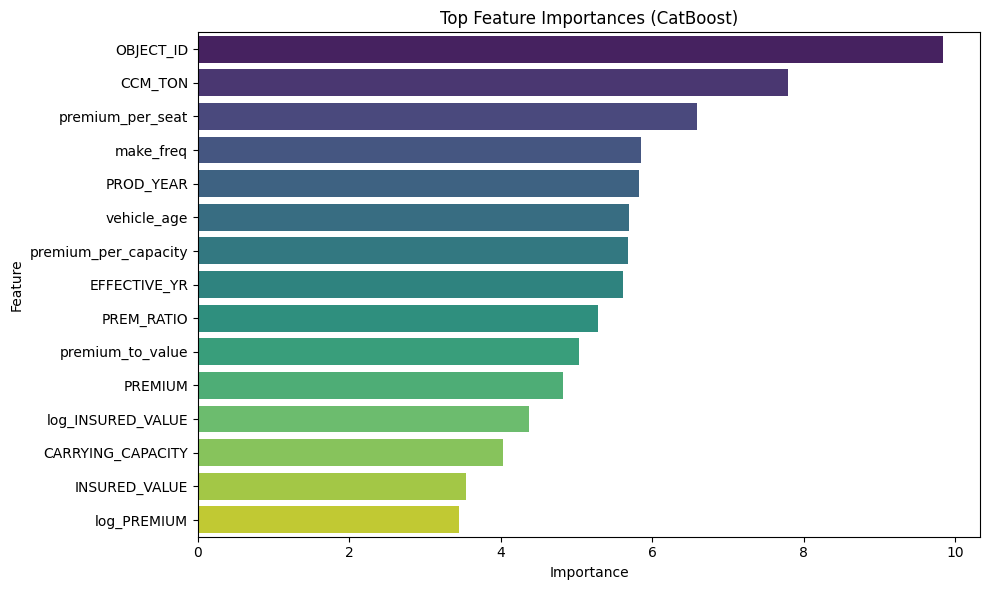

In [70]:
data_filtered = df[(df["CLAIM_PAID"] > 0.2*100000) & (df["CLAIM_PAID"] < 0.3*100000)]
pipeline, y_test, y_pred = train_claim_regressor(data_filtered, test_size=0.2, random_state=42)
results_reg(data_filtered, y_test, y_pred, pipeline)

Filtered dataset shape: (2730, 26)
0:	learn: 24618.5870686	total: 54.2ms	remaining: 27s
50:	learn: 18330.2340272	total: 2.64s	remaining: 23.2s
100:	learn: 15472.1585313	total: 5.18s	remaining: 20.5s
150:	learn: 12897.0433636	total: 7.88s	remaining: 18.2s
200:	learn: 11272.0954879	total: 10.6s	remaining: 15.7s
250:	learn: 10144.4855767	total: 13.2s	remaining: 13.1s
300:	learn: 9433.8117100	total: 15.9s	remaining: 10.5s
350:	learn: 8805.1013681	total: 18.5s	remaining: 7.86s
400:	learn: 8298.7890405	total: 21.2s	remaining: 5.23s
450:	learn: 7867.2489995	total: 23.9s	remaining: 2.6s
499:	learn: 7535.7021730	total: 26.5s	remaining: 0us

===== Results on Claims Dataset =====
MAE: 26809.79060086792
RMSE: 31716.688518477014
y_test range: (np.float64(200140.0), np.float64(299793.5))
y_pred range: (np.float64(212049.12830347312), np.float64(300104.25462550303))
===== Regression Results =====
MAE: 26809.79
RMSE: 31716.69
Mean Relative Error (%): 11.10
Std of CLAIM_PAID: 29029.23


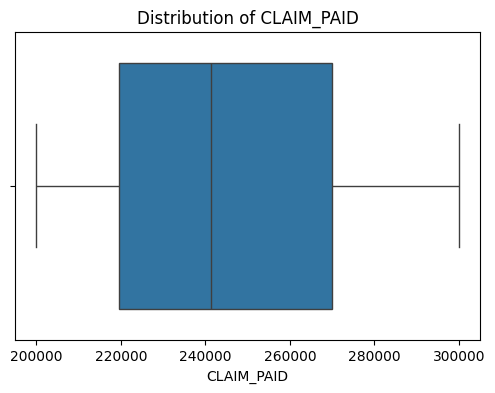

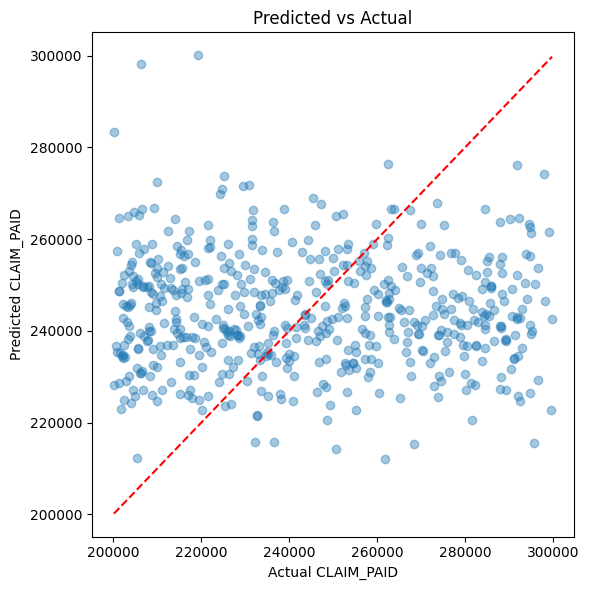

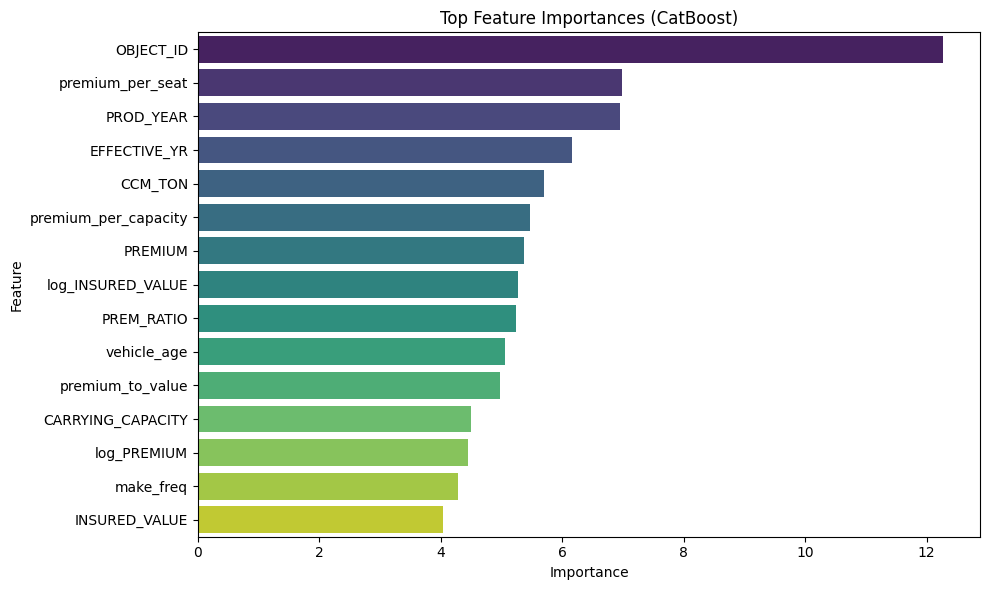

In [71]:
data_filtered = df[(df['CLAIM_PAID'] > 0.2*1000000) & (df['CLAIM_PAID'] < 0.3*1000000)]
pipeline, y_test, y_pred = train_claim_regressor(data_filtered, test_size=0.2, random_state=42)
results_reg(data_filtered, y_test, y_pred, pipeline)

Filtered dataset shape: (12199, 26)
0:	learn: 85965.2100937	total: 74.8ms	remaining: 37.3s
50:	learn: 78938.3931813	total: 3.42s	remaining: 30.1s
100:	learn: 75329.7568603	total: 7.07s	remaining: 27.9s
150:	learn: 72879.3463802	total: 10.8s	remaining: 24.9s
200:	learn: 70289.7755546	total: 14.4s	remaining: 21.4s
250:	learn: 68033.1015058	total: 17.8s	remaining: 17.6s
300:	learn: 66274.3450974	total: 21.2s	remaining: 14s
350:	learn: 64930.2189945	total: 24.7s	remaining: 10.5s
400:	learn: 63242.6698334	total: 28.2s	remaining: 6.97s
450:	learn: 61452.2379923	total: 36.8s	remaining: 3.99s
499:	learn: 60181.2250743	total: 47s	remaining: 0us

===== Results on Claims Dataset =====
MAE: 88130.89646916285
RMSE: 112131.71803027652
y_test range: (np.float64(100018.81), np.float64(498700.16))
y_pred range: (np.float64(105792.1314847531), np.float64(415117.60395615525))
===== Regression Results =====
MAE: 88130.90
RMSE: 112131.72
Mean Relative Error (%): 40.34
Std of CLAIM_PAID: 107295.31


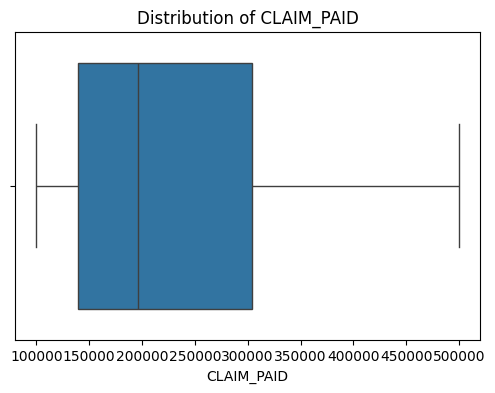

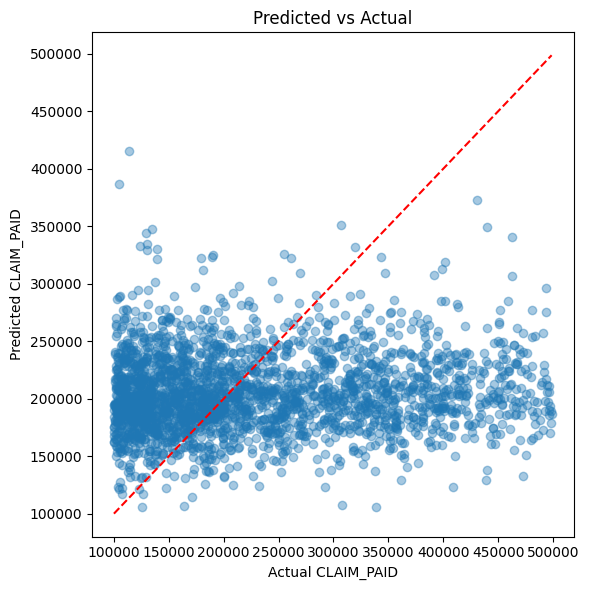

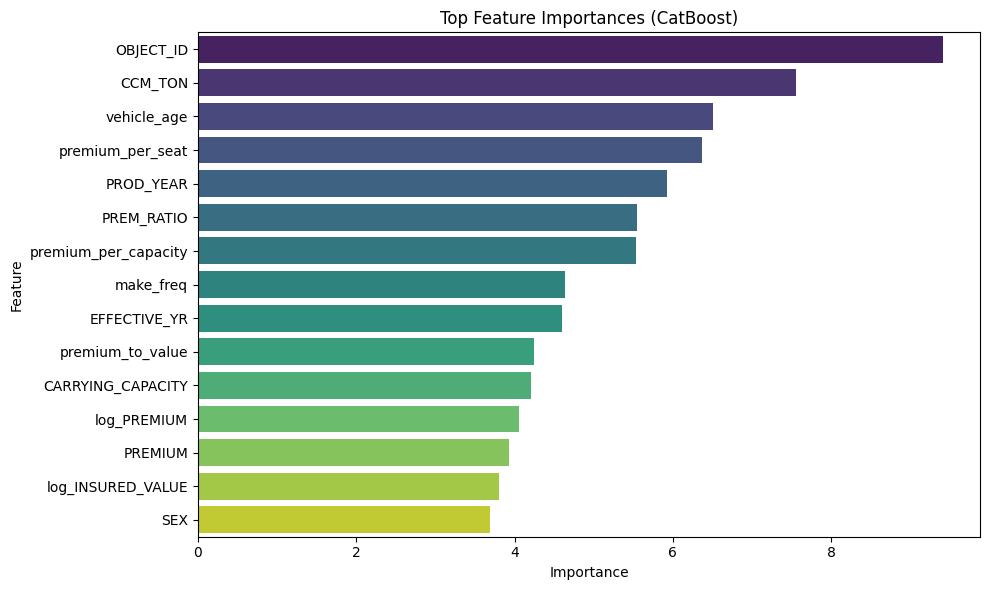

In [72]:
data_filtered = df[(df['CLAIM_PAID'] > 100000) & (df['CLAIM_PAID'] < 500000)]
pipeline, y_test, y_pred = train_claim_regressor(data_filtered, test_size=0.2, random_state=42)
results_reg(data_filtered, y_test, y_pred, pipeline)